# TODO

- [ ] Plug inflation in housing stock
- [ ] Add other autonomous expenditure

In [1]:
#!pip install pysolve3

Time checking:

In [2]:
from datetime import datetime
t1 = datetime.now()

# Introduction

Jupyter notebook for the simplest model scratch. By convention, all exogenous variables are presented with a overline line (*e.g.* $\overline a$) and the parameters are represented by greek letters (*e.g.* $\alpha$). The code in this document is executable and is strongly recommend to do the follow to ensure that the output is corrected and updated:

Run time > Restart and run all...

# Changes

In this version, the autonomous growth rate is endogenized as a function of housing own interest rates:

$$
g_Z = \phi_0  -\phi_1\cdot \left(\frac{1+r_{mo}}{1+\dot p_h}-1\right)
$$
which

- $\phi_0$ and $\phi_1$ are parameters
- $\dot p_h$ is housing inflation and equals 0 in this version

$$
\dot p_h = \frac{\Delta p_h}{p_{h_{-1}}}
$$

## General Equations

$$
Y = C + I
$$

$$
I = I_f + I_h
$$

$$
\omega = \overline \omega
$$

$$
W = \omega \cdot  Y
$$

$$
Y_K = \frac{K_f}{\overline v}
$$

$$
u = \frac{Y}{Y_K}
$$

$$
g_k = \frac{h\cdot u}{v}
$$

$$
Z = I_h
$$

$$
K = K_f + K_{HD}
$$

## Households

$$
YD = W + FD + \overline r_{m-1}\cdot M_{-1} - \overline r_{mo-1}\cdot MO - r_l\cdot{L_h}
$$


$$
S_h = YD - C = \Delta M
$$

$$
C = \alpha\cdot W
$$


$$
\Delta MO = I_h
$$

$$
V_h = M + K_H - MO
$$

$$
NFW_h = S_h - I_h
$$

$$
\text{Residual} = \Delta M - \Delta L_f 
$$

## Firms

$$
\Delta L_f = I_f - FU
$$

$$
FT = Y - W = FU+ FD
$$

$$
FU = \gamma_F\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$


$$
FD = (1 - \gamma_F)\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$

$$
I_f = h\cdot Y
$$

$$
\Delta K_f = I_f
$$

$$
\Delta h = 
h_{-1}\cdot \gamma_u\cdot (u - \overline u_n)
$$

$$
V_f = K_f  - L_f
$$

$$
NFW_f = FU - I_f
$$

## Banks

$$
L = L_f
$$

$$
\Delta M = \Delta L + \Delta MO
$$

$$
NFW_b = rl_{-1}\cdot L_{-1} + rmo_{-1}\cdot MO_{-1} - rm_{-1}\cdot M_{-1}
$$

$$
r_l = r_m + spread_l (=0)
$$

$$
r_{mo} = r_m + spread_{mo} (=0)
$$

$$
V_b = L + MO - M
$$

## Residential Investment


$$
K_{HS} = K_{HD}
$$

$$
I_h^S = I_h
$$

$$
\Delta K_{HD} = I_h
$$

$$
I_h = (1+g_Z)\cdot I_{h_{-1}}
$$


$$
k = \frac{K_h*p_h}{K}
$$

$$
g_Z = phi_0 - phi_1\cdot own
$$

$$
own = \left(\frac{1+r_{mo}}{1+\dot p}\right) -1
$$

# Simulation setup

## Loading libraries

In [3]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import networkx as nx
import sympy as sp
from sympy import pprint, cse

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy.stats import yeojohnson

plt.style.use('seaborn-white')

from pysolve3.model import Model
from pysolve3.utils import SolveSFC, ShockModel, SummaryShock, SFCTable

import pandas_datareader.data as web
start = datetime(1987, 1, 1)
end = datetime(2018, 12, 31)

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


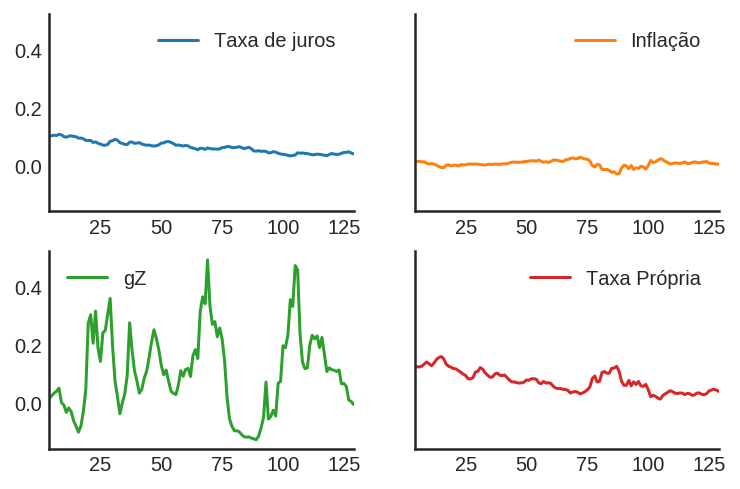

In [4]:
data = pd.read_csv('../SeriesTemporais/Dados_yeojohnson.csv')

data = data[[
    "Taxa de juros", 
    "Inflação", 
    "gZ", 
    "Crise", 
    "Taxa Própria",
]]
        
data = data.dropna()

fig, ax = plt.subplots()

data.drop('Crise', axis='columns').plot(ax=ax, subplots=True, layout=(2,2), sharex=False, sharey=True)
ax.axhline(y=0, ls='--', color='black')
sns.despine()
plt.show()
fig.savefig('YeoJohnson.png', dpi=300, bbox_inches = 'tight',)

# Creating model function

In [5]:
def model(
    alpha = 1,
    #gamma_F = 0.4,
    gamma_F = 0.08,
    gamma_u = 0.01,
    g_Z = 0.05,
    omega = 0.4,
    rm = 0.02,
    spread_l = 0,
    spread_mo = 0,
    un = 0.8,
    v = 2.5,
    phi_0 = 0.02,
    phi_1 = 0.02,
    infla = 0.0,
    phparam=1.0,
    R = 0.1,
    a=.1
):
  """
  phparam: 1.0 means no inflation
  """
  model = Model()
  model.set_var_default(0) 
  model.var('C', desc='Consumption')
  model.var('Cw', desc='Workers Consumption', default=112)
  model.var('Ck', desc='Capitalist Consumption', default=68)
  model.var('Eq', desc='Equities')
  model.var('FD', desc='Distributed profits')
  model.var('Fn', desc='Net profits')
  model.var('FT', desc='Total Profits')
  model.var('FU', desc='Retained profits')
  model.var('gk', desc='Capital growth rate')
  model.var('g_Z', desc='Autonomous grouth rate')
  model.var('h', desc='Marginal propensity to invest (non-residential)', default=0.06)
  model.var('I_t', desc='Investment', default = 100) # 200
  model.var('I_f', desc='Non-residential investment') # 100
  model.var('I_h', desc='Residential investment', default = 100) # 100
  model.var('Is', desc='Residential investment (Supply)', default = 100) # 100
  model.var('K_HS', desc='Houses supply', default=500) # 500
  model.var('K_HD', desc='Houses demand', default=500) # 500
  model.var('K_f', desc='Non-residential capital', default = 1000) # 10000
  model.var('Knom', desc='Nominal Capital', default=1500)
  model.var('K', desc='Real Capital', default=1500)
  model.var('K_k', desc="% of Kf in total")
  model.var('L', desc='Total Loans') # 100
  model.var('Lf', desc='Firms Loans') # 100
  model.var('Lk', desc='Capitalist Loans') # 100
  model.var('M', desc='Money deposits') # 300
  model.var('M_h', desc='Households deposits')
  model.var('M_f', desc='Firms deposits')
  model.var('MO', desc='Mortgages') # 200
  model.var('NFW_h', desc='Households Capitalist Net Financial Wealth')
  model.var('NFW_hw', desc='Workers Net Financial Wealth', default=0)
  model.var('NFW_f', desc='Firms Net Financial Wealth')
  model.var('NFW_b', desc='Banks Net Financial Wealth')
  model.var('own', desc='Own interest rate')
  model.var('ph', desc='House price', default = 1)
  model.var('rl', desc='Interests rates on loans')
  model.var('rmo', desc='Interests rates on mortgages')
  model.var('S_hw', desc='Workers savings')
  model.var('S_hk', desc='Capitalist savings')
  model.var('u', desc='Capacity utilization ratio', default=0.7)
  model.var('V_h', desc='Household net nominal wealth')
  model.var('V_hr', desc='Household net real wealth')
  model.var('V_f', desc='Firms net wealth')
  model.var('V_b', desc='Banks net wealth')
  model.var('W', desc='Wages')
  model.var('Y', desc='GDP', default=280)
  model.var('Yk', desc='Capacity', default=1100)
  model.var('YDw', desc='Workers disposable income')
  model.var('YDk', desc='Capitalists disposable income')
  model.var('Z', desc='Autonomous expenditures')
  model.var('Residual', desc='Unecessarily equation. Should be zero')
  
  model.param('a', desc='Equity parameter', default=a)
  model.param('alpha', desc='Propensity to consume out of wages', default=alpha)
  model.param('gamma_F', desc='% of undistributed profits', default=gamma_F)
  model.param('gamma_u', desc='Adjustment parameter for the marginal propensity to invest', default=gamma_u) # 0.01
  model.param('omega', desc='Wage-share', default = omega)
  model.param('rm', desc='Interest rates on money deposits', default=rm) # 0.02
  model.param('spread_l', desc='Spread for loans', default=spread_l)
  model.param('spread_mo', desc='Spread for mortgages', default=spread_mo)
  model.param('un', desc='Normal capacity utilization ratio', default=un)
  model.param('v', desc='Capitl-Output ratio', default=v)
  model.param('phi_0', desc='Autonomous housing investment component',default = phi_0)
  model.param('phi_1', desc='Housing investment sensitivity to own interest rate', default = phi_1)
  model.param('phparam', desc='ph parameter', default = phparam)
  model.param('pe', desc='Equity price', default = 1)
  model.param('R', desc='Autonomous ratio', default=R)
  model.param('infla', desc='infla value', default = infla)
  
  # General equations
  model.add('Y = C + I_t') # Eq1
  model.add('C = Cw + Ck')
  model.add('I_t = I_f + I_h') # Eq2
  model.add('Yk = K_f(-1)/v') # Eq 4
  model.add('u = Y/Yk') # Eq 5
  model.add('W = omega*Y') # Eq 6
  model.add('gk = h*u/v') # Eq 7
  model.add('Knom = K_HD*ph + K_f') # Eq 8 
  model.add('K = K_HD + K_f') # Eq 8 
  model.add('Z = I_h + Ck') # Eq 9
  
  # Workers equations
  model.add('Cw = alpha*W') # Eq 14
  model.add('YDw = W') # Eq 10
  model.add('S_hw = YDw - Cw') # Eq 11
  model.add('NFW_hw = S_hw')
    
  # Capitalist equations
  model.add('YDk = FD + rm*M_h(-1) - rmo*MO(-1) - rl*Lk(-1)')
  model.add('Ck = R*I_h')
  model.add('S_hk = YDk - Ck') # Eq 11
  model.add('d(MO) = I_h') # Eq 12
  model.add('d(Lk) = Ck')
  model.add('d(M_h) = S_hk + d(Lk) - d(Eq)')
  model.add('V_h =  M_h  + K_HD*ph + Eq - MO - Lk') # Eq 15 
  model.add('V_hr =  M_h  + K_HD + Eq - MO - Lk') # Eq 15 
  model.add('NFW_h = S_hk - I_h') # Eq 16
  
  # Firms
  model.add('d(Lf) = I_f - FU - d(Eq) + d(M_f)') # Eq 15
  model.add('Eq = a*K_f(-1)')
  model.add('FT = (1-omega)*Y') # Eq 16
  model.add('Fn = FT -rl*Lf(-1) + rm*M_f(-1)')
  model.add('FU = gamma_F*(Fn)') # Eq 17
  model.add('FD = (1 - gamma_F)*(Fn)') # Eq 18
  model.add('I_f = h*Y') # Eq 19
  model.add('d(K_f) = I_f') # 20
  model.add('h = h(-1)*gamma_u*(u-un) + h(-1)') # Eq 21 # Version without corridor
  model.add('V_f = K_f + M_f - Lf - Eq') # Eq 22
  model.add('NFW_f = FU - I_f') # Eq 23
  
  # Banks
  model.add('rmo = rm + spread_mo') # Eq 25
  model.add('rl = rm + spread_l') # Eq 26
  model.add('NFW_b = rl*L(-1) + rmo*MO(-1) - rm*M(-1)') # Eq 28
  #model.add('d(M_f) = -d(Lf)')
  model.add('M_f = 0')
  #model.add('M_f = M - M_h')
  #model.add('d(M_h) = d(Lk) + d(MO)')
  #model.add('d(M_f) = d(Lf) + d(Eq) - NFW_f')
  #model.add('d(M) = d(L) + d(MO)')
  model.add('V_b = L + MO - M') # Eq 27
  model.add('d(L) = d(Lf) + d(Lk)')
  model.add('d(M) = d(M_h) + d(M_f)')
  
  
  # Residential investment
  model.add('K_HS = K_HD') # Eq 29
  model.add('Is = I_h')
  model.add('d(K_HD) = I_h') # Eq 30
  model.add('I_h = (1+g_Z)*I_h(-1)') # Eq 31
  model.add('K_k = K_HD/K') 
  model.add('ph =(1+infla)*ph(-1)')
  model.add('own = ((1+rmo)/(1+infla)) -1')  
  model.add('g_Z = phi_0 - phi_1*own') 
  
  model.add('Residual = d(L) + d(MO) - d(M)') # Change!
  
  return model

t_check = 100
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Capitalists' : test.evaluate('K_HD*ph + M_h + Eq - MO - Lk - V_h'),
    'Firms' : test.evaluate('K_f - Lf - Eq - V_f'),
    'Banks' : test.evaluate('L + MO - M - V_b'),
    'Mortgages' : test.evaluate('MO(-1) - MO(-2) - I_h(-1)'),
    'Loans' : test.evaluate('L - Lf - Lk'),
    'Financial assets' : test.evaluate('d(MO) + d(L) - d(M)'),
    '[Total Wealth - K]' : test.evaluate('V_f + V_h + V_b - K'),
    "Firm's Funds" : test.evaluate('Lf(-1) - Lf(-2) - I_f(-1) + FU(-1) + Eq(-1) - Eq(-2)  - (M_f(-1) - M_f(-2))'),
    "Housing" : test.evaluate('K_HD - K_HS'),
    "Flow check" : test.evaluate('NFW_h + NFW_f + NFW_b + NFW_hw'),
    "Investment" : test.evaluate('I_t - I_h - I_f'),
    "Profits" : test.evaluate('FT(-1) - rl*Lf(-2) - FU(-1) - FD(-1)'), # Chanve
    "Wages" : test.evaluate('W - omega*Y'),
    "Residual" : test.evaluate('Residual')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 100


Sum
Capitalists         0.00000
Firms               0.00000
Banks              -0.00005
Mortgages           0.00000
Loans              -0.00000
Financial assets    0.00000
[Total Wealth - K]  0.00005
Firm's Funds       -0.00000
Housing             0.00000
Flow check         -0.00005
Investment         -0.00000
Profits            -0.00000
Wages               0.00000
Residual            0.00046

In [6]:
t_check = 1
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Cw' : test.evaluate('Cw'),
    'Ck' : test.evaluate('Ck'),
    'I_h' : test.evaluate('I_h'),
    'I_f' : test.evaluate('I_f'),
    'K_f(-1)' : test.evaluate('K_f(-1)'),
    'Yk' : test.evaluate('Yk'),
    'Y' : test.evaluate('Y'),
    'gk' : test.evaluate('gk'),
    'u' : test.evaluate('u'),
    "Residual" : test.evaluate('Residual')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 1


Sum
Cw          83.05261
Ck          10.19600
I_h        101.96000
I_f         12.42289
K_f(-1)   1012.42289
Yk         400.00000
Y          207.63151
gk           0.01242
u            0.51908
Residual     0.00002

In [7]:
t_check=100
variable = 'a'
for i in range(0,11,1):
    i = i/10
    print(f'{variable} = {i}')
    check = model(a=i)
    SolveSFC(check, time=t_check, table = False)
    evaldf = pd.DataFrame({
        'S_hk > 0?' : check.evaluate('S_hk')>0,
        'NFW_h > 0?' : check.evaluate('NFW_h')>0,
        'NFW_f > 0?' : check.evaluate('NFW_f')>0,
        'NFW_b ~ 0?' : check.evaluate('NFW_b'),
        'V_b ~ 0?' : check.evaluate('V_b'),
        'Lf > 0?': check.evaluate('Lf')>0,
        'u:': check.evaluate('u'),
        'FT > Fn?': check.evaluate('FT')>check.evaluate('Fn'), 
        "Residual" : check.evaluate('Residual')
    }, index = [f'{variable} = {i}'])
    evaldf = evaldf.transpose().round(5)
    print(evaldf)

a = 0.0
                a = 0.0
S_hk > 0?          True
NFW_h > 0?         True
NFW_f > 0?        False
NFW_b ~ 0?  0.000410232
V_b ~ 0?      0.0210263
Lf > 0?            True
u:             0.811933
FT > Fn?           True
Residual    0.000463409
a = 0.1
                a = 0.1
S_hk > 0?          True
NFW_h > 0?         True
NFW_f > 0?        False
NFW_b ~ 0?  0.000410232
V_b ~ 0?      0.0210263
Lf > 0?           False
u:             0.811933
FT > Fn?          False
Residual    0.000463409
a = 0.2
                a = 0.2
S_hk > 0?          True
NFW_h > 0?         True
NFW_f > 0?        False
NFW_b ~ 0?  0.000410232
V_b ~ 0?      0.0210263
Lf > 0?           False
u:             0.811933
FT > Fn?          False
Residual    0.000463409
a = 0.3
                a = 0.3
S_hk > 0?          True
NFW_h > 0?         True
NFW_f > 0?        False
NFW_b ~ 0?  0.000410232
V_b ~ 0?      0.0210263
Lf > 0?           False
u:             0.811933
FT > Fn?          False
Residual    0.000463409
a = 0.4


# Solving

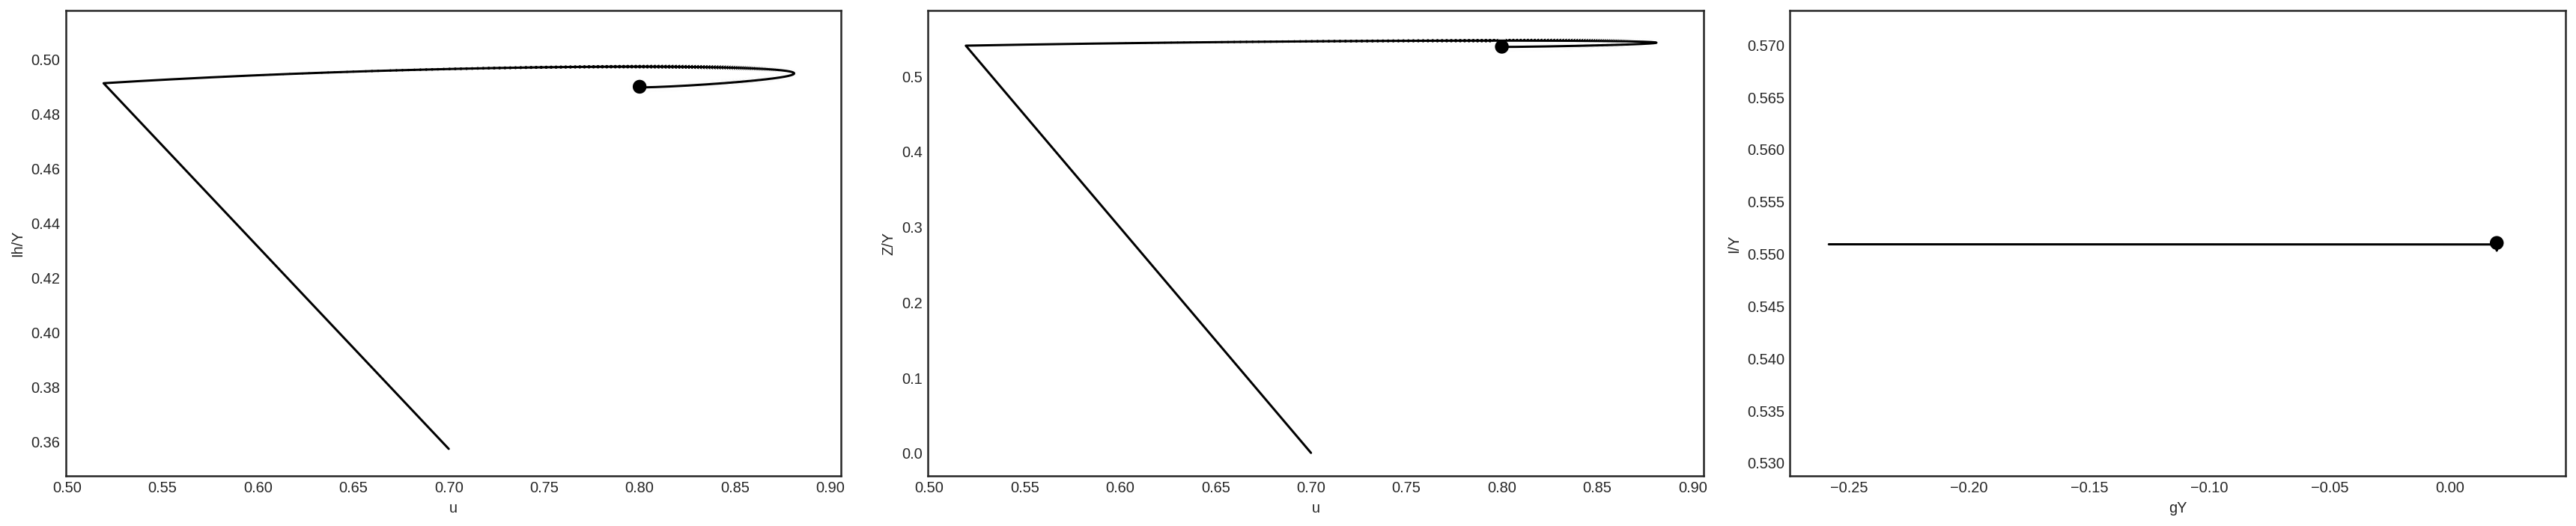

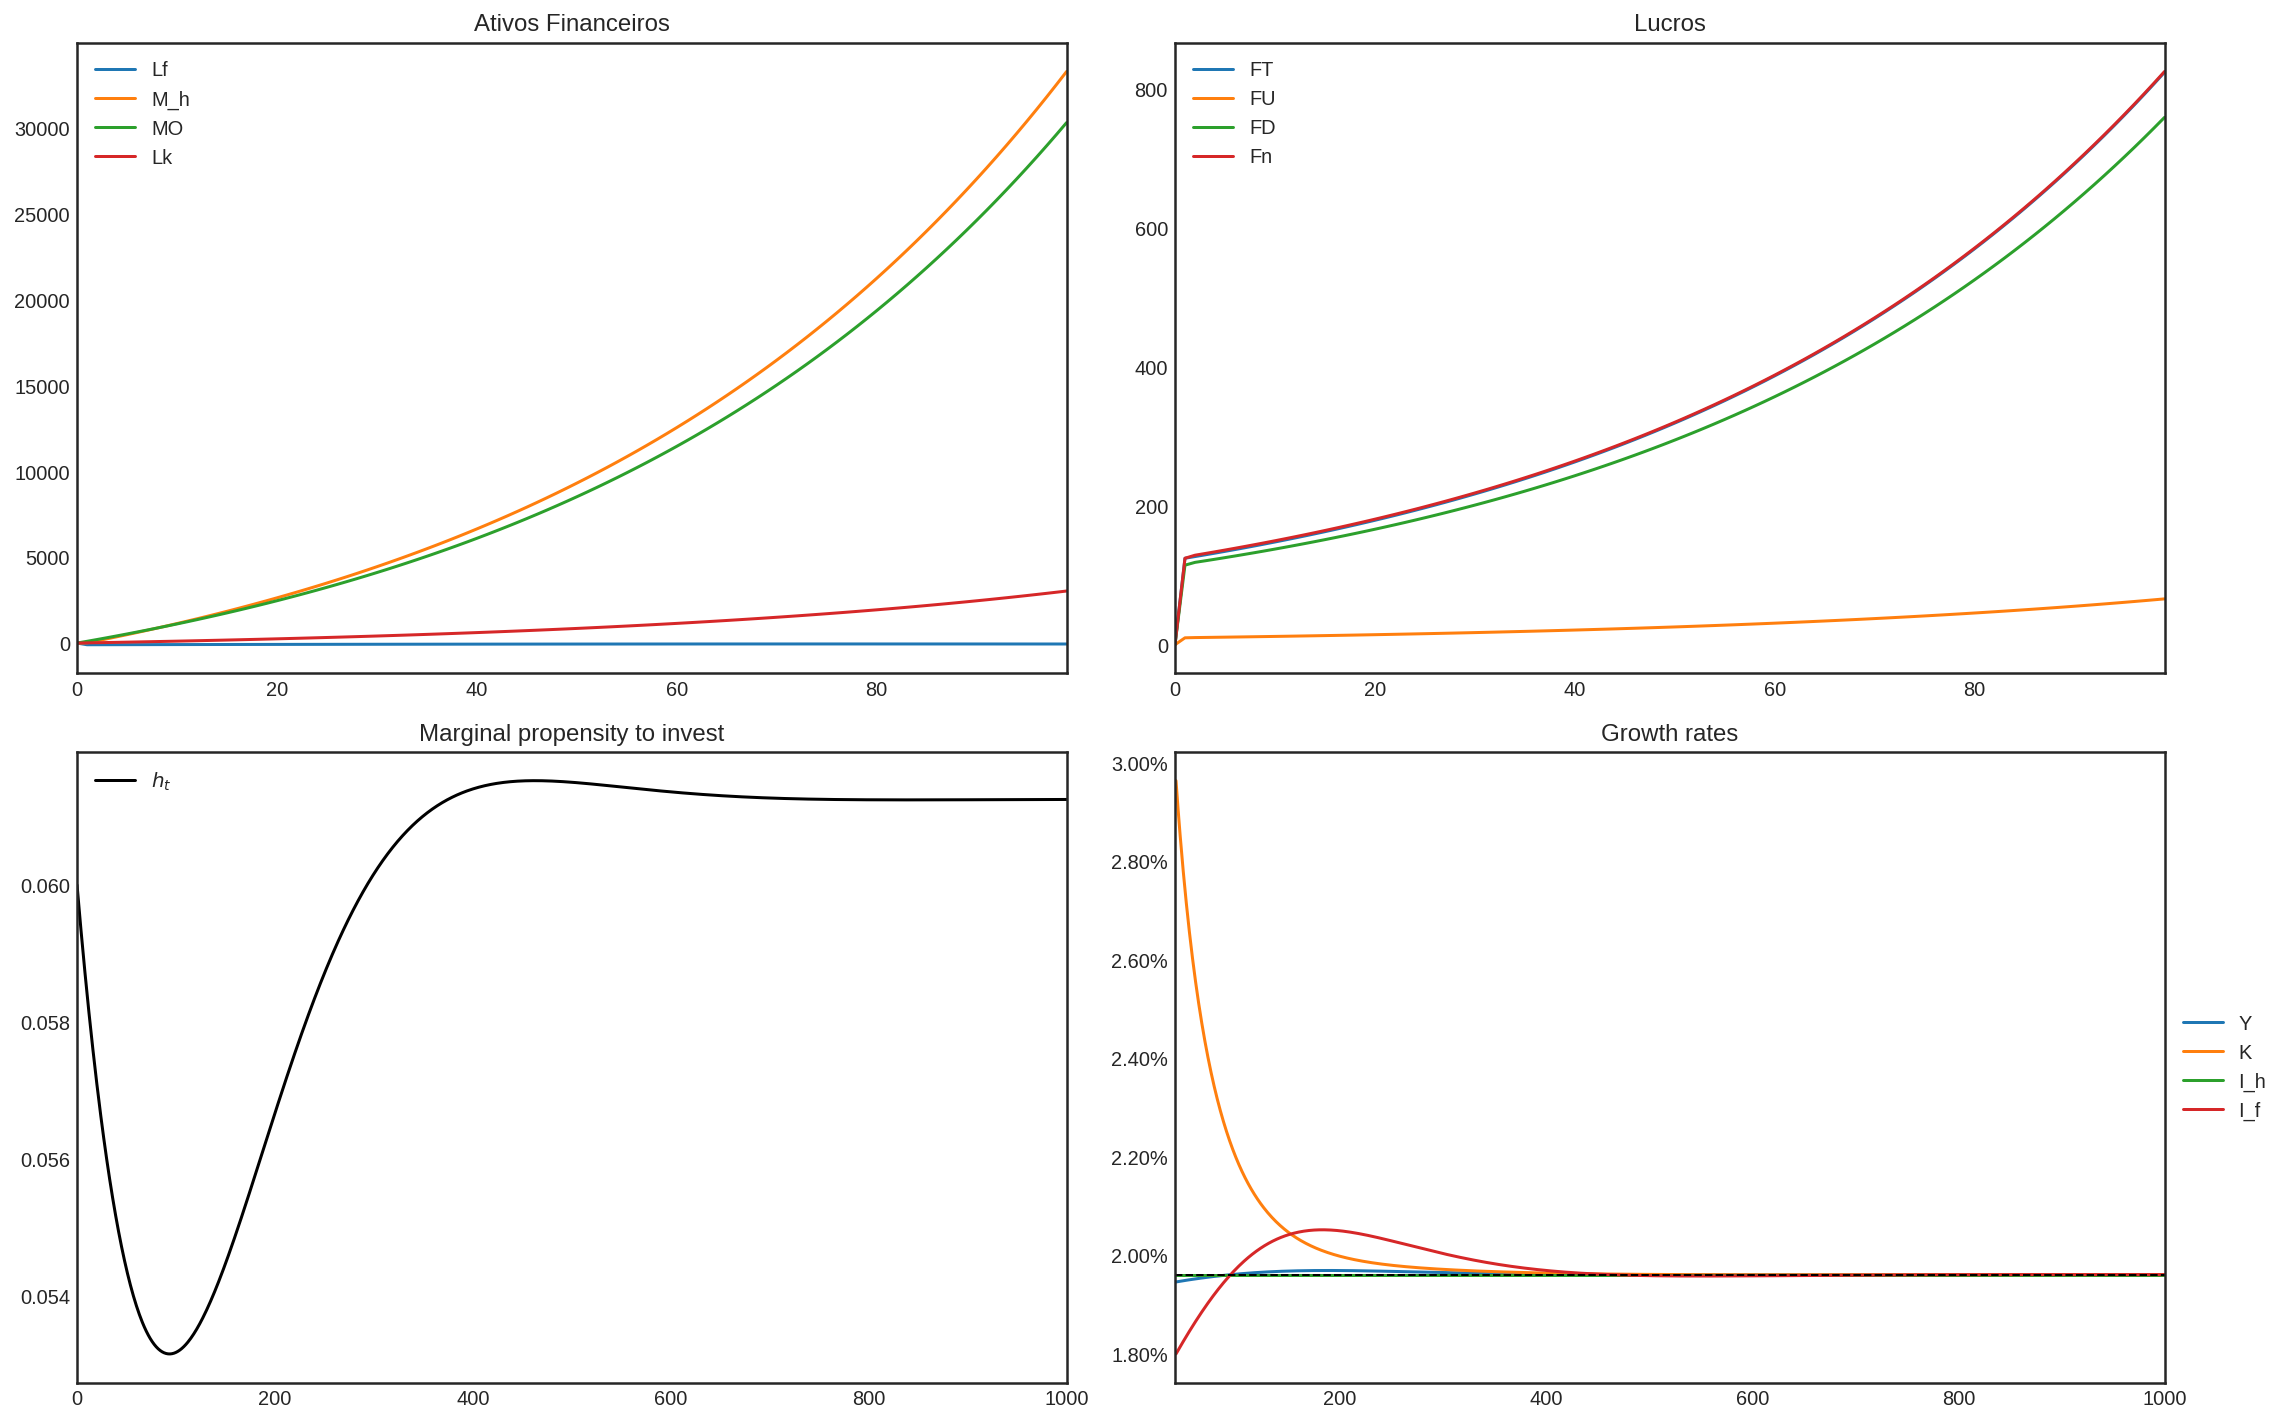

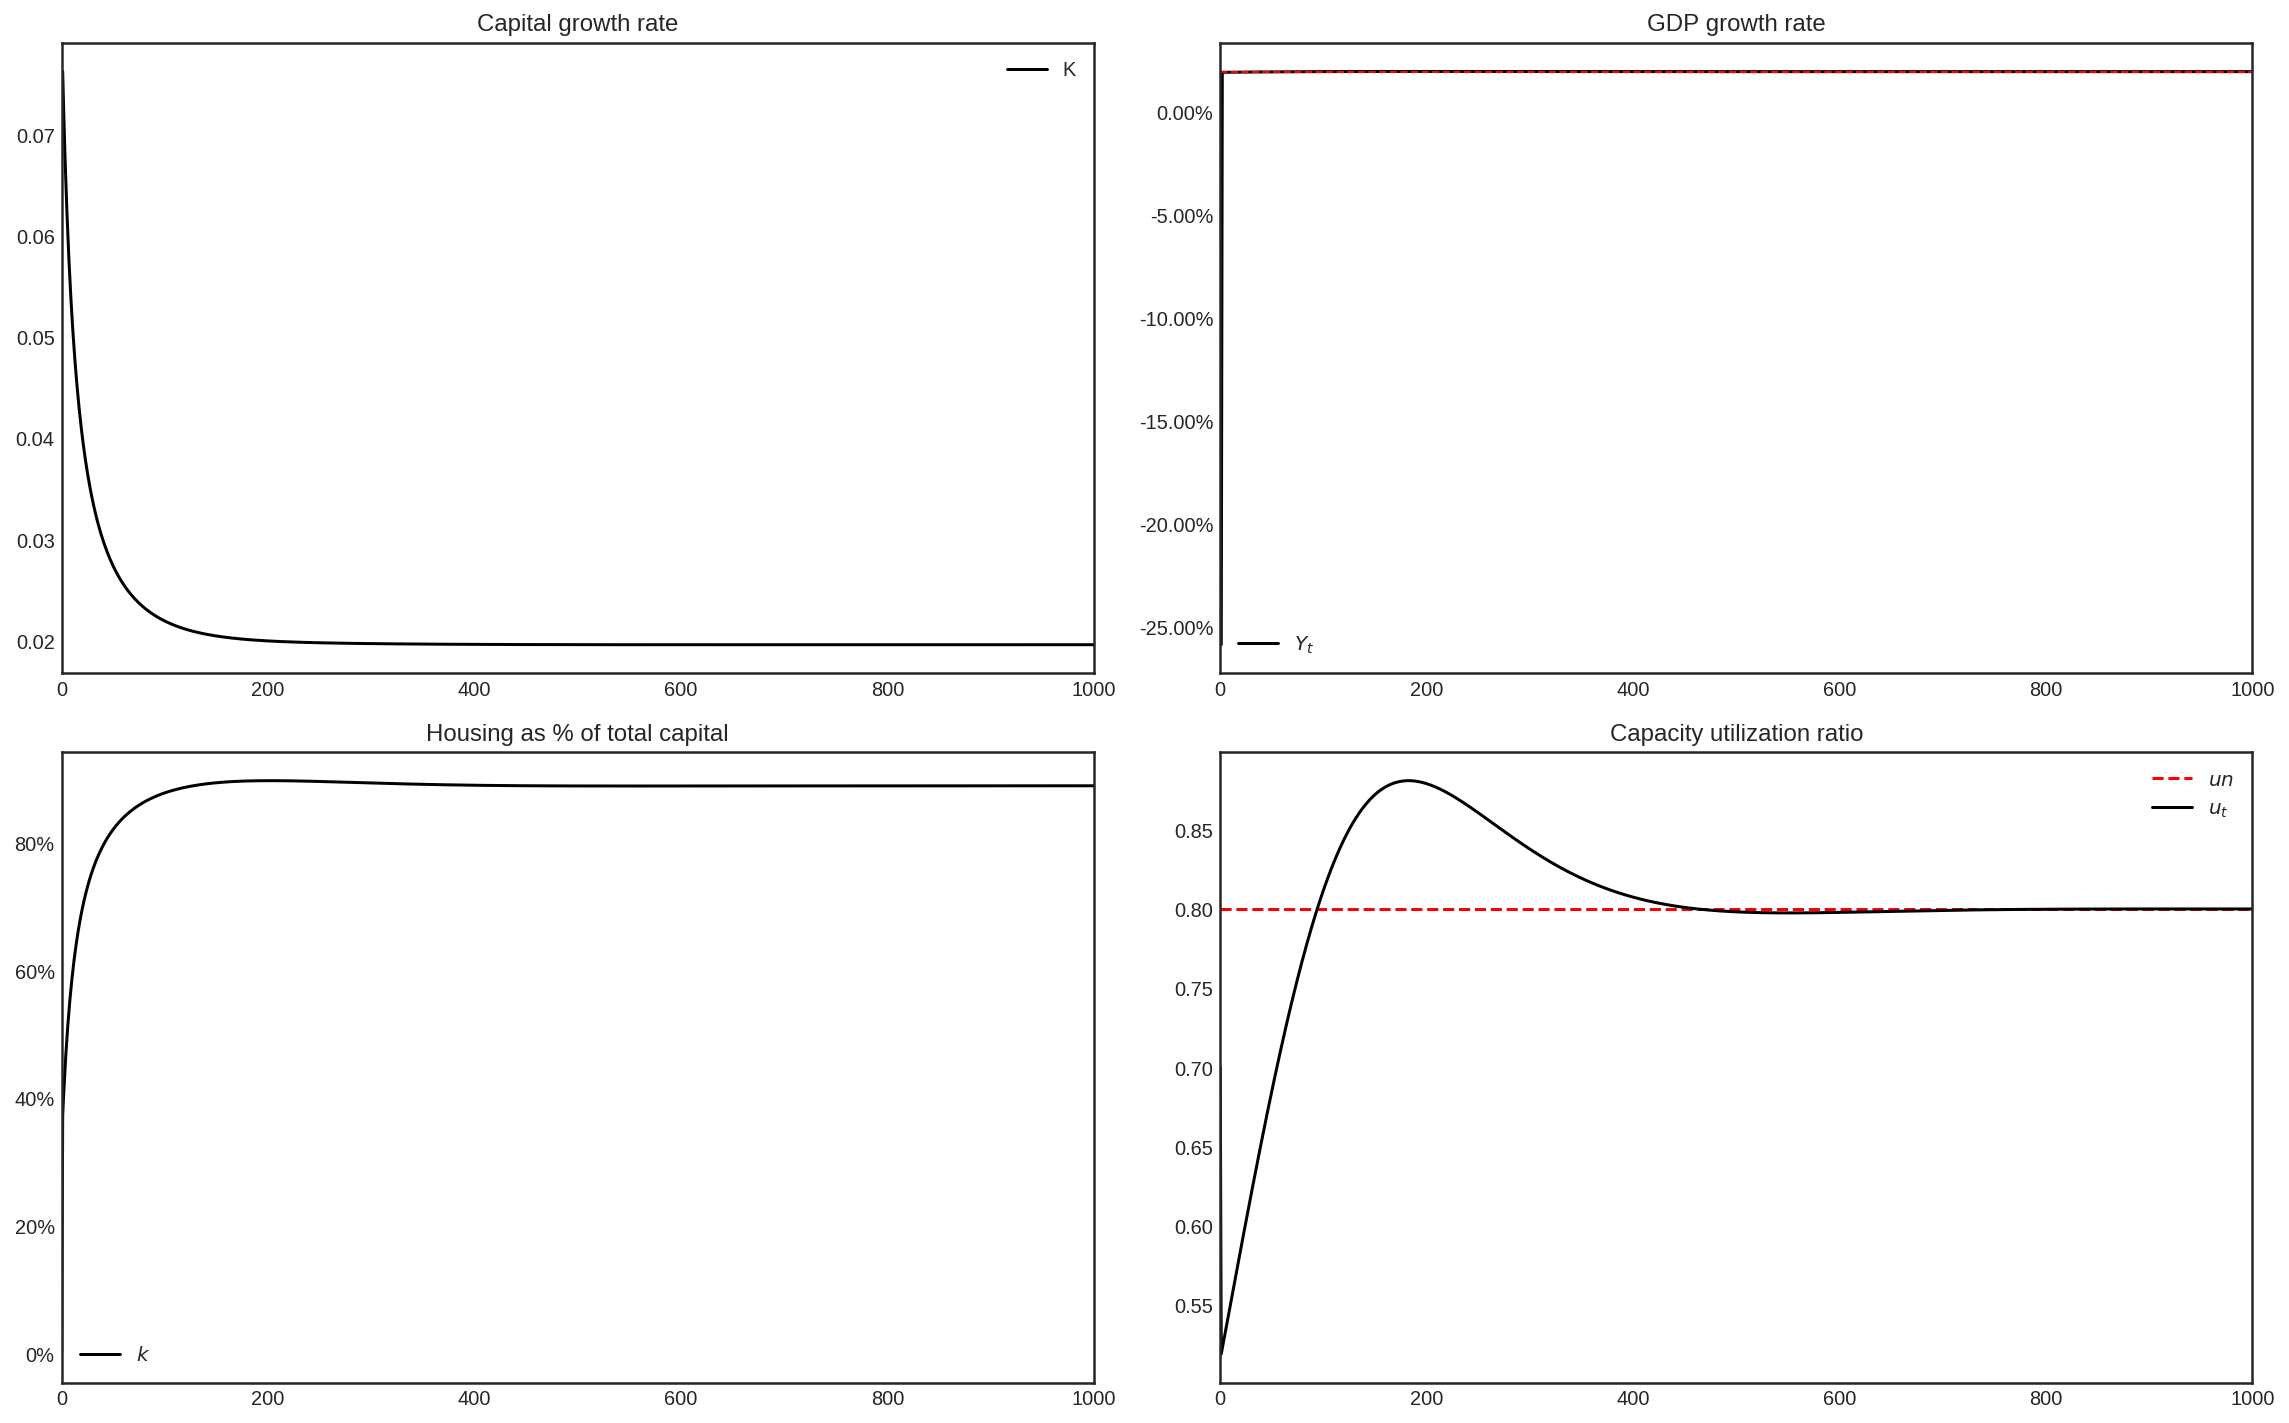

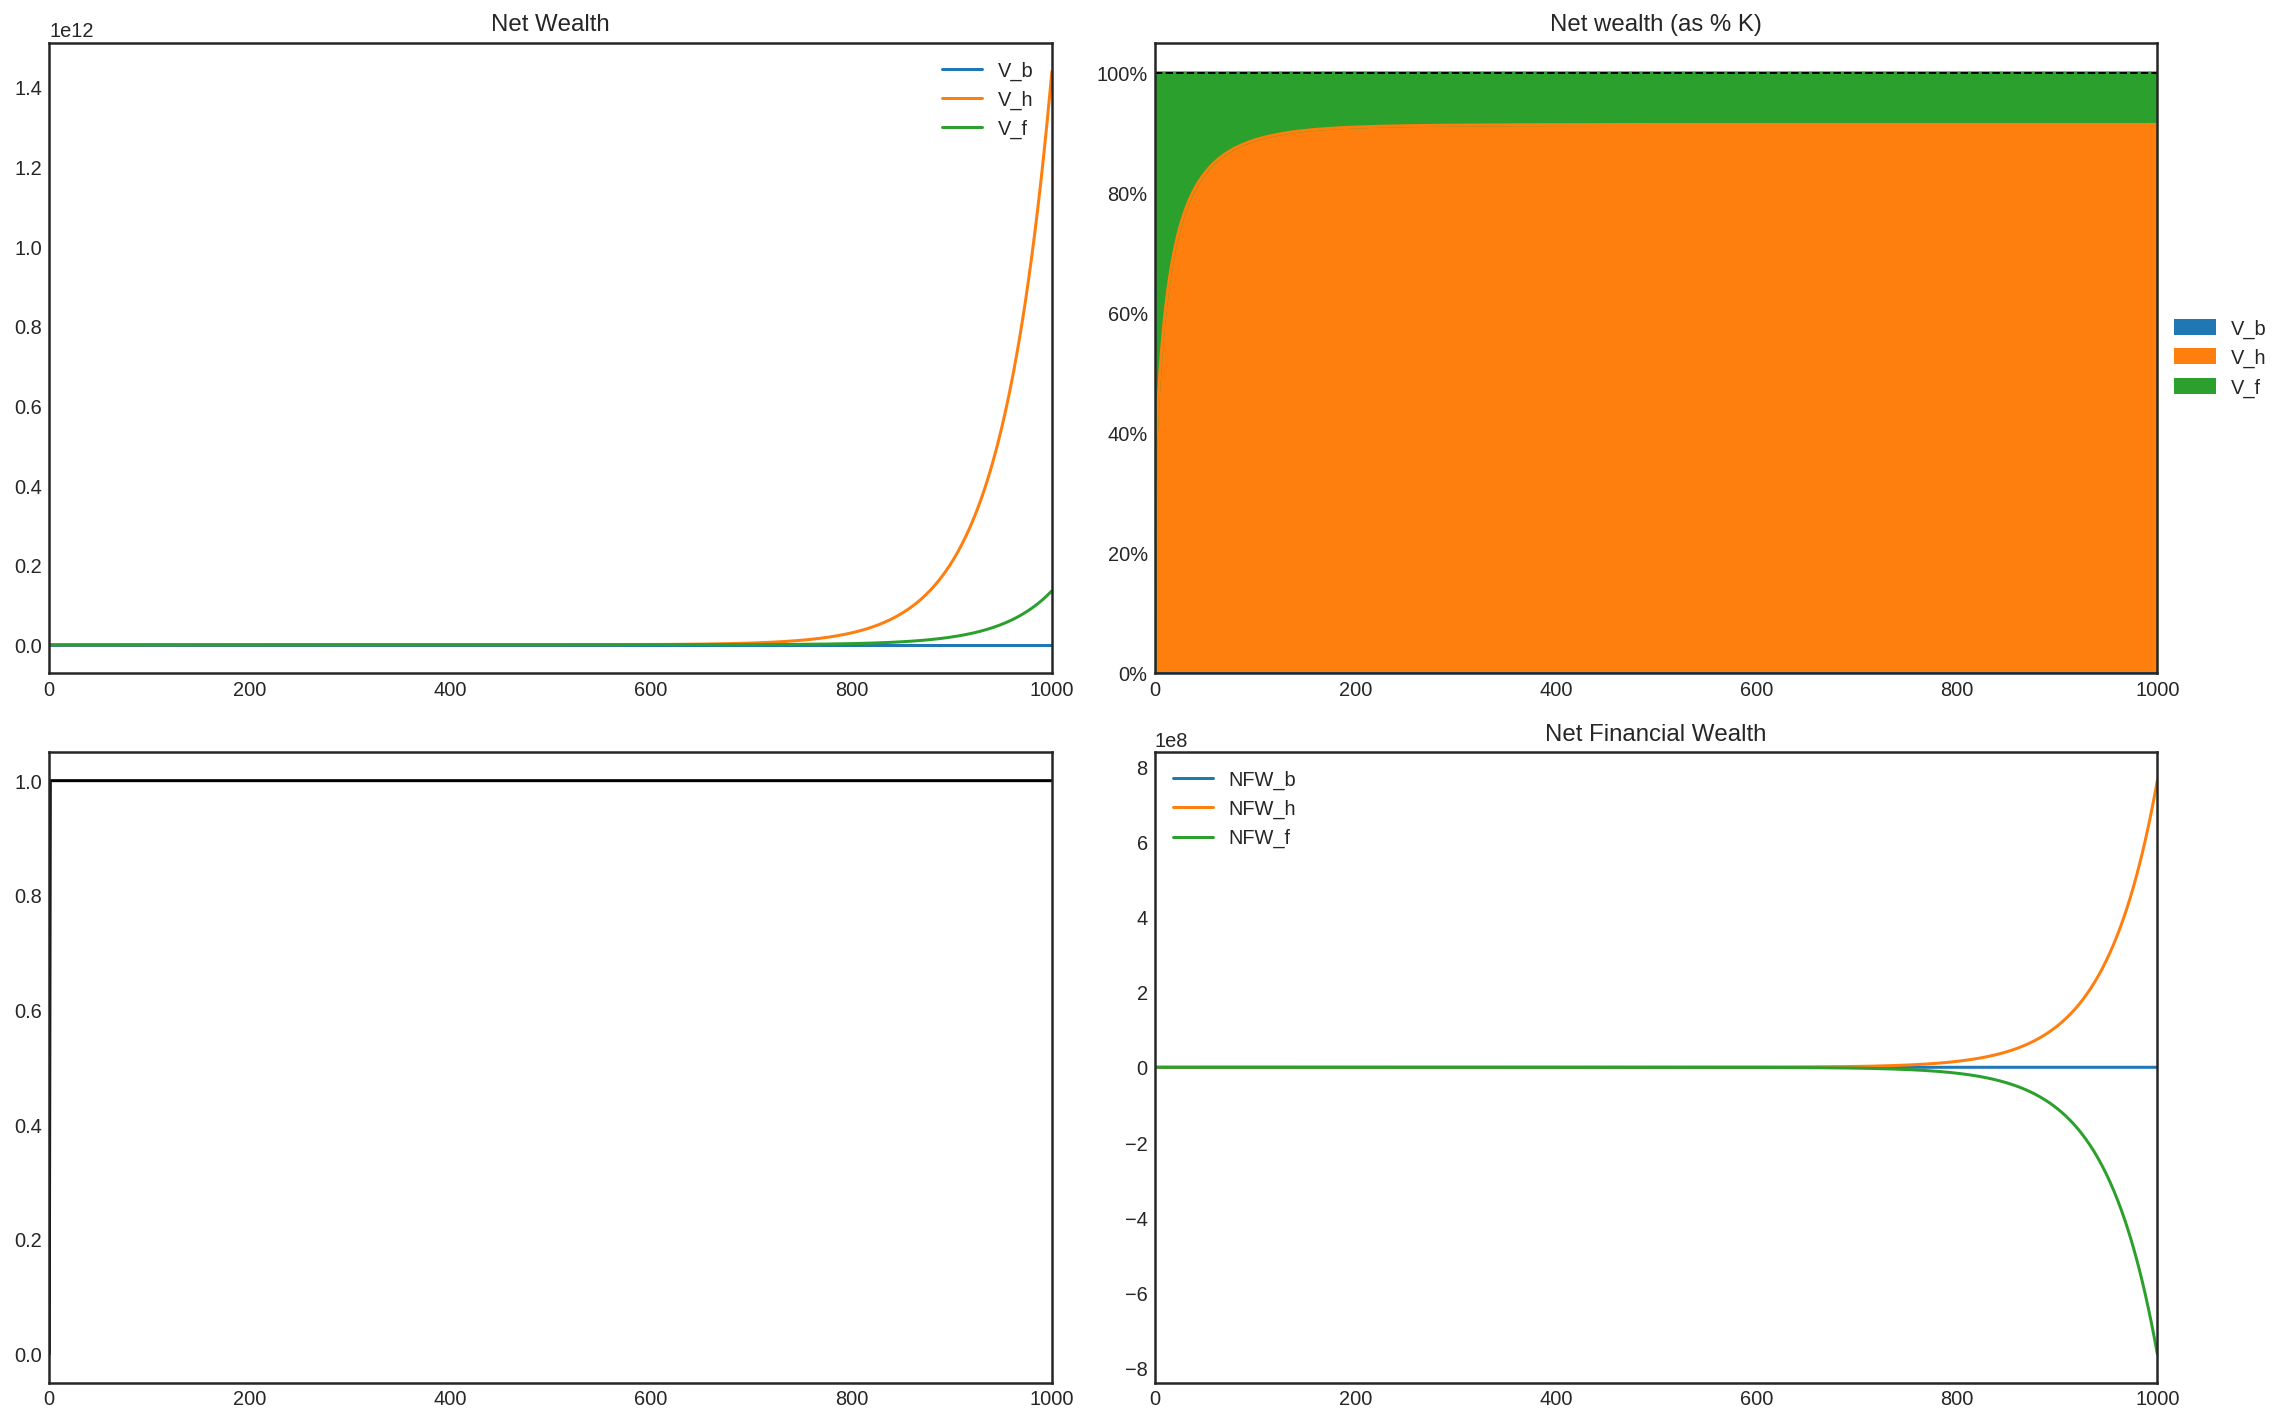

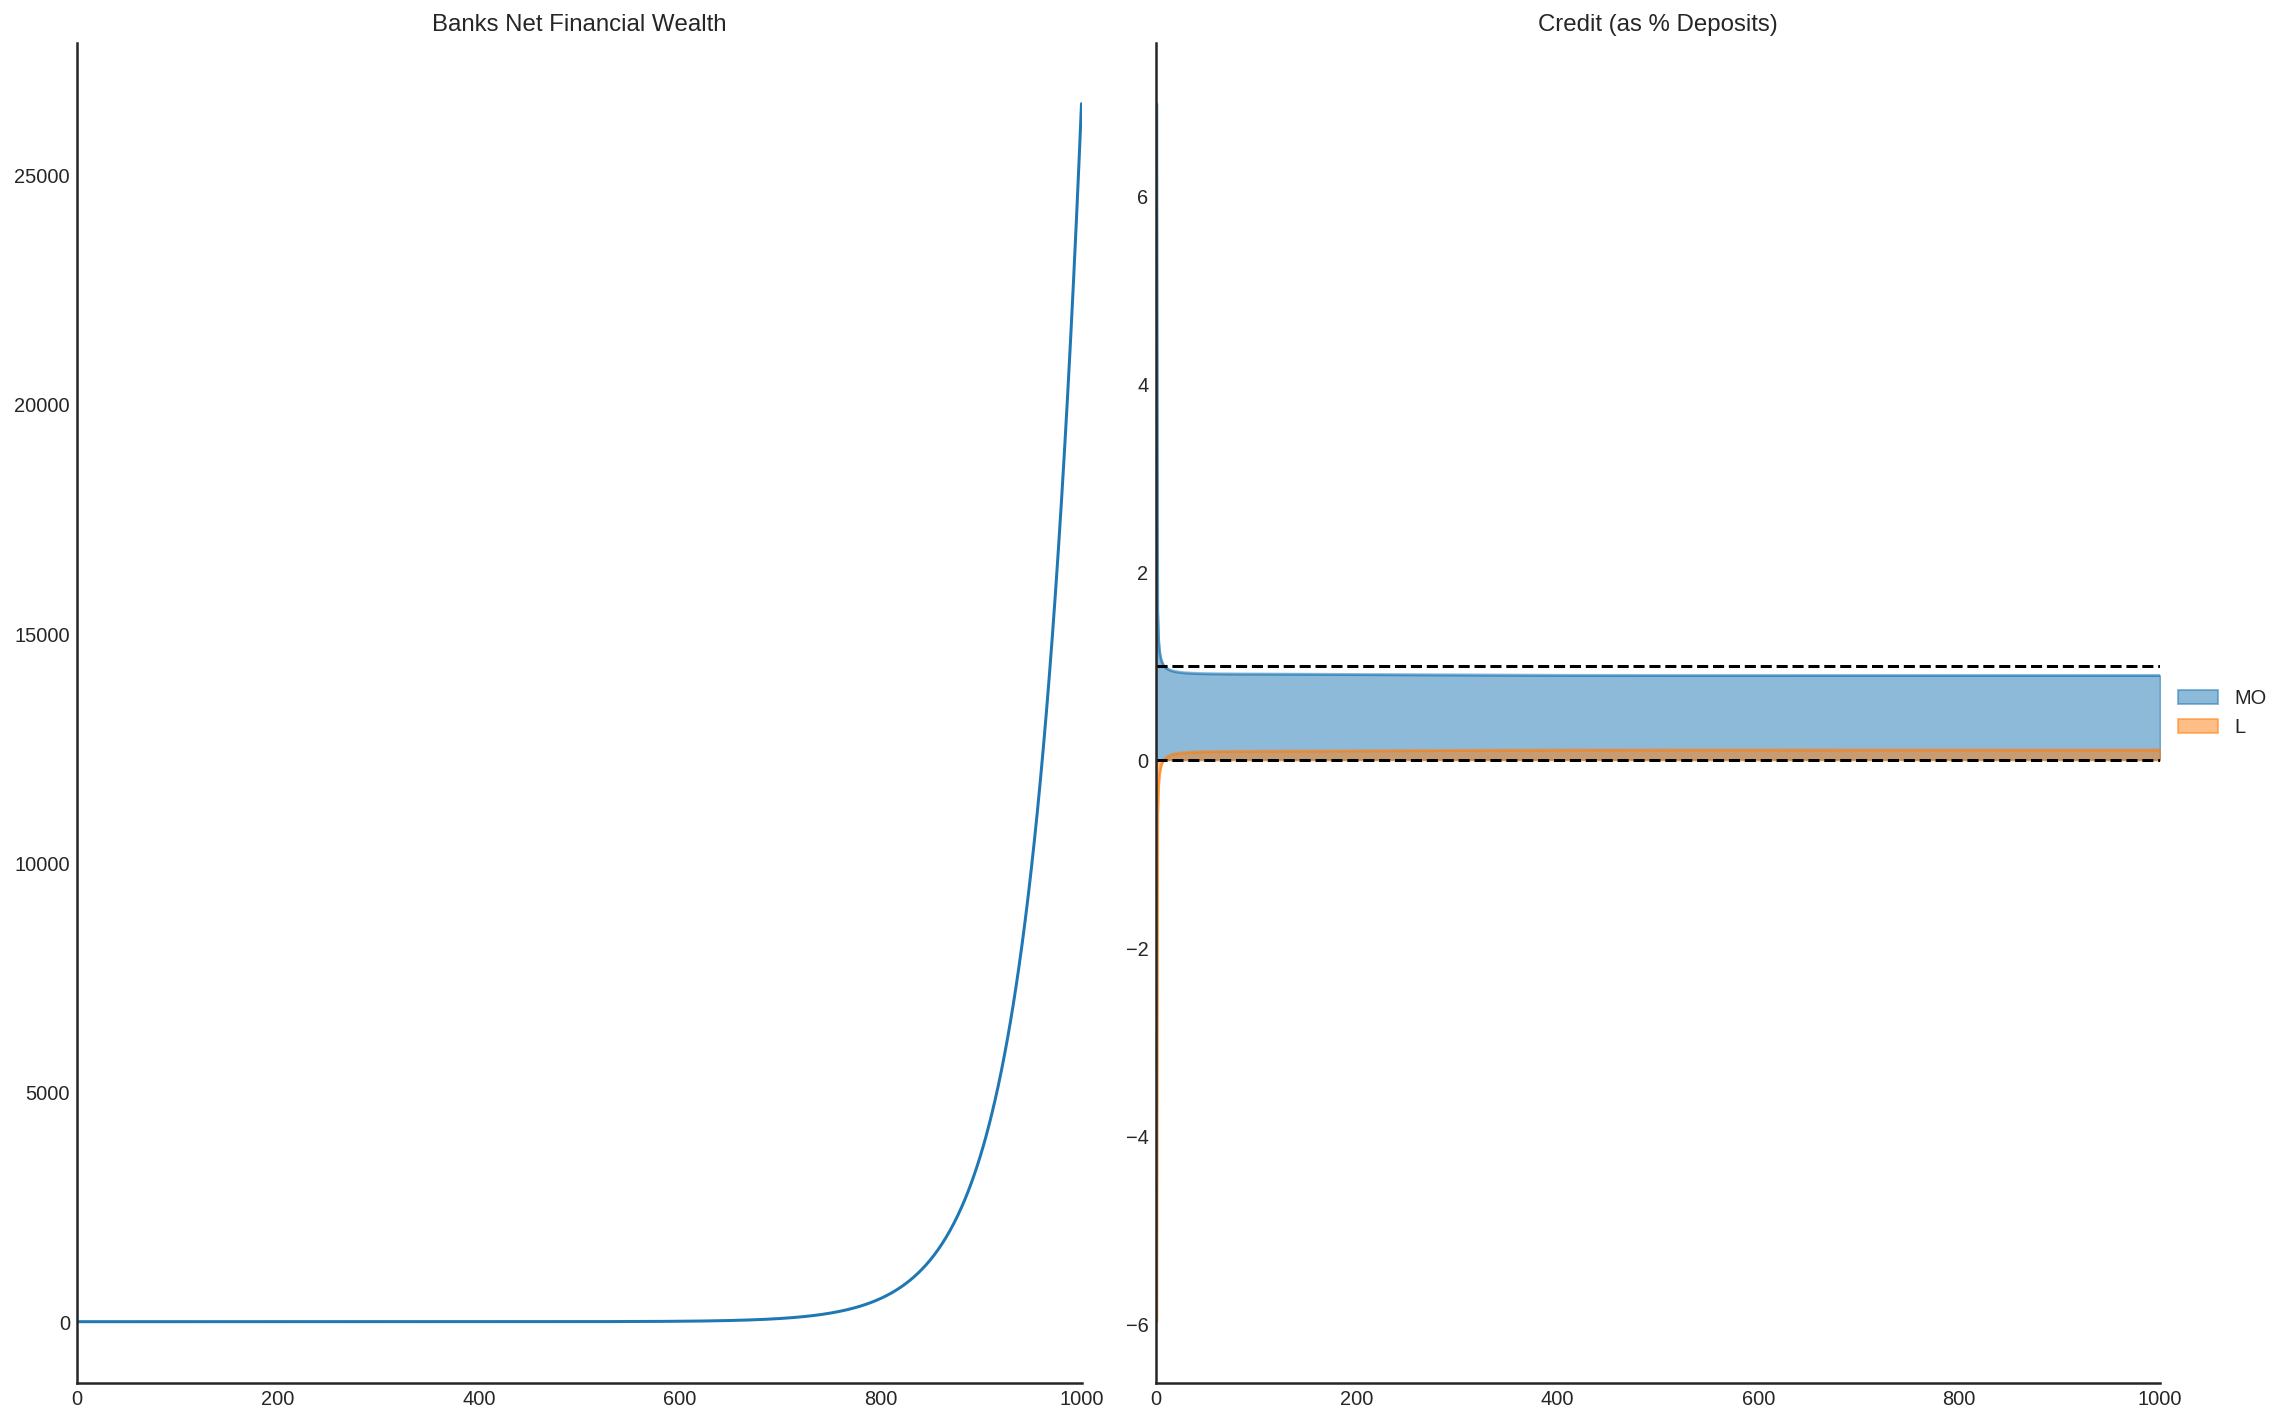

0           1           2           3           4           5     \
C       0.000000   93.248578   95.050184   96.887072   98.759881  100.669359   
Cw    112.000000   83.052606   84.654348   86.287478   87.952535   89.650186   
Ck     68.000000   10.196000   10.395842   10.599600   10.807352   11.019176   
Eq      0.000000  100.000000  101.242289  102.505025  103.788596  105.093398   
FD      0.000000  114.612596  118.617800  120.851822  123.130021  125.453321   
...          ...         ...         ...         ...         ...         ...   
TIME    1.000000    2.000000    3.000000    4.000000    5.000000    6.000000   
Ih/Y    0.357143    0.491062    0.491214    0.491362    0.491508    0.491652   
I/Y     0.357143    0.550894    0.550879    0.550864    0.550850    0.550835   
Z/Y     0.000000    0.540168    0.540335    0.540498    0.540659    0.540817   
gY           NaN   -0.258459    0.019286    0.019292    0.019297    0.019302   

            6           7           8           9     ...          991   \
C     102.616146  104.601018  106.624724  108.688029  ...  2.071029e+10   
Cw     91.380997   93.145660   94.944841   96.779221  ...  1.845107e+10   
Ck     11.235152   11.455361   11.679886   11.908812  ...  2.259219e+09   
Eq    106.419836  107.768322  109.139278  110.533134  ...  1.441382e+10   
FD    127.822510  130.238546  132.702354  135.214877  ...  2.512114e+10   
...          ...         ...         ...         ...  ...           ...   
TIME    7.000000    8.000000    9.000000   10.000000  ...  9.920000e+02   
Ih/Y    0.491794    0.491933    0.492070    0.492205  ...  4.897752e-01   
I/Y     0.550821    0.550807    0.550793    0.550780  ...  5.510225e-01   
Z/Y     0.540973    0.541127    0.541277    0.541426  ...  5.387528e-01   
gY      0.019306    0.019311    0.019316    0.019320  ...  1.960007e-02   

              992           993           994           995           996   \
C     2.111621e+10  2.153009e+10  2.195208e+10  2.238234e+10  2.282104e+10   
Cw    1.881271e+10  1.918144e+10  1.955740e+10  1.994072e+10  2.033156e+10   
Ck    2.303500e+09  2.348648e+09  2.394682e+09  2.441618e+09  2.489473e+09   
Eq    1.469634e+10  1.498440e+10  1.527810e+10  1.557756e+10  1.588289e+10   
FD    2.561352e+10  2.611554e+10  2.662741e+10  2.714931e+10  2.768143e+10   
...            ...           ...           ...           ...           ...   
TIME  9.930000e+02  9.940000e+02  9.950000e+02  9.960000e+02  9.970000e+02   
Ih/Y  4.897752e-01  4.897752e-01  4.897752e-01  4.897751e-01  4.897751e-01   
I/Y   5.510225e-01  5.510225e-01  5.510225e-01  5.510225e-01  5.510225e-01   
Z/Y   5.387527e-01  5.387527e-01  5.387527e-01  5.387526e-01  5.387526e-01   
gY    1.960007e-02  1.960007e-02  1.960007e-02  1.960007e-02  1.960007e-02   

              997           998           999           1000  
C     2.326833e+10  2.372439e+10  2.418939e+10  2.466350e+10  
Cw    2.073006e+10  2.113637e+10  2.155065e+10  2.197304e+10  
Ck    2.538267e+09  2.588017e+09  2.638742e+09  2.690462e+09  
Eq    1.619420e+10  1.651162e+10  1.683526e+10  1.716524e+10  
FD    2.822399e+10  2.877718e+10  2.934121e+10  2.991630e+10  
...            ...           ...           ...           ...  
TIME  9.980000e+02  9.990000e+02  1.000000e+03  1.001000e+03  
Ih/Y  4.897751e-01  4.897750e-01  4.897750e-01  4.897750e-01  
I/Y   5.510225e-01  5.510225e-01  5.510225e-01  5.510225e-01  
Z/Y   5.387526e-01  5.387525e-01  5.387525e-01  5.387525e-01  
gY    1.960007e-02  1.960007e-02  1.960007e-02  1.960006e-02  

[84 rows x 1001 columns]

In [8]:
base = model()
df = SolveSFC(base, time=1000)

fig, ax = plt.subplots(1,3, figsize=(24,5))

df["TIME"] = [i+1 for i in range(len(df.index))]
df["Ih/Y"] = df["I_h"]/df["Y"]
df["I/Y"] = df["I_t"]/df["Y"]
df["Z/Y"] = df["Z"]/df["Y"]
df["gY"] = df["Y"].pct_change()

sns.scatterplot(y = 'Ih/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[0])
sns.lineplot(y = 'Ih/Y', x='u', data=df, sort=False, color = 'black', ax=ax[0])

sns.scatterplot(y = 'Z/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[1])
sns.lineplot(y = 'Z/Y', x='u', data=df, sort=False, color = 'black', ax=ax[1])

sns.scatterplot(y = 'I/Y', x='gY', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[2])
sns.lineplot(y = 'I/Y', x='gY', data=df, sort=False, color = 'black', ax=ax[2])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(16,10))

df[['Lf', "M_h", "MO", "Lk"]][:100].plot(ax=ax[0,0], title='Ativos Financeiros')

df[['FT', "FU", "FD", "Fn"]][:100].plot(title='Lucros', ax=ax[0,1])

df['h'].plot(color = "black", ls="-",  title = "Marginal propensity to invest", label = "$h_t$", legend = True,ax=ax[1,0])

df[["Y", "K", "I_h", "I_f"]][40:].pct_change().plot(title = "Growth rates",ax=ax[1,1])
ax[1,1].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,1].get_yticks()])
ax[1,1].axhline(y=df["g_Z"].iloc[-1], color = "black", ls = "--", lw=1)
ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()


fig, ax = plt.subplots(2,2, figsize=(16,10))


df[["K"]].pct_change().plot(ax=ax[0,0], color='black', title='Capital growth rate')

df['Y'].pct_change().plot(color = "black", title = "GDP growth rate", label = "$Y_t$", legend = True, ax=ax[0,1])
ax[0,1].axhline(y=df["g_Z"].iloc[-1], color = "red", ls = "--", lw=1, label = "Autonomous growth rate")
ax[0,1].set_yticklabels(['{:,.2%}'.format(x) for x in ax[0,1].get_yticks()])

df['K_k'].plot(color = "black", title = "Housing as % of total capital", label = "$k$", legend = True, ax=ax[1,0])
ax[1,0].set_yticklabels(['{:,.0%}'.format(x) for x in ax[1,0].get_yticks()])

df['un'].plot(color = "red", ls="--",  title = "Capacity utilization ratio", label = "$un$", legend = True,ax=ax[1,1])
df['u'].plot(color = "black", title = "Capacity utilization ratio", label = "$u_t$", legend = True, ax=ax[1,1])
#ax[1,1].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,1].get_yticks()])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(16,10))

df[["V_b", "V_h", "V_f"]].plot(title = "Net Wealth", ax=ax[0,0])

df[['V_b', 'V_h', 'V_f']].apply(lambda x: np.abs(x)/df['K']).plot(kind = 'area', stacked = True, title = "Net wealth (as % K)", ax=ax[0,1])
ax[0,1].set_yticklabels(['{:,.0%}'.format(x) for x in ax[0,1].get_yticks()])
ax[0,1].axhline(y=1, color = "black", ls = "--", lw=1)
ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

((df['V_b'] + df['V_f'] + df['V_h'])/df['K']).plot(label='Consistensy check', color='black', ax=ax[1,0])
ax[1,0].axhline(y=1, color = "black", ls = "--", lw=1)

df[["NFW_b", "NFW_h", "NFW_f"]].plot(title = "Net Financial Wealth", ax=ax[1,1])

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16,10))

df['NFW_b'].plot(title = "Banks Net Financial Wealth", ax=ax[0])
df[["MO", "L"]].apply(lambda x: x/df["M"]).plot(kind = "area",stacked = False ,title = "Credit (as % Deposits)", ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].axhline(y = 1, color = "black", ls = "--")
ax[1].axhline(y = 0, color = "black", ls = "--")

sns.despine()
plt.tight_layout()
plt.show()

df.transpose()

# Shocks

In [9]:
def clock_plots(shock, filename, variable):
    shock["TIME"] = [i+1 for i in range(len(shock.index))]
    shock["Ih/Y"] = shock["I_h"]/shock["Y"]
    shock["I/Y"] = shock["I_t"]/shock["Y"]
    shock["Z/Y"] = shock["Z"]/shock["Y"]
    shock["gY"] = shock["Y"].pct_change()
    
    sns.set_context('talk')
    fig, ax = plt.subplots(1,3,figsize=(24,4)
                          )
    
    sns.scatterplot(y = 'Ih/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[0])
    sns.lineplot(y = 'Ih/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[0])
    
    sns.scatterplot(y = 'Z/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[1])
    sns.lineplot(y = 'Z/Y', x='u', data=shock, sort=False, color = 'black', ax=ax[1])
    
    sns.scatterplot(y = 'I/Y', x='gY', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False, ax=ax[2])
    sns.lineplot(y = 'I/Y', x='gY', data=shock, sort=False, color = 'black', ax=ax[1])
    
    
    sns.despine()
    plt.show()
    
    fig.savefig(filename, dpi = 300)

In [10]:
def plot_shock(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    shock[["Y"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('--'), lw=3,
                                                      )
    shock[["K"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = (':'), lw=3
                                                      )
    shock[["I_h"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-'), lw=3,
                                                      )
    shock[["I_f"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-.'), lw=3,
                                                      )
    ax[0,0].axhline(y=shock["g_Z"].iloc[-1], color = "black", ls = "--", lw=2.5)
    #ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
                   labels = ["$Y$", "$K$", "$I_h$", "$I_f$"],
              fancybox=True, shadow=True, ncol=2)
    ax[0,0].ticklabel_format(useOffset=False)

    ((shock["Z"]/shock['Y'])).plot(title = "Autonomous expenditure to income", ax = ax[0,1], ls = ('-'), lw=3, color='darkred')
    
    ax[0,1].set_ylim(auto=True)
    ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels=['$Z/Y$'],
              fancybox=True, shadow=True, ncol=2)

    shock['u'].plot(title = 'Capacity utilization ratio', ax=ax[1,0], legend = False, color = "darkred", lw = 3, )
    ax[1,0].axhline(y = shock['un'].iloc[-1], ls ='--', color = "gray")
    #ax[1,0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].ticklabel_format(useOffset=False)

    shock['h'].plot(title = 'Marginal propensity to invest', ax=ax[1,1], legend = False, color = "darkred", lw = 3, )
    ax[1,1].axhline(y = df['h'].iloc[-1], ls ='--', color = "gray")
    ax[1,1].ticklabel_format(useOffset=False)
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

In [11]:
def plot_norms(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('talk')
    fig, ax = plt.subplots(2,2, figsize=(16,10))

    ((shock["YDk"]/shock['V_h'])**(1)).plot(title = "Flow/Stock", ax = ax[0,0], ls = (':'), lw=3)
    ((shock["YDk"]/shock['V_hr'])**(1)).plot(title = "Flow/Stock", ax = ax[0,0], ls = ('-'), lw=3)
    ((shock["FU"]/shock['V_f'])**(1)).plot(ax = ax[0,0], ls = ('-'), lw=3)
    
    ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$V_h/YDk$",
                       "$V_hr/YD$",
                       "$V_f/FU$",
                            ],
              fancybox=True, shadow=True, ncol=2)
    #ax[0,0].ticklabel_format(useOffset=False)
    
    shock['K_k'].plot(color = "darkred", title = "Houses \nas % of Total capital", label = "$\k$", legend = False, ax = ax[0,1], lw = 3, )
    ax[0,1].axhline(y = df['K_k'].iloc[-1], ls ='--', color = "gray")
    ax[0,1].ticklabel_format(useOffset=False)
    
    (shock["MO"]*shock["rmo"][1:]/shock['YDk'][1:]).plot(title="Mortgage payment share", ax = ax[1,0], ls = ('-'), lw=3)
    ax[1,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   labels = [
                       '$MO_{-1}\cdot rmo/YD$',
                            ],
              fancybox=True, shadow=True, ncol=2)
    
    shock[['I_f', 'I_h']].apply(lambda x: x/shock['I_t']).plot(kind = 'area', stacked = True, legend = True, title = "Residential and Non-residential Investiment (as % of total investment)", ax=ax[1,1])
    ax[1,1].axhline(y=1, color = "black", ls = "--", lw=1)
    ax[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
                   labels = [
                       "$I_f$",
                       "$I_h$"
                            ],
              fancybox=True, shadow=True, ncol=2)

    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

In [12]:
def other_plots(shock):

    (shock['MO']/(shock['M'])).plot(title="Mortgage as % of deposits")
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['FT']/shock['K_f']).plot(ax=ax, label='Gross profit rate')
    (shock['Fn']/shock['K_f']).plot(ax=ax, label='Net profit rate')
    ax.legend()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots()
    (shock['YDk']/shock['K_HD']).plot(ax=ax, label='Real', title="Disposible income as % of Housing")
    (shock['YDk']/(shock['K_HD']*shock['ph'])).plot(ax=ax, label='Nominal')
    ax.legend()
    sns.despine()
    plt.show()

## Increase in autonomous growth rate ($g_z$)

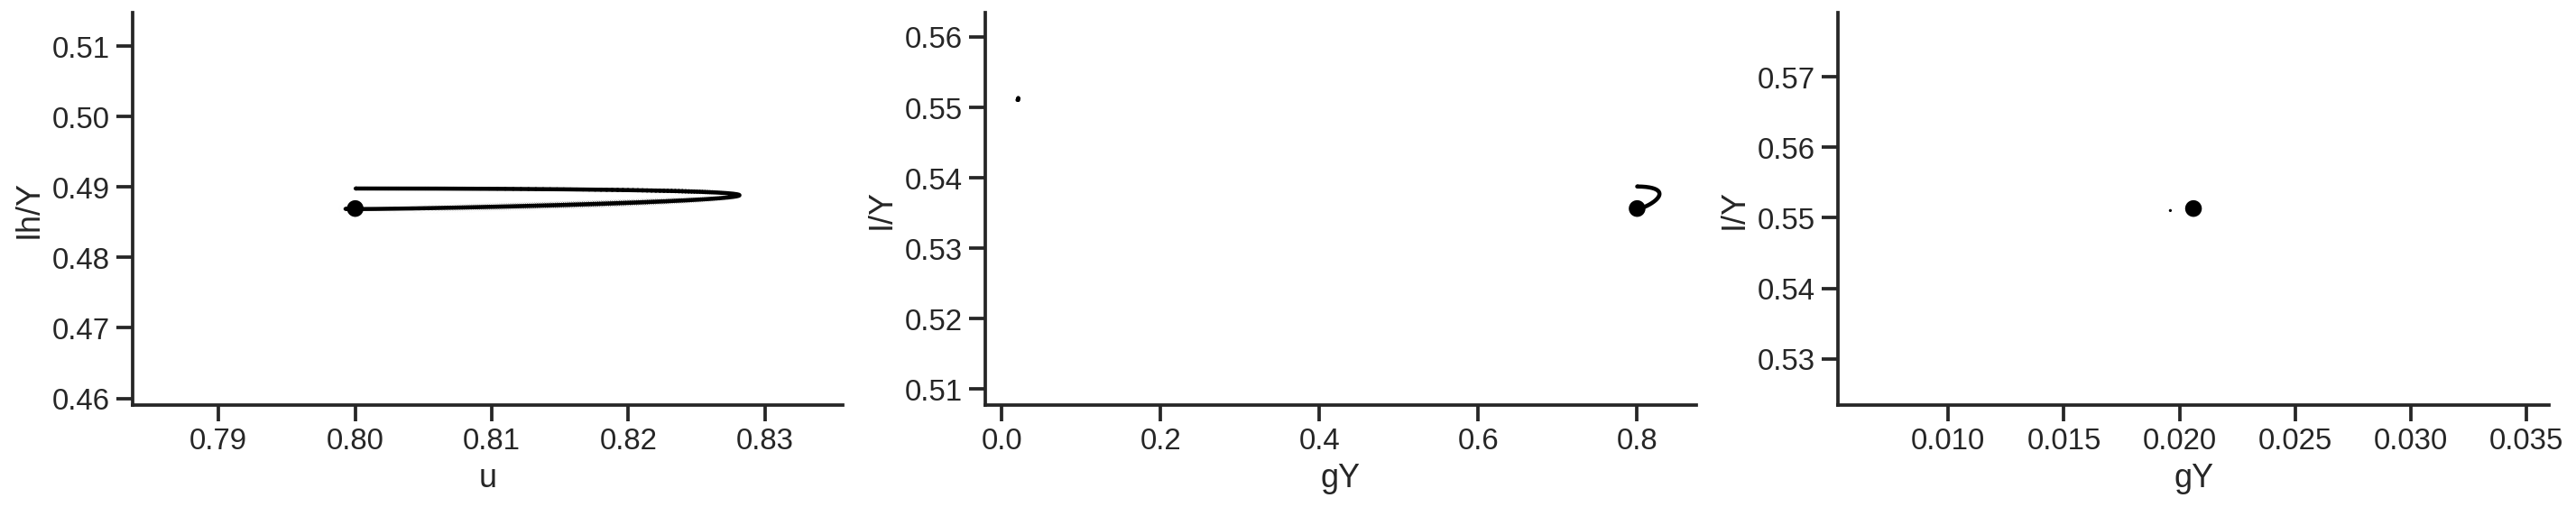

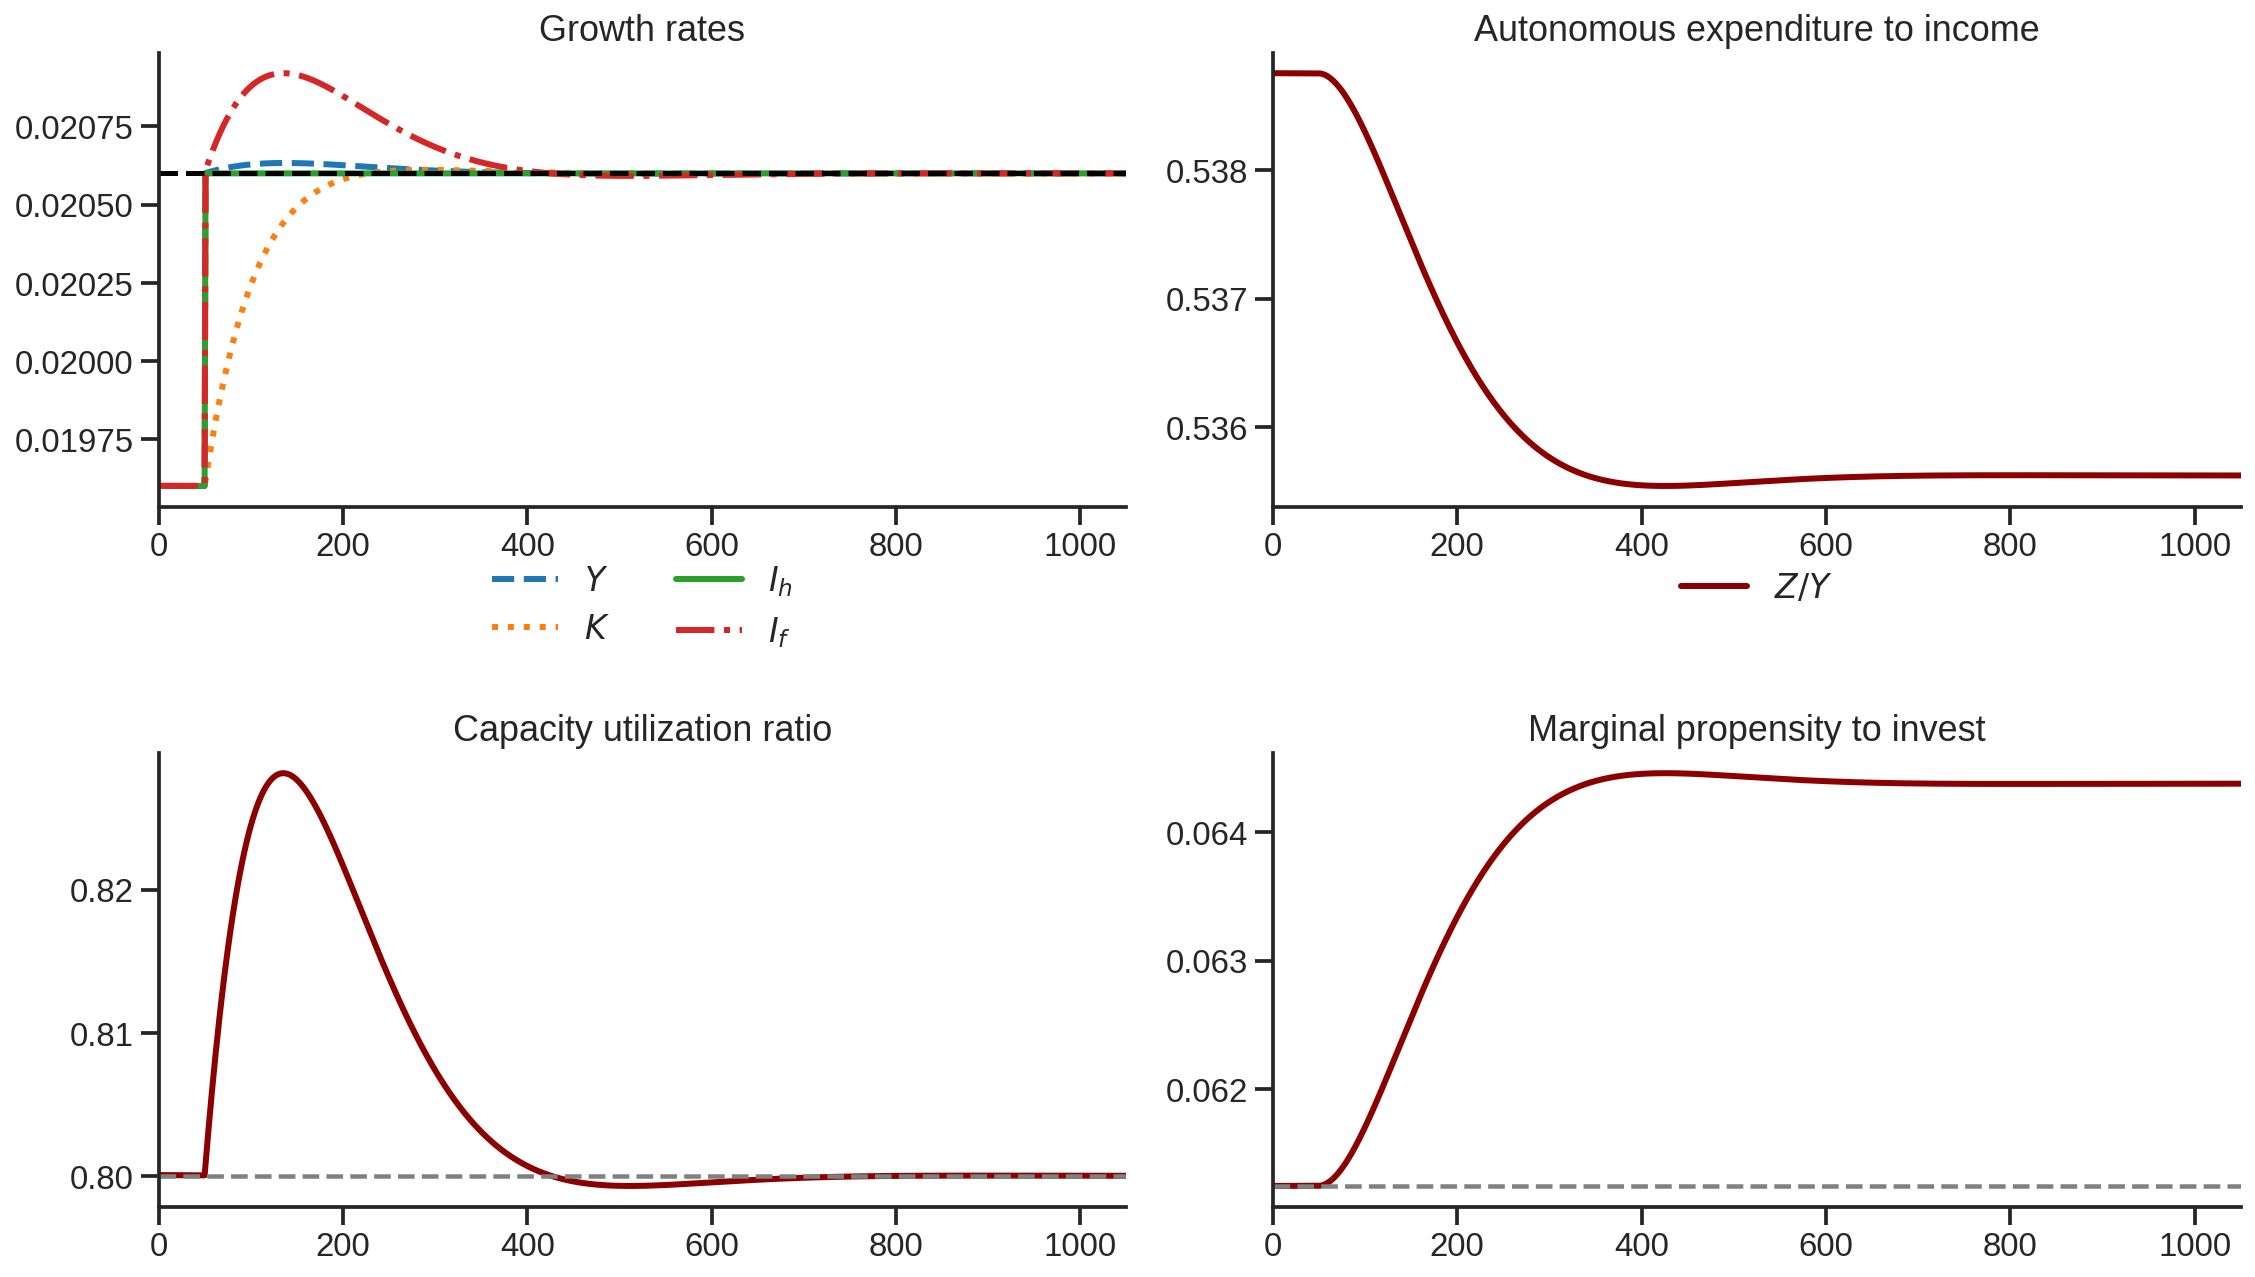

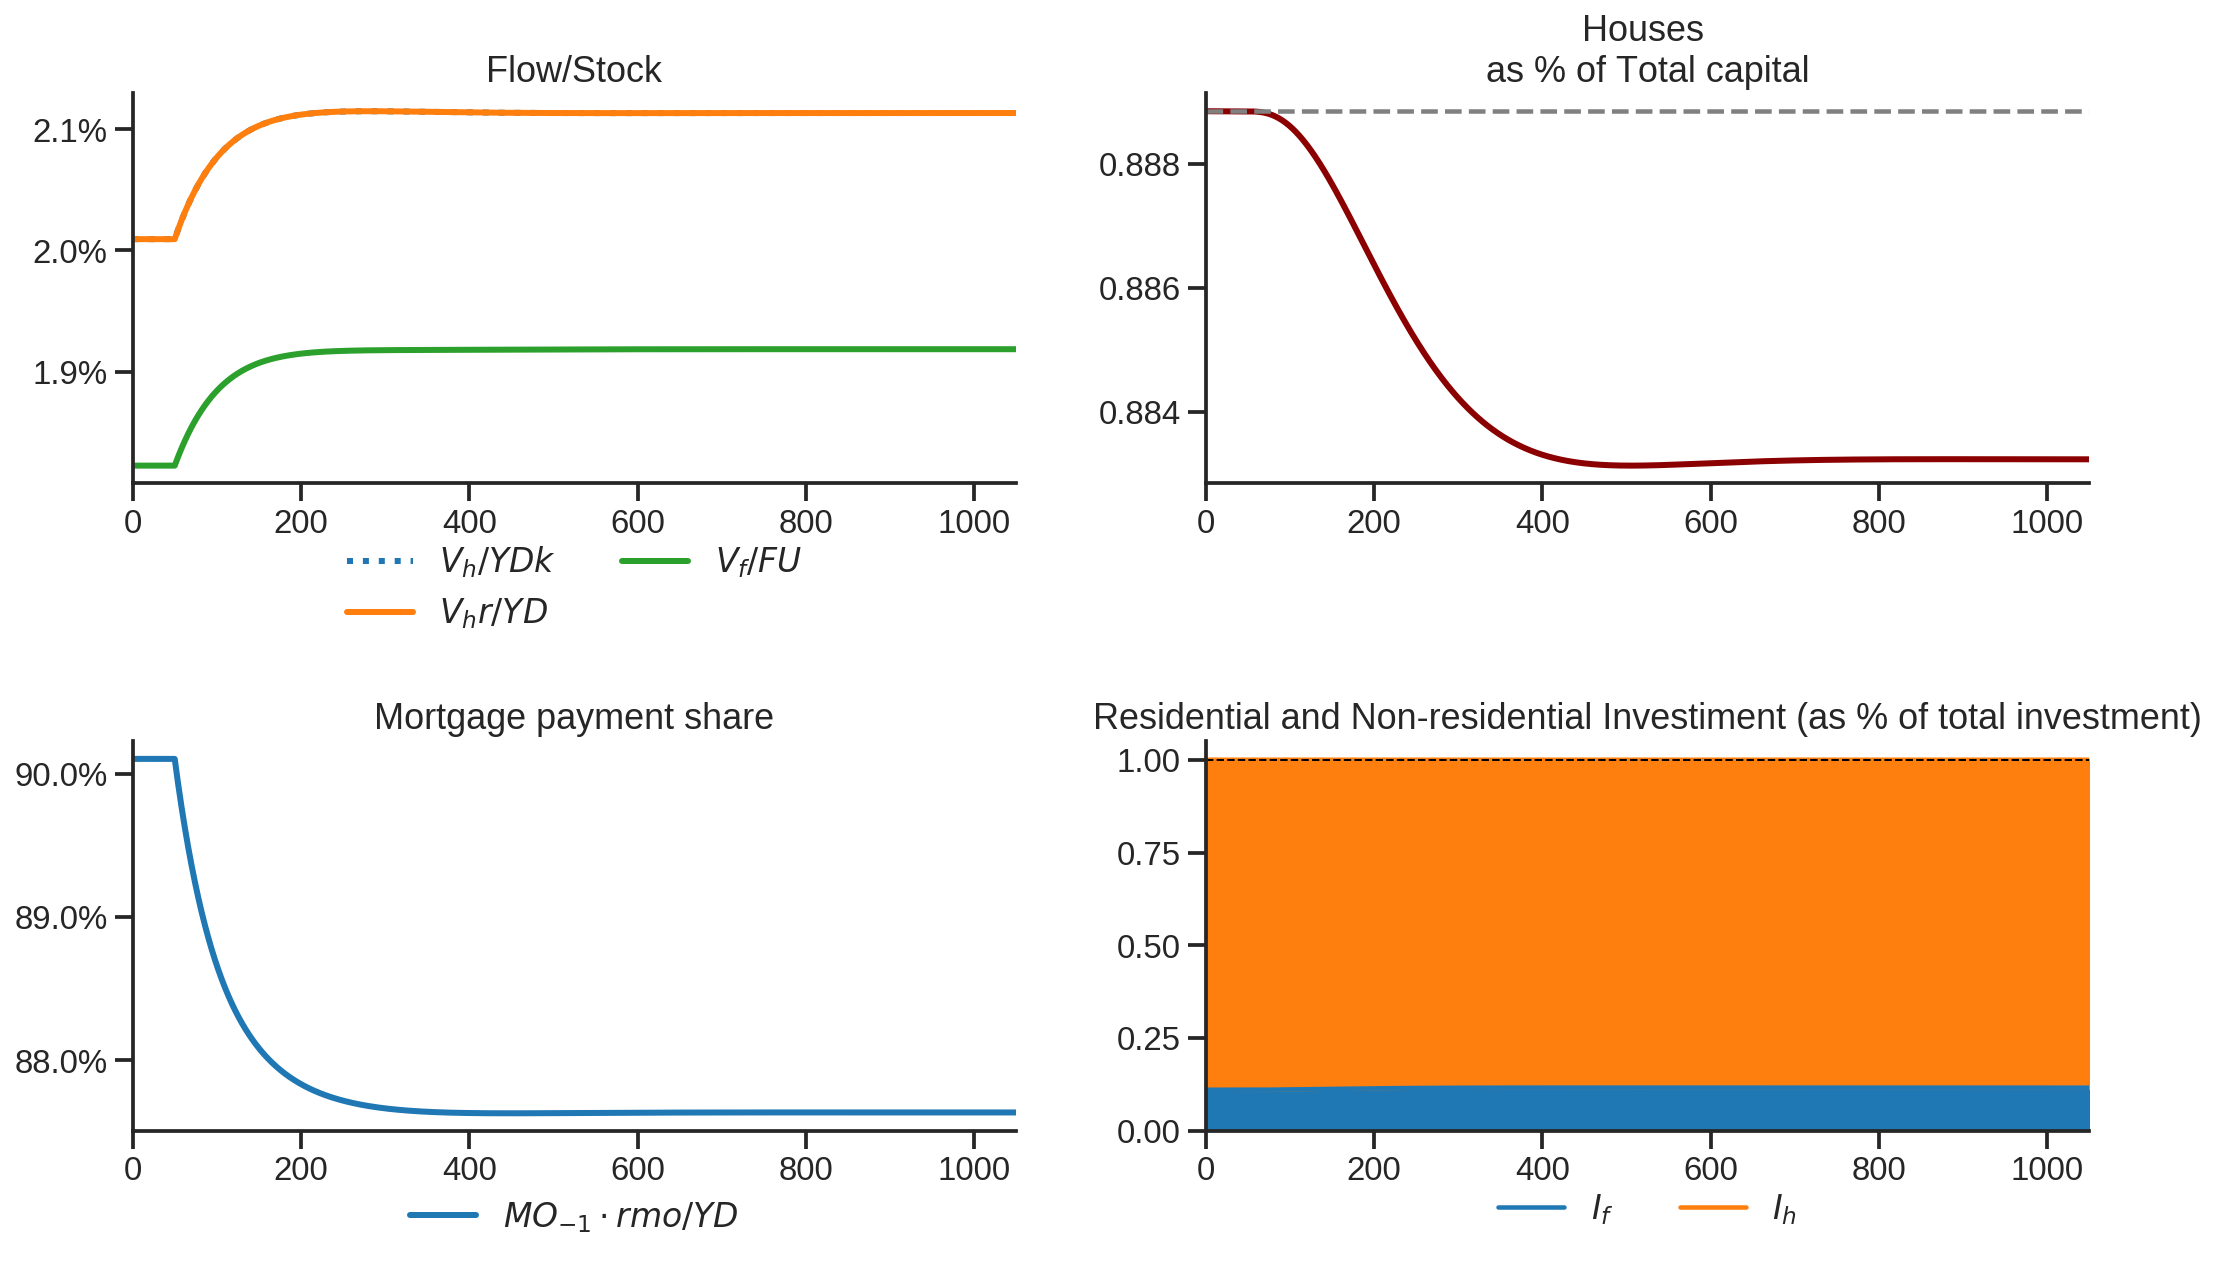

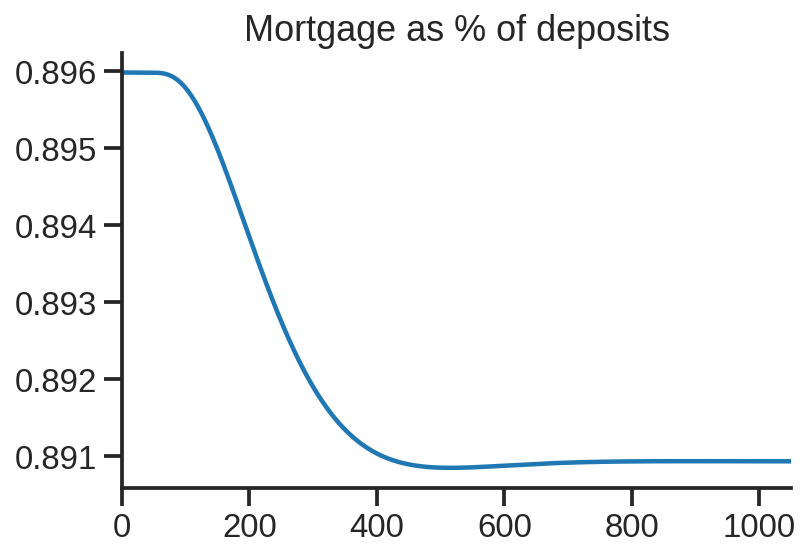

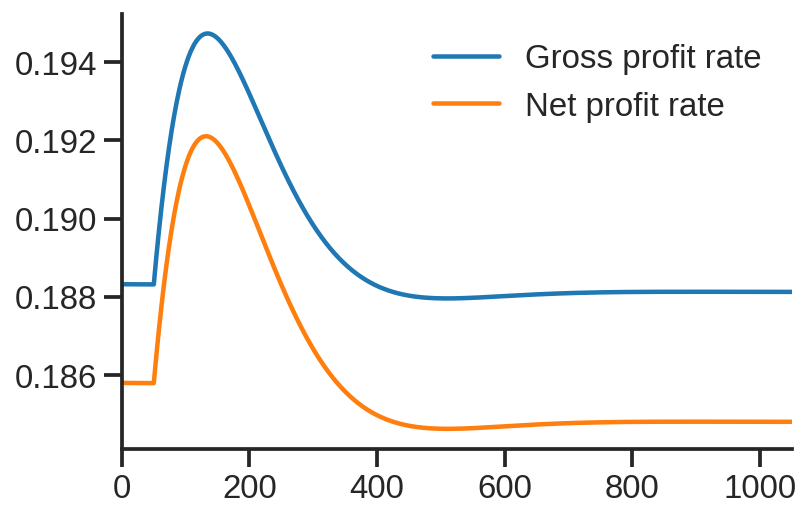

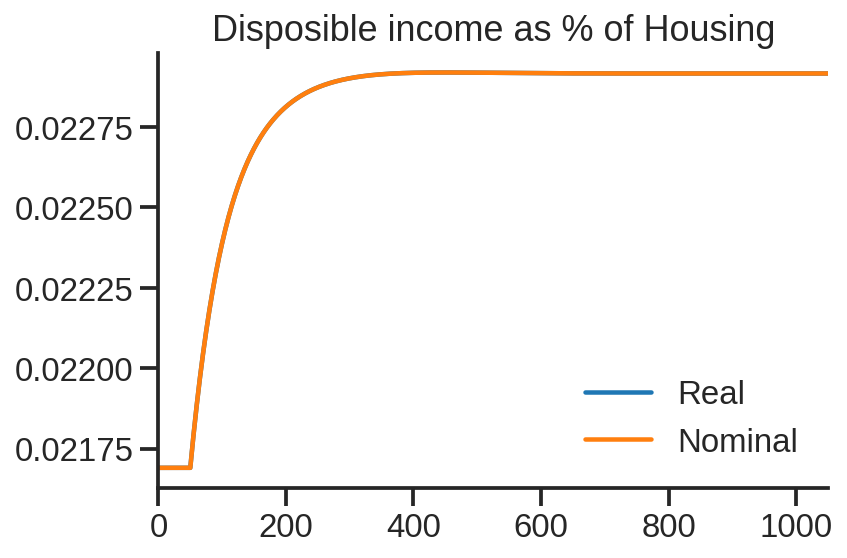

0         Shock             1             2             3  \
C     6.509493e+10  6.643594e+10  6.780463e+10  6.920157e+10  7.062734e+10   
Cw    5.799395e+10  5.918868e+10  6.040807e+10  6.165265e+10  6.292291e+10   
Ck    7.100978e+09  7.247258e+09  7.396551e+09  7.548920e+09  7.704428e+09   
Eq    4.530576e+10  4.619377e+10  4.710009e+10  4.802510e+10  4.896918e+10   
FD    7.895858e+10  8.058627e+10  8.224755e+10  8.394313e+10  8.567372e+10   
...            ...           ...           ...           ...           ...   
TIME  5.100000e+01  5.200000e+01  5.300000e+01  5.400000e+01  5.500000e+01   
Ih/Y  4.897737e-01  4.897732e-01  4.897724e-01  4.897710e-01  4.897693e-01   
I/Y   5.510226e-01  5.510227e-01  5.510228e-01  5.510229e-01  5.510231e-01   
Z/Y   5.387511e-01  5.387506e-01  5.387496e-01  5.387481e-01  5.387463e-01   
gY    1.960004e-02  2.060095e-02  2.060185e-02  2.060273e-02  2.060359e-02   

               t-1             t    difference  
C     4.597352e+19  4.692058e+19  9.470549e+17  
Cw    4.098437e+19  4.182865e+19  8.442784e+17  
Ck    4.989150e+18  5.091927e+18  1.027765e+17  
Eq    3.201883e+19  3.267842e+19  6.595911e+17  
FD    5.555953e+19  5.670406e+19  1.144526e+18  
...            ...           ...           ...  
TIME  1.050000e+03  1.051000e+03  1.000000e+00  
Ih/Y  4.869319e-01  4.869319e-01 -3.038376e-09  
I/Y   5.513068e-01  5.513068e-01  3.038376e-10  
Z/Y   5.356251e-01  5.356251e-01 -3.342213e-09  
gY    2.060001e-02  2.060001e-02 -8.863421e-11  

[84 rows x 8 columns]

In [13]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='phi_0', increase=0.001, time = 1000)
clock_plots(shock = shock, filename = 'Clock_1.png', variable='g_Z')
plot_shock(shock = shock, filename = 'Shock_1.png')
plot_norms(shock = shock, filename = 'Shock_1Norms.png')
other_plots(shock)

shock1 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock1.columns = ['$\Delta \phi_0$']

summary = SummaryShock(shock)
summary

## Decrease in wage-share ($\omega$)

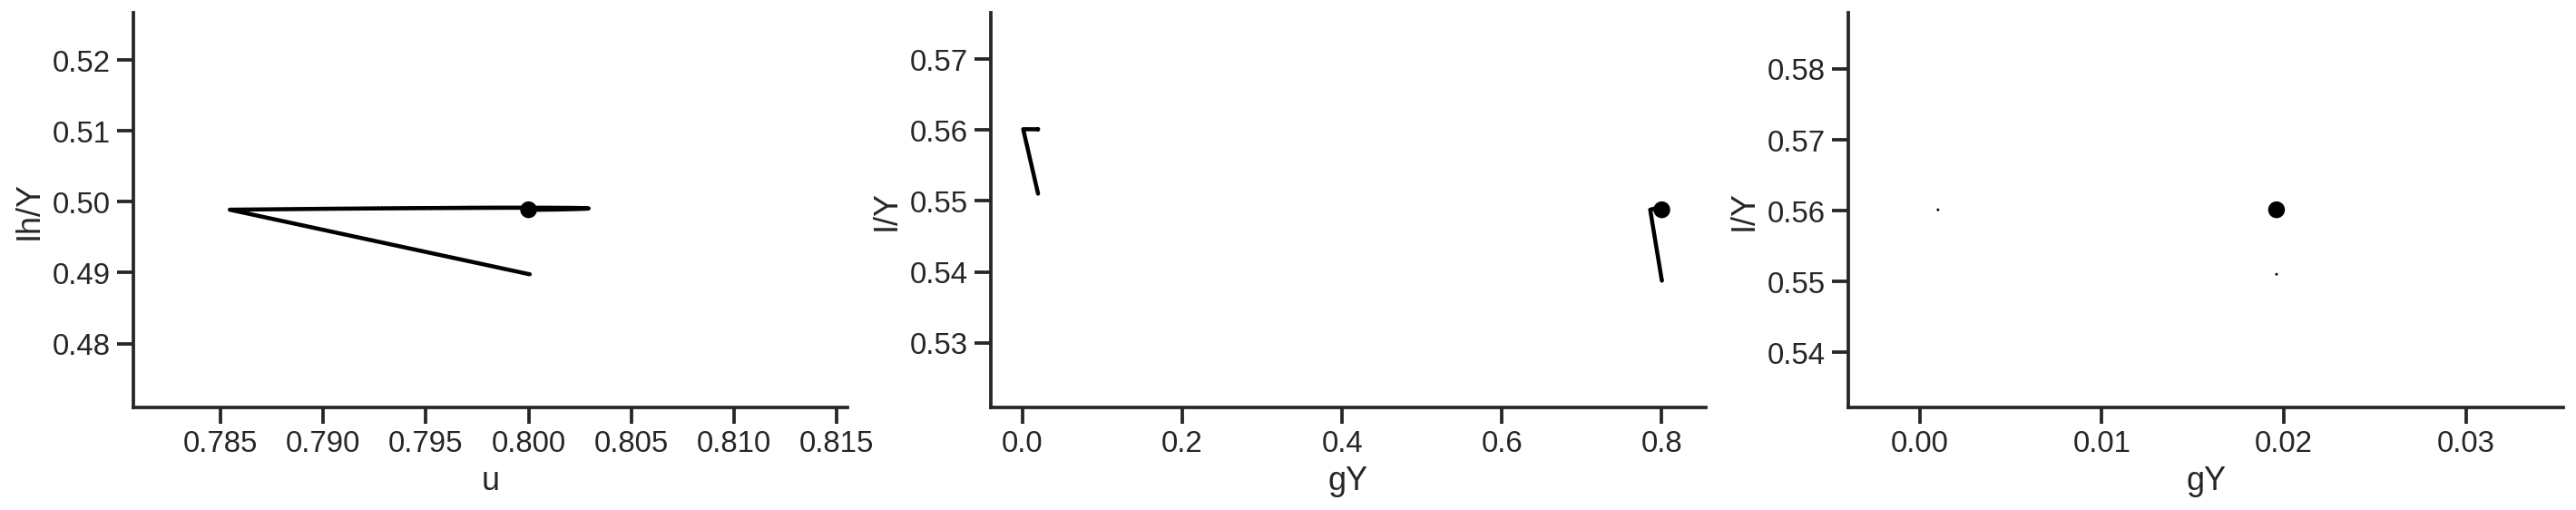

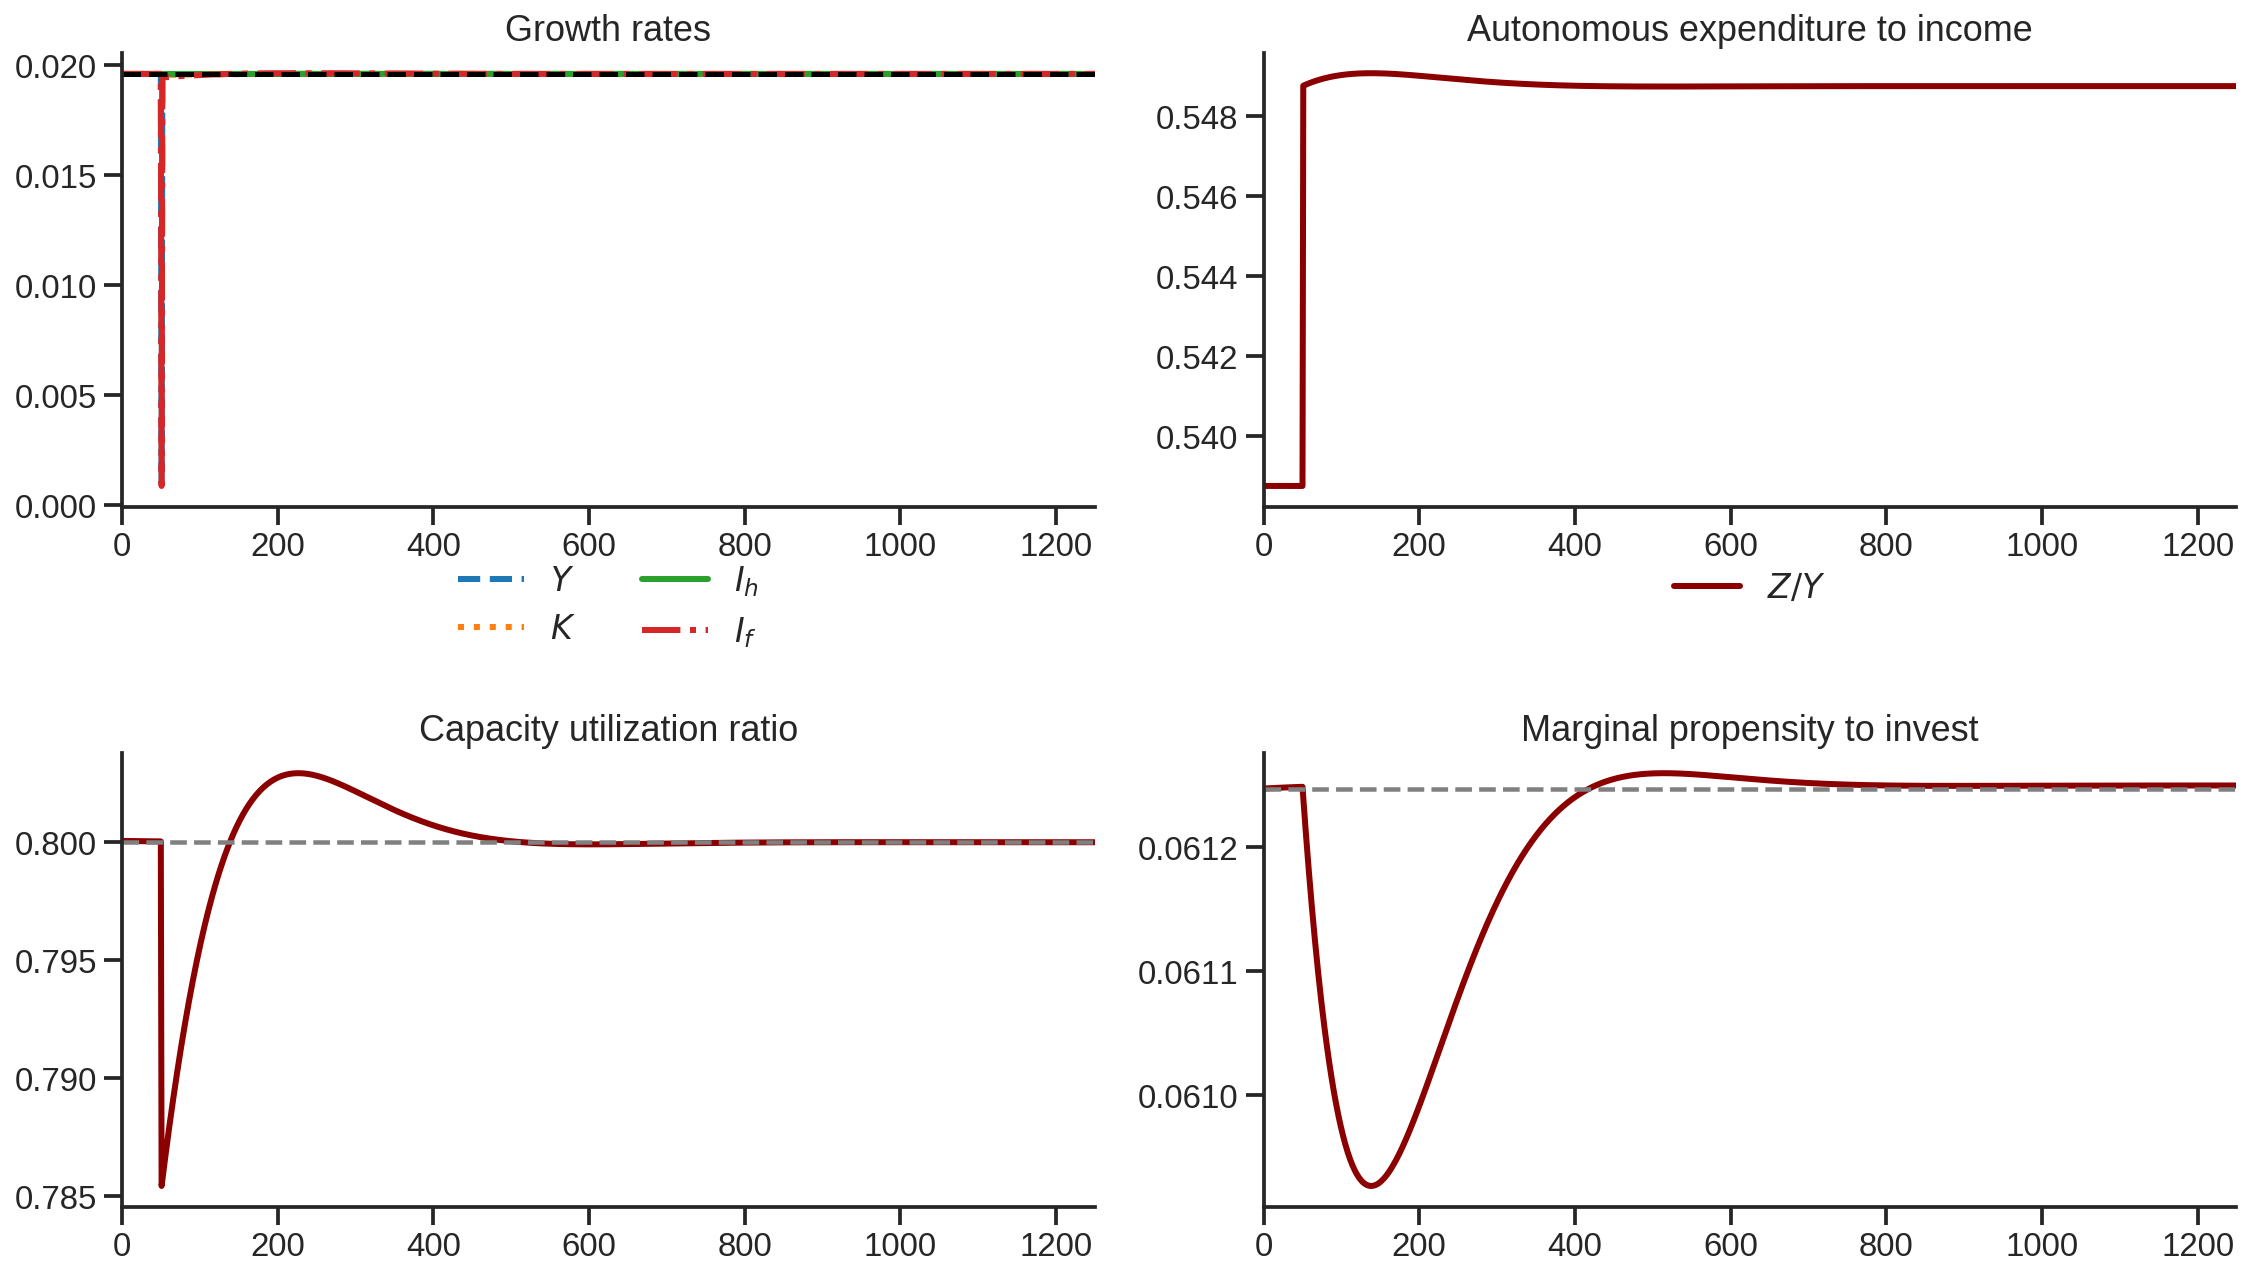

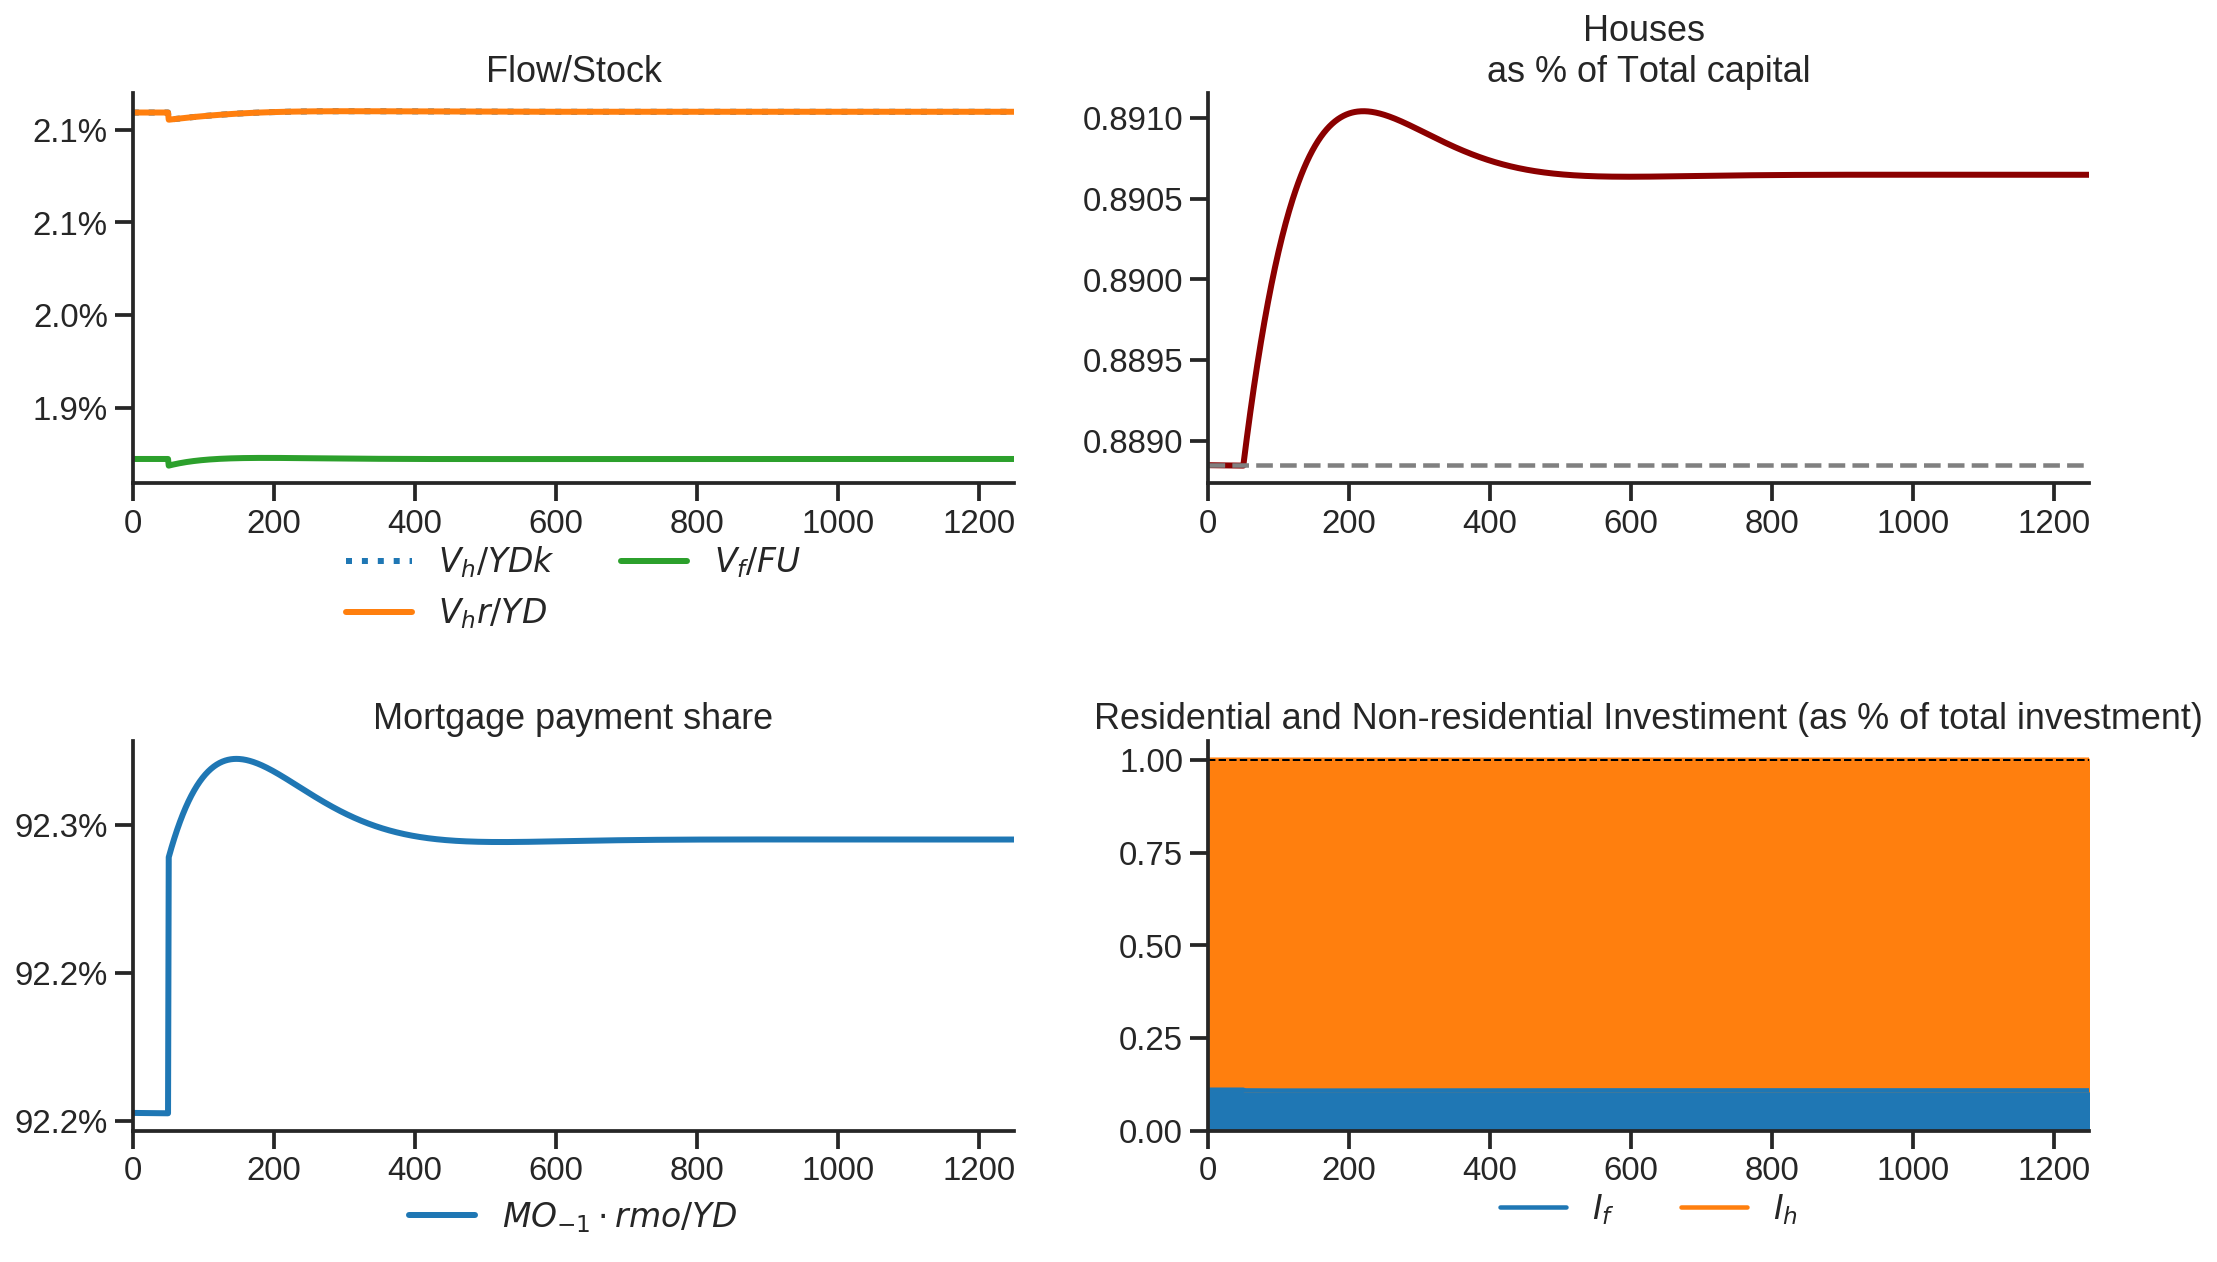

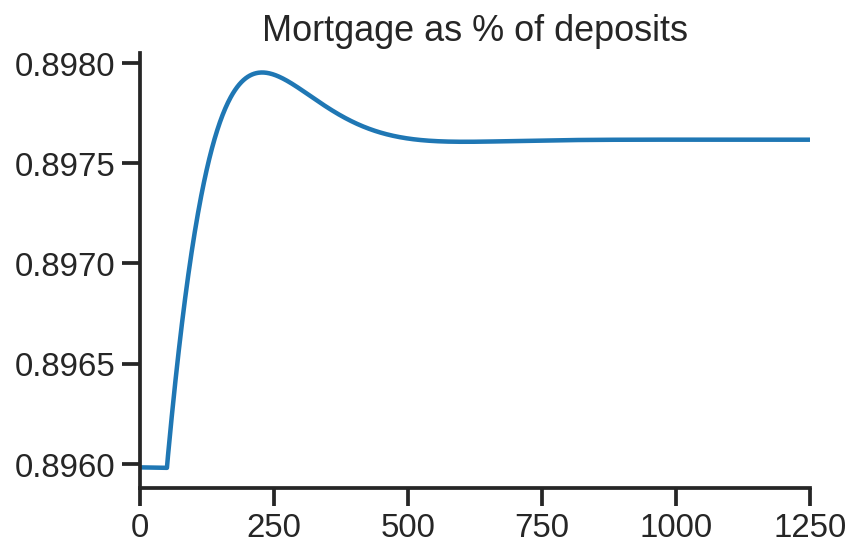

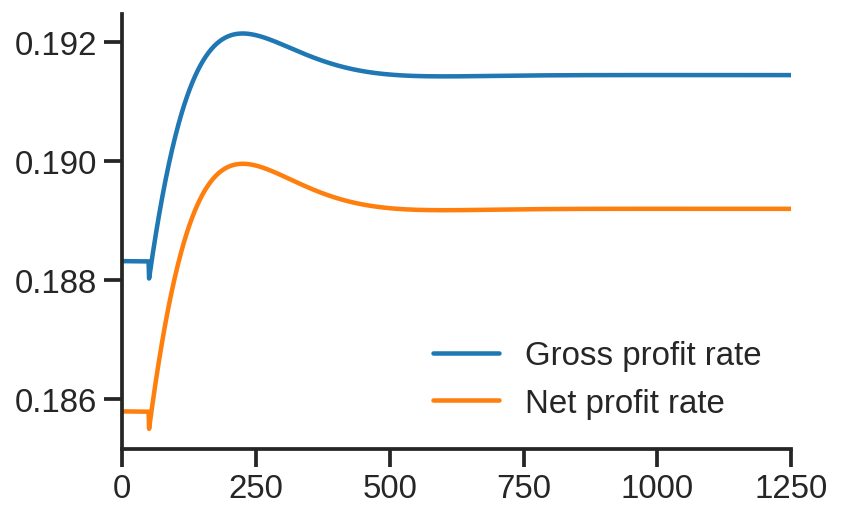

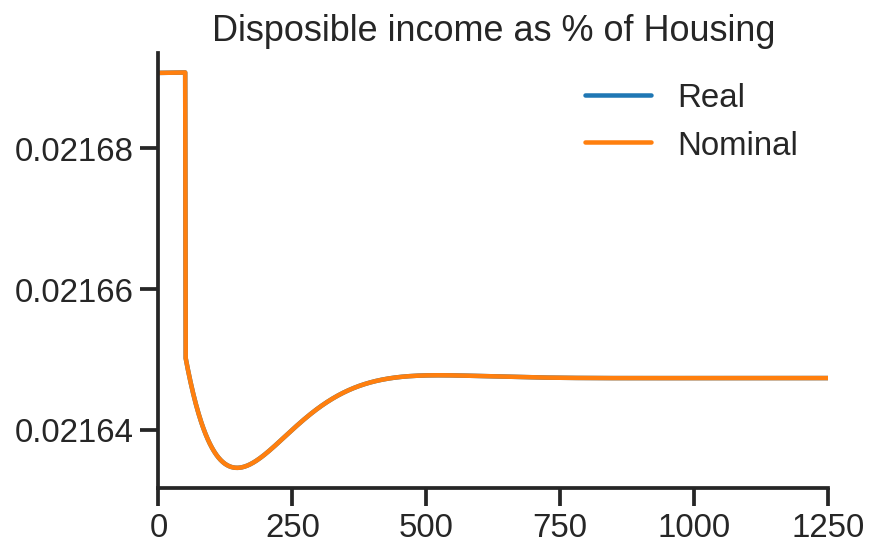

In [14]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='omega', increase=-0.01, time = 1200)
clock_plots(shock = shock, filename = 'Clock_2.png', variable='omega')
plot_shock(shock = shock, filename = 'Shock_2.png')
plot_norms(shock = shock, filename = 'Shock_2Norms.png')
other_plots(shock)
shock2 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock2.columns = ['$\Delta \omega$']

## Increase in mortgage rates

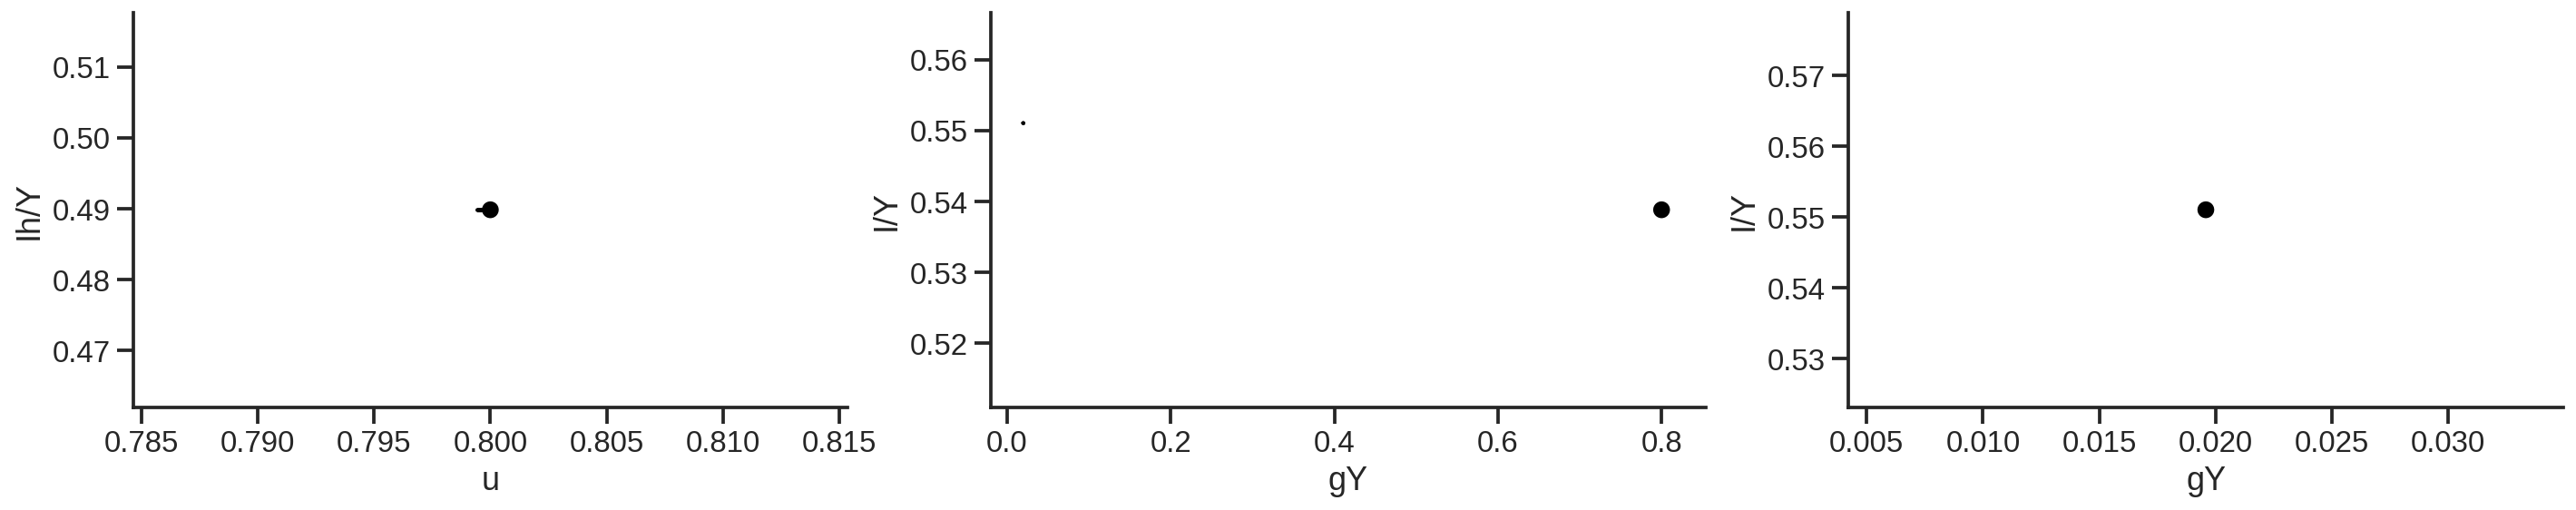

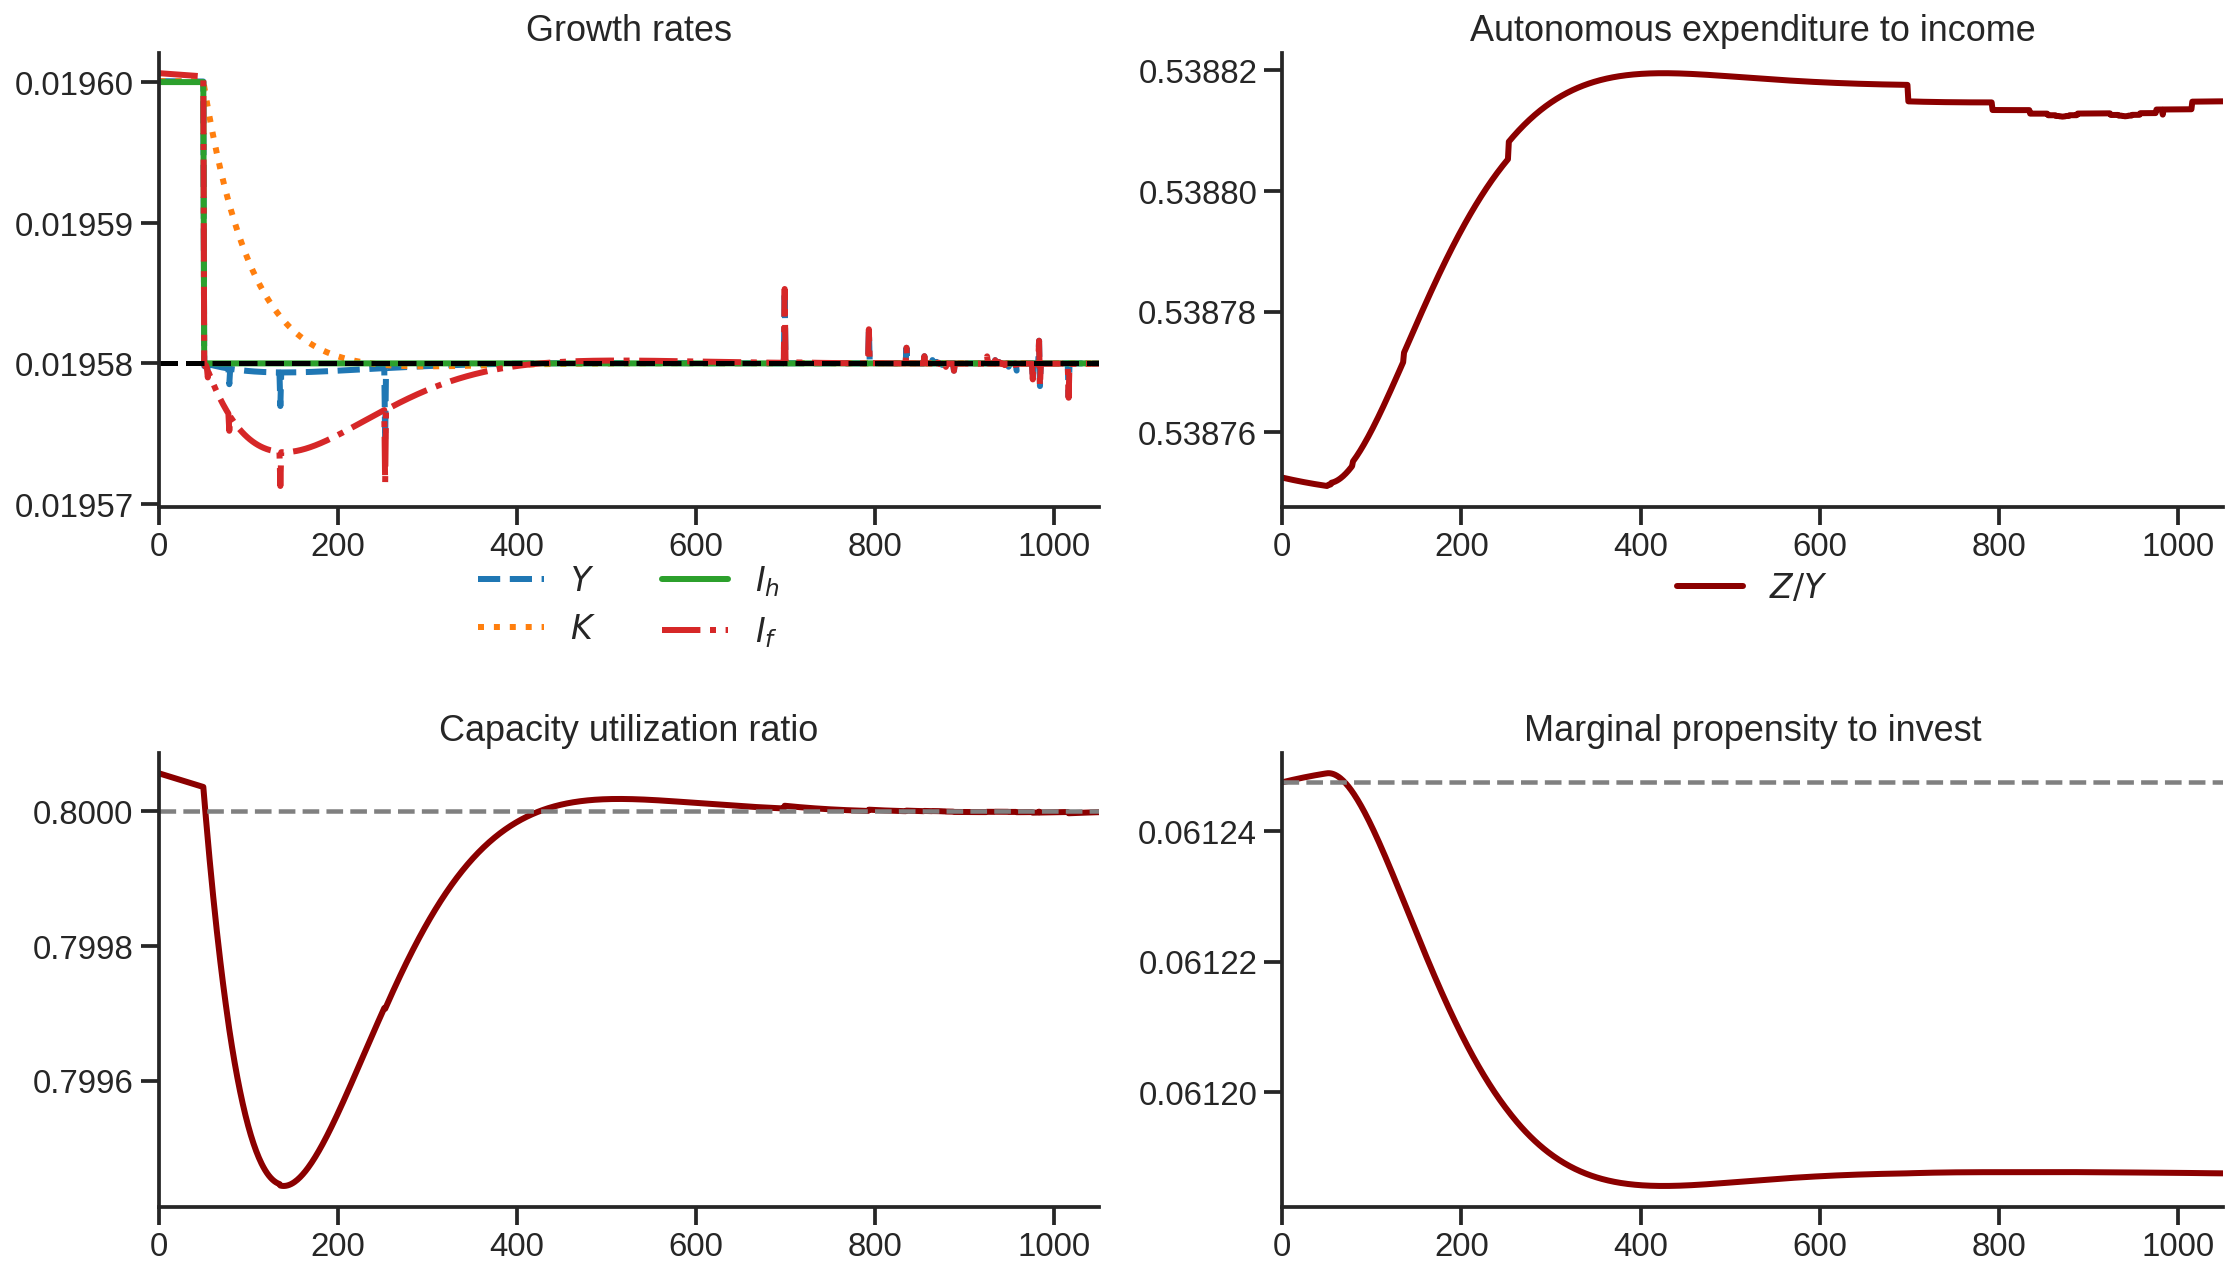

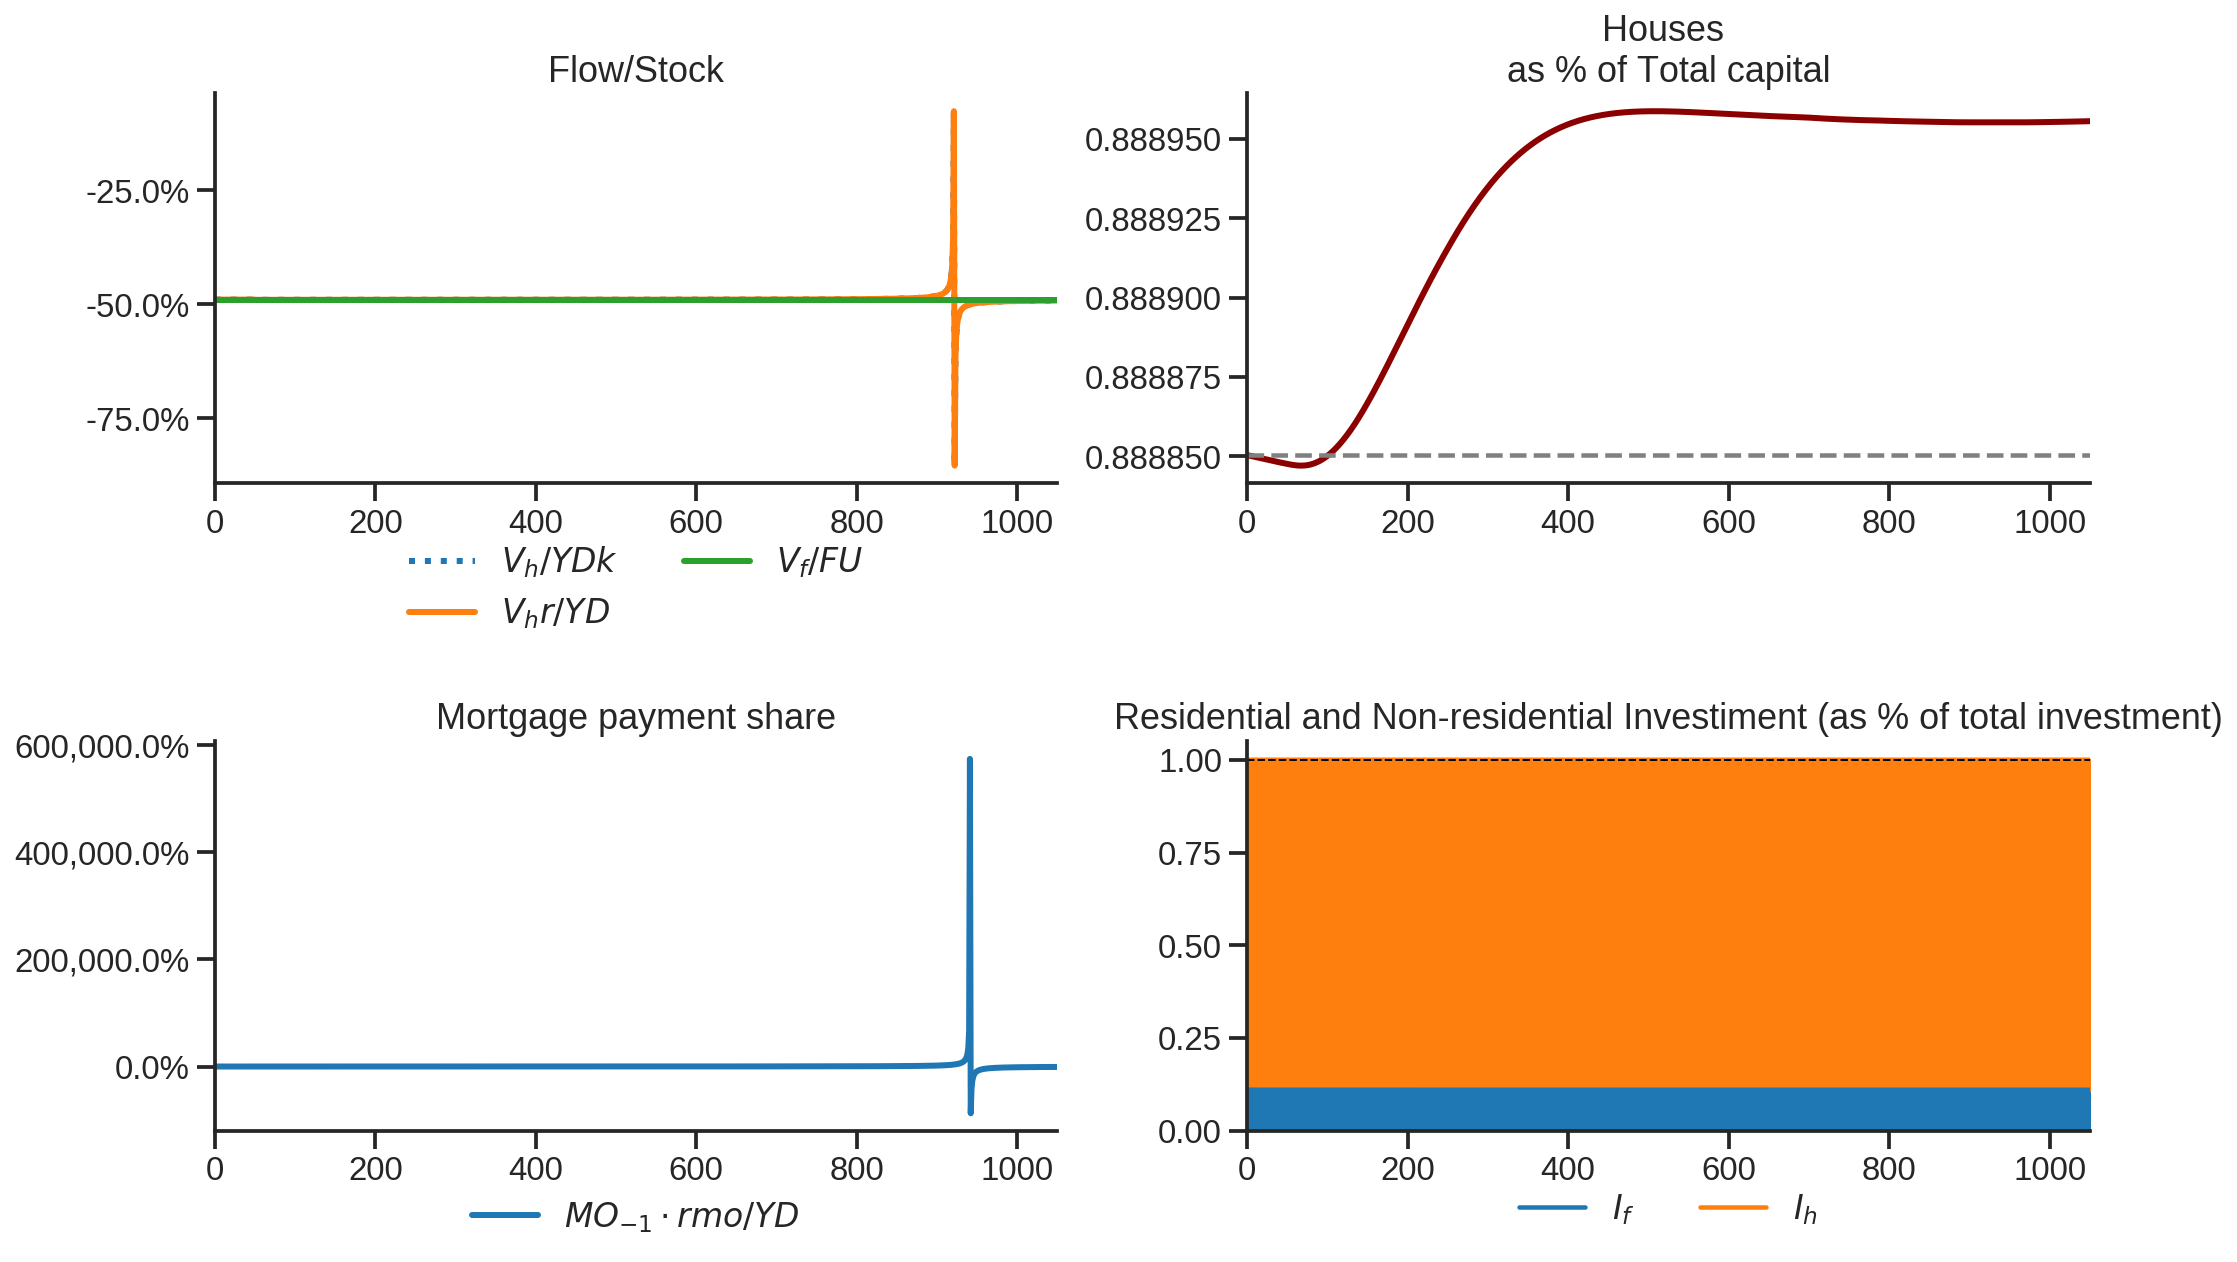

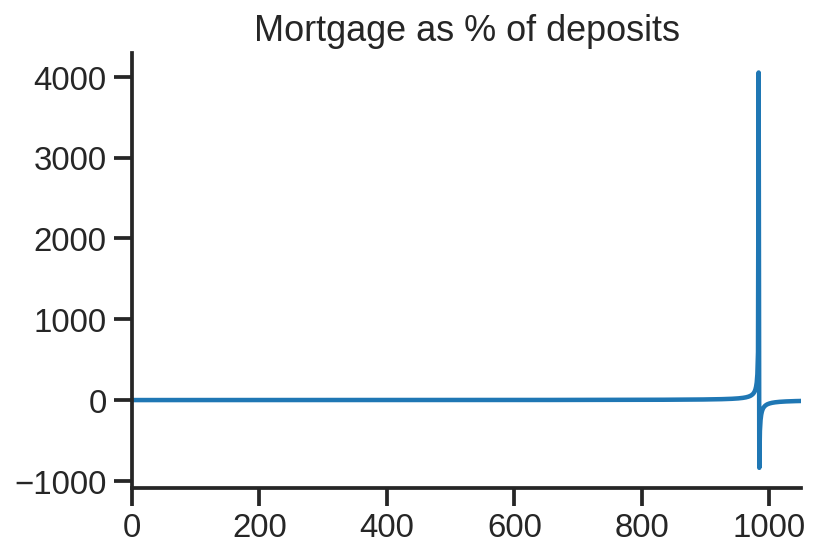

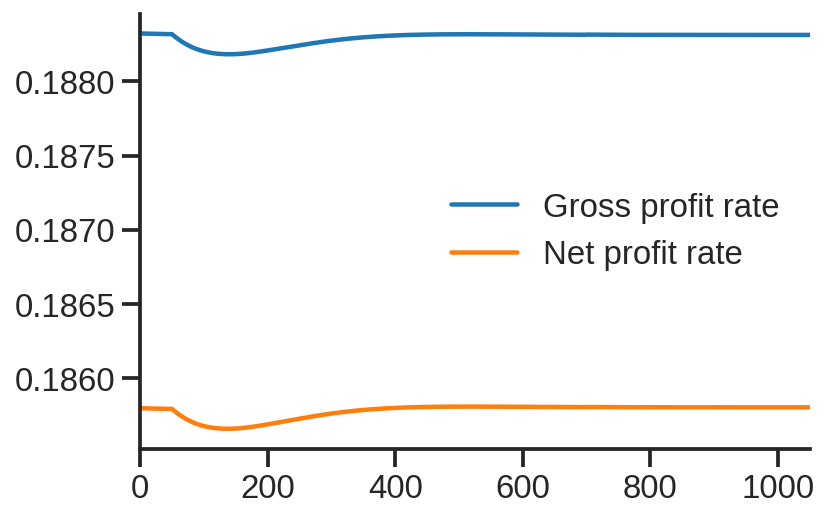

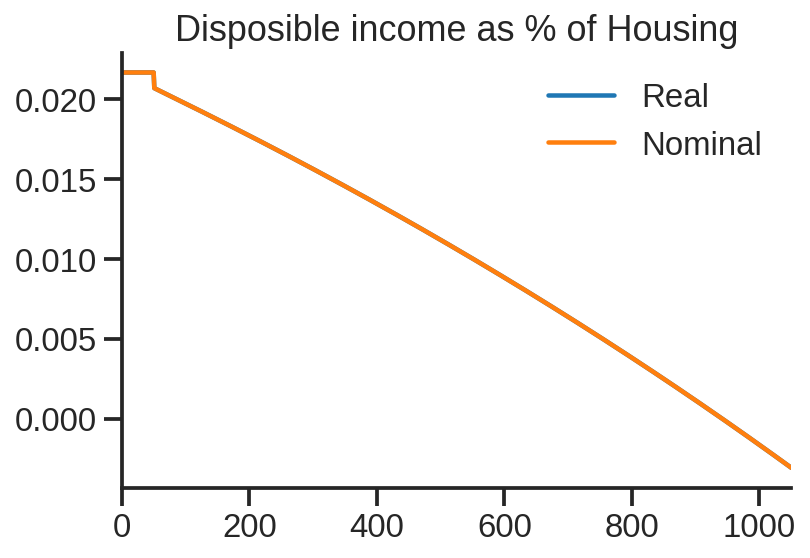

In [15]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='spread_mo', increase=0.001, time = 1000)
shock3 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock3.columns = ['$\Delta rm$']
clock_plots(shock = shock, filename = 'Clock_3.png', variable='rmo')
plot_shock(shock = shock, filename = 'Shock_3.png')
plot_norms(shock = shock, filename = 'Shock_3Norms.png')
other_plots(shock)

## Increase in inflation

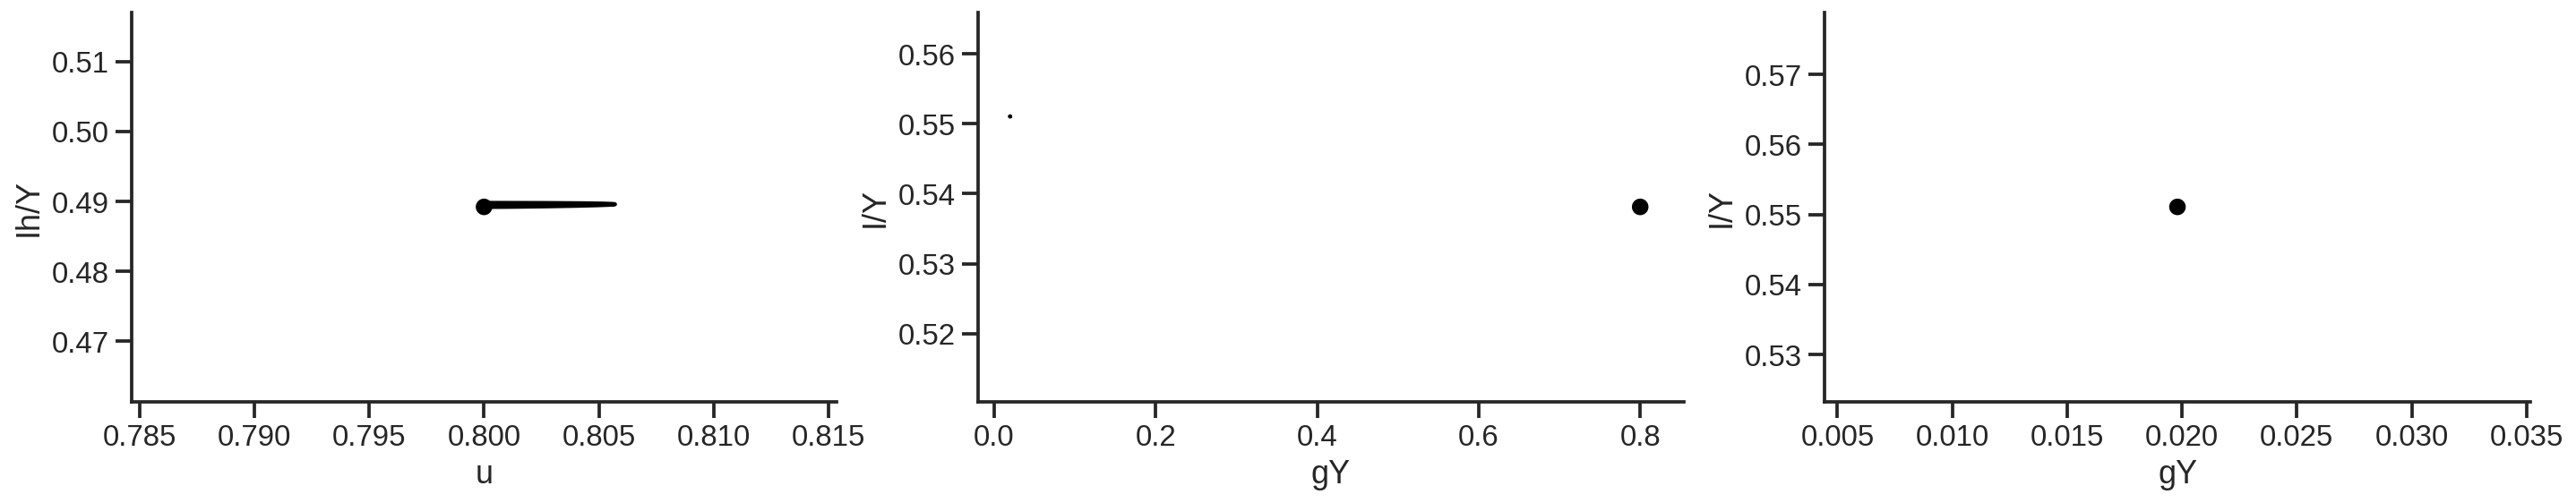

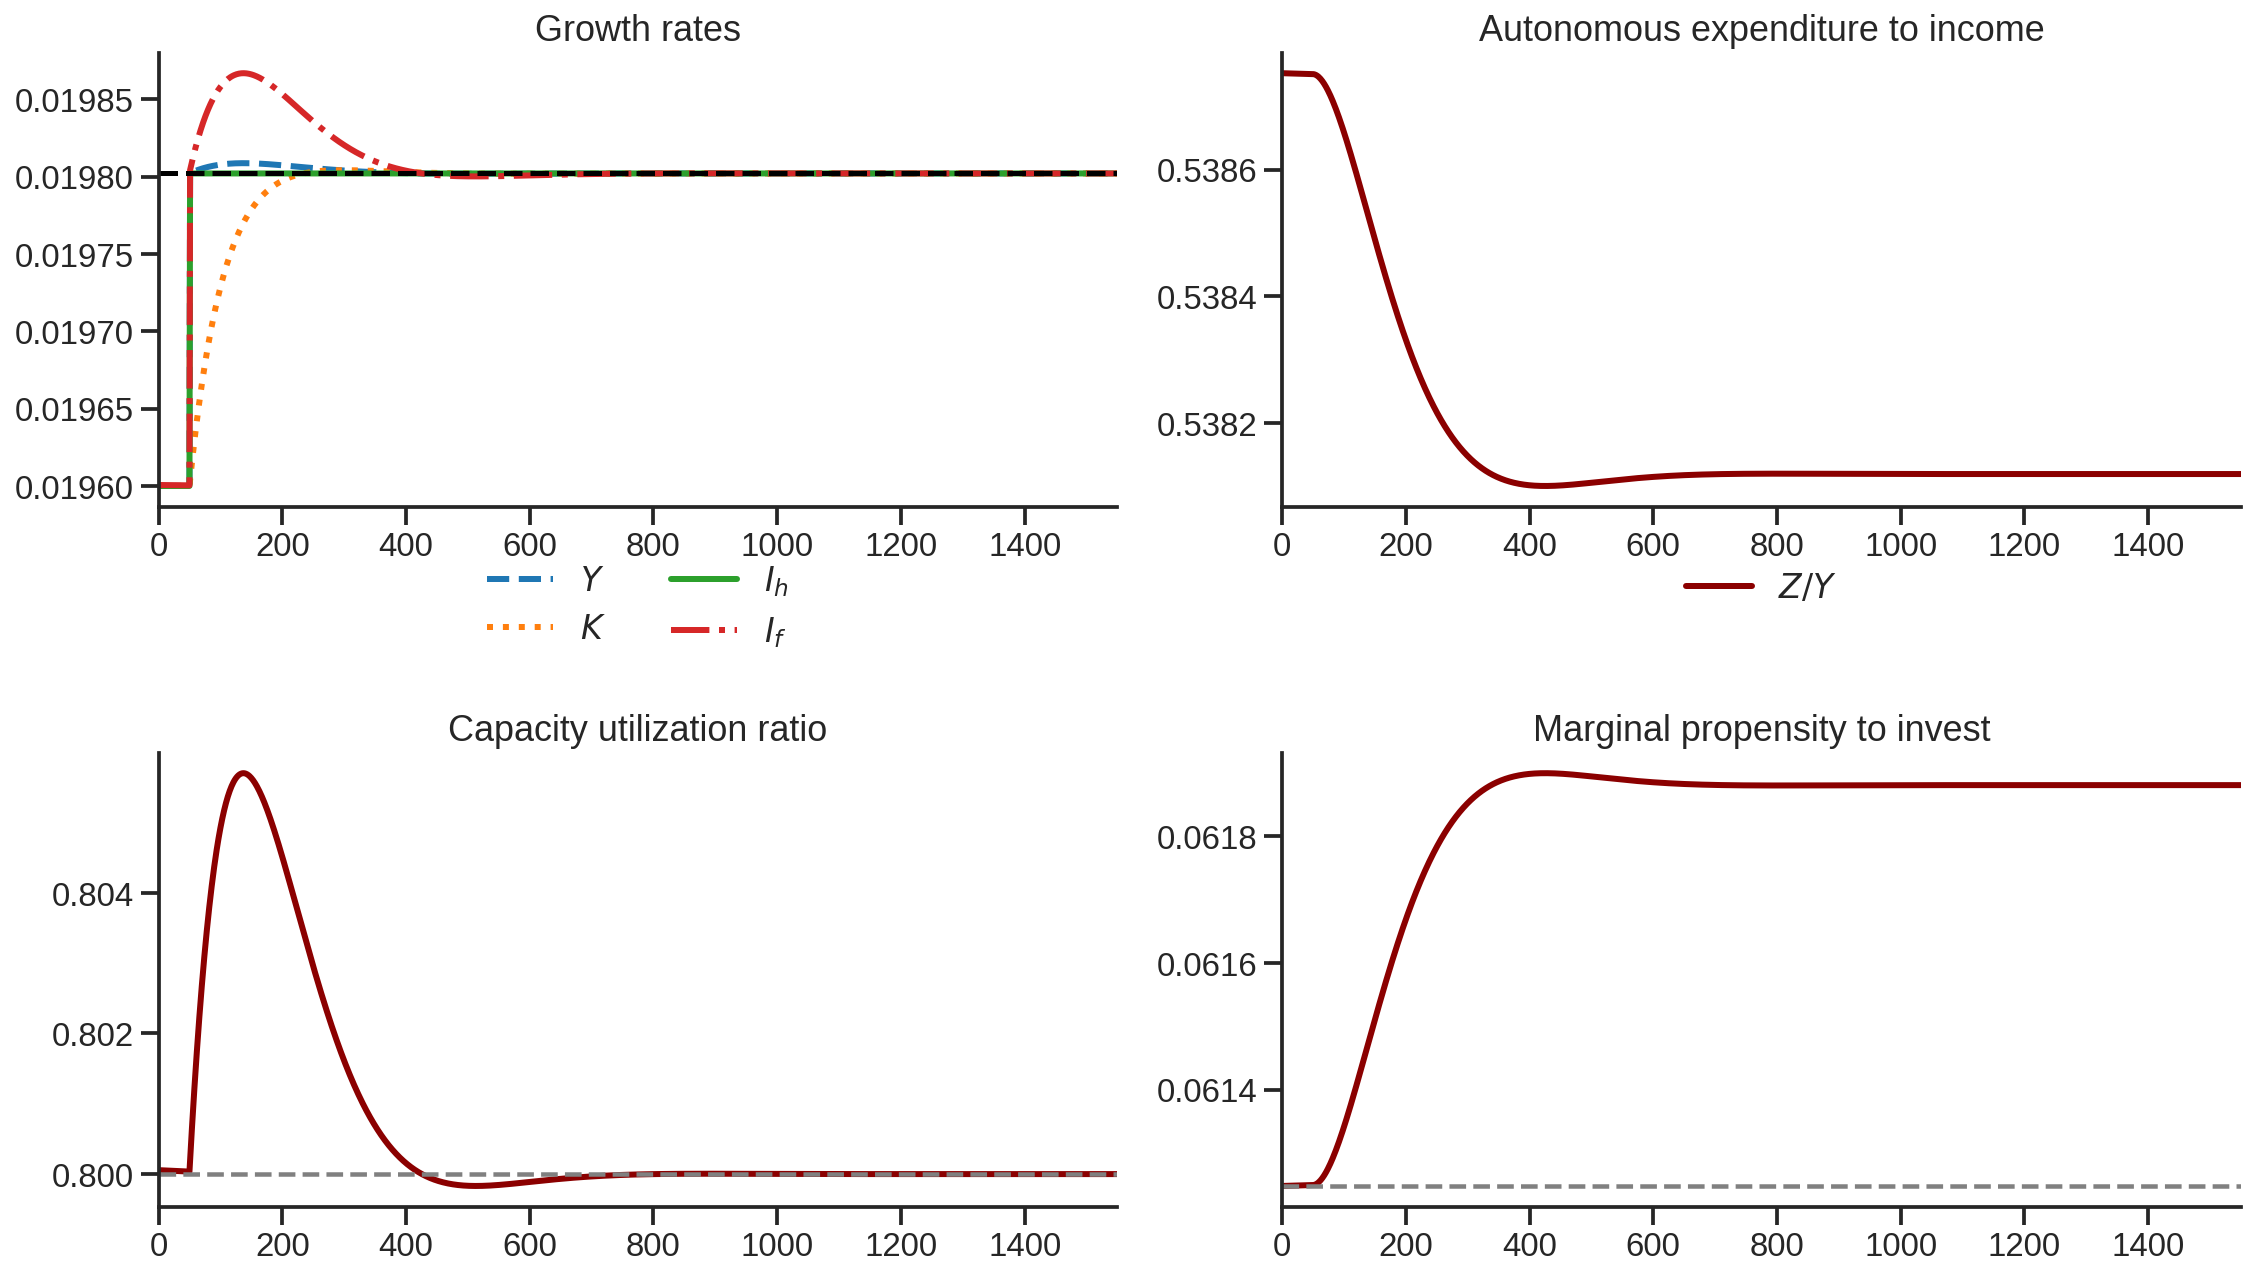

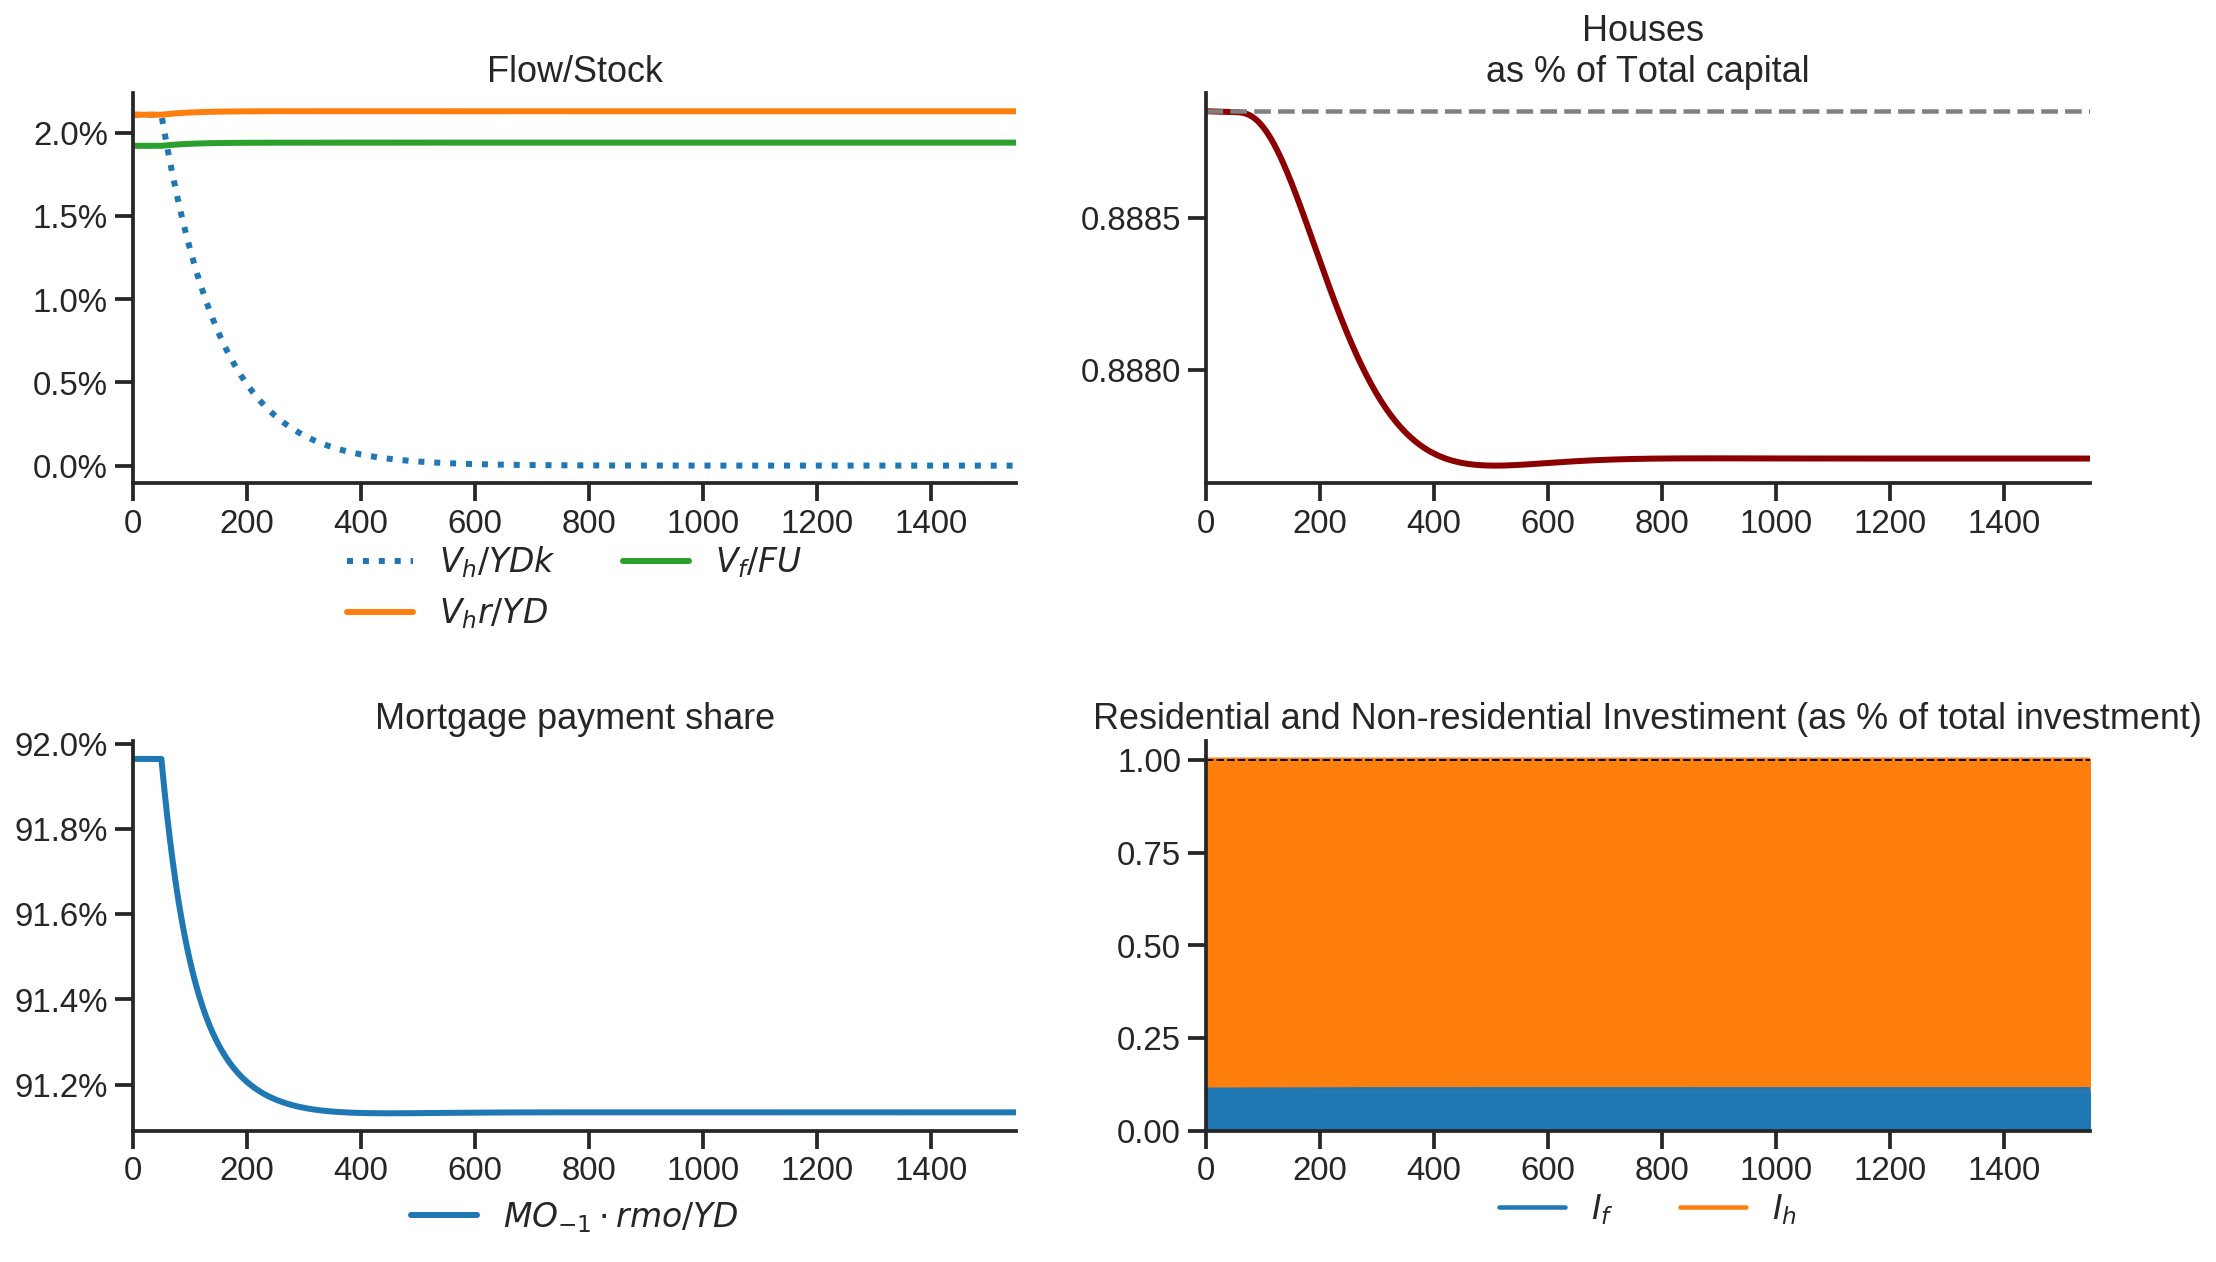

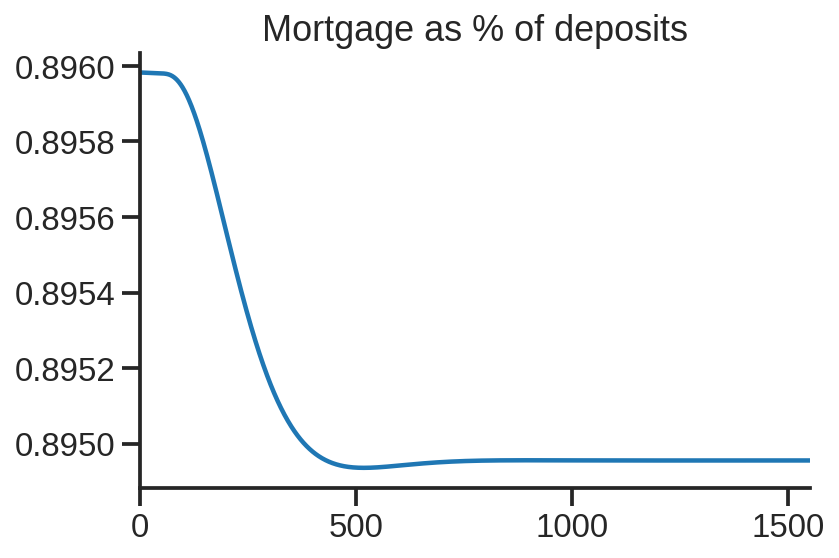

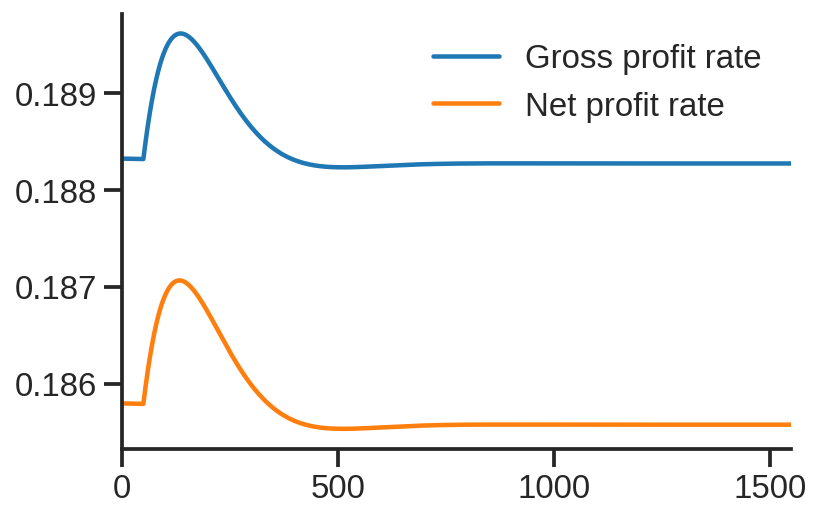

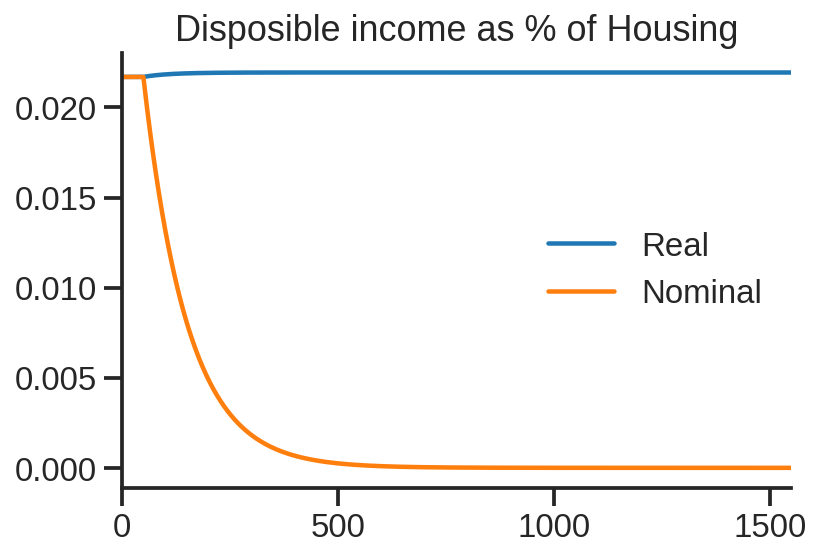

In [16]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='infla', increase=0.01, time = 1500)

clock_plots(shock = shock, filename = 'Clock_4.png', variable='infla')
plot_shock(shock = shock, filename = 'Shock_4.png')
plot_norms(shock = shock, filename = 'Shock_4Norms.png')
other_plots(shock)

shock4 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock4.columns = ['$\Delta p_h$']

## Increase in Loans interest rates

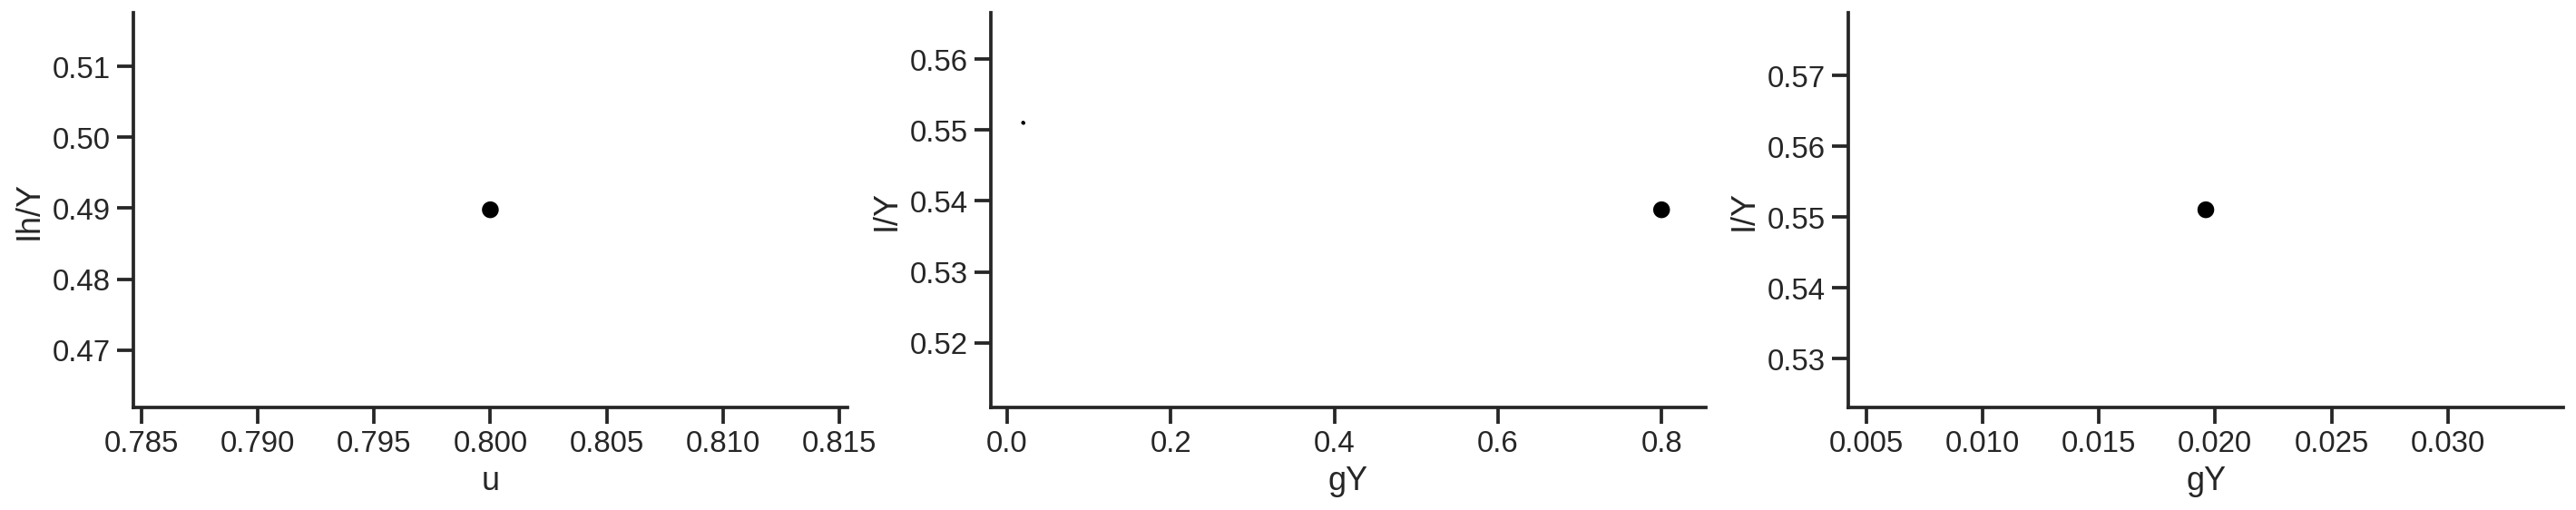

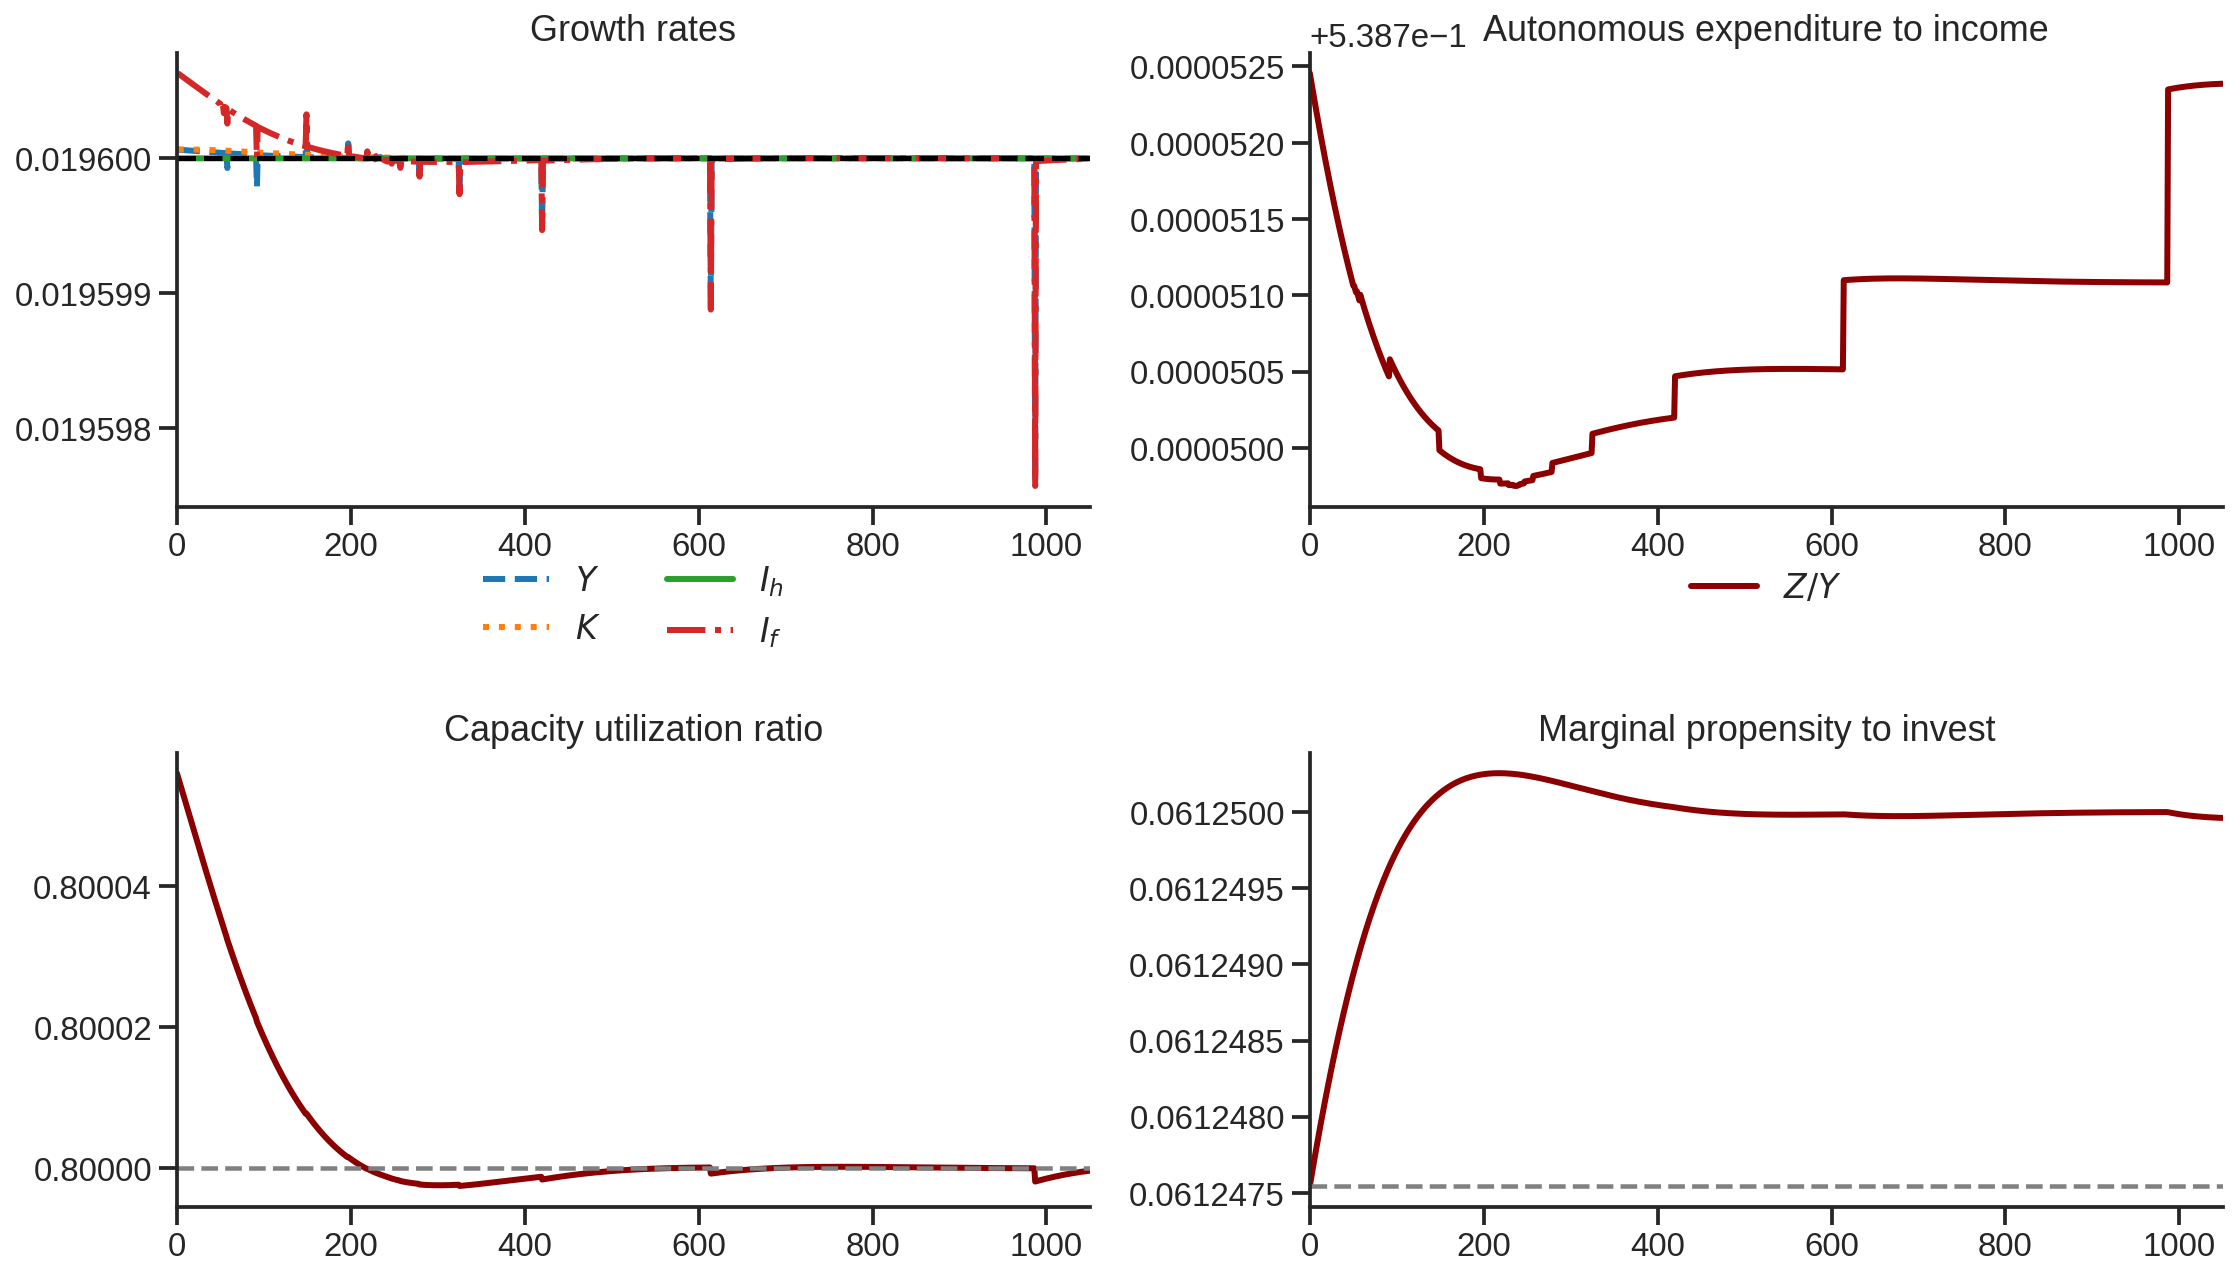

In [17]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='spread_l', increase=0.001, time = 1000)
shock5 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock5.columns = ['$\Delta rl$']
clock_plots(shock = shock, filename = 'Clock_5.png', variable='rmo')
plot_shock(shock = shock, filename = 'Shock_5.png')
plot_norms(shock = shock, filename = 'Shock_5Norms.png')
other_plots(shock)

## Plugging real data

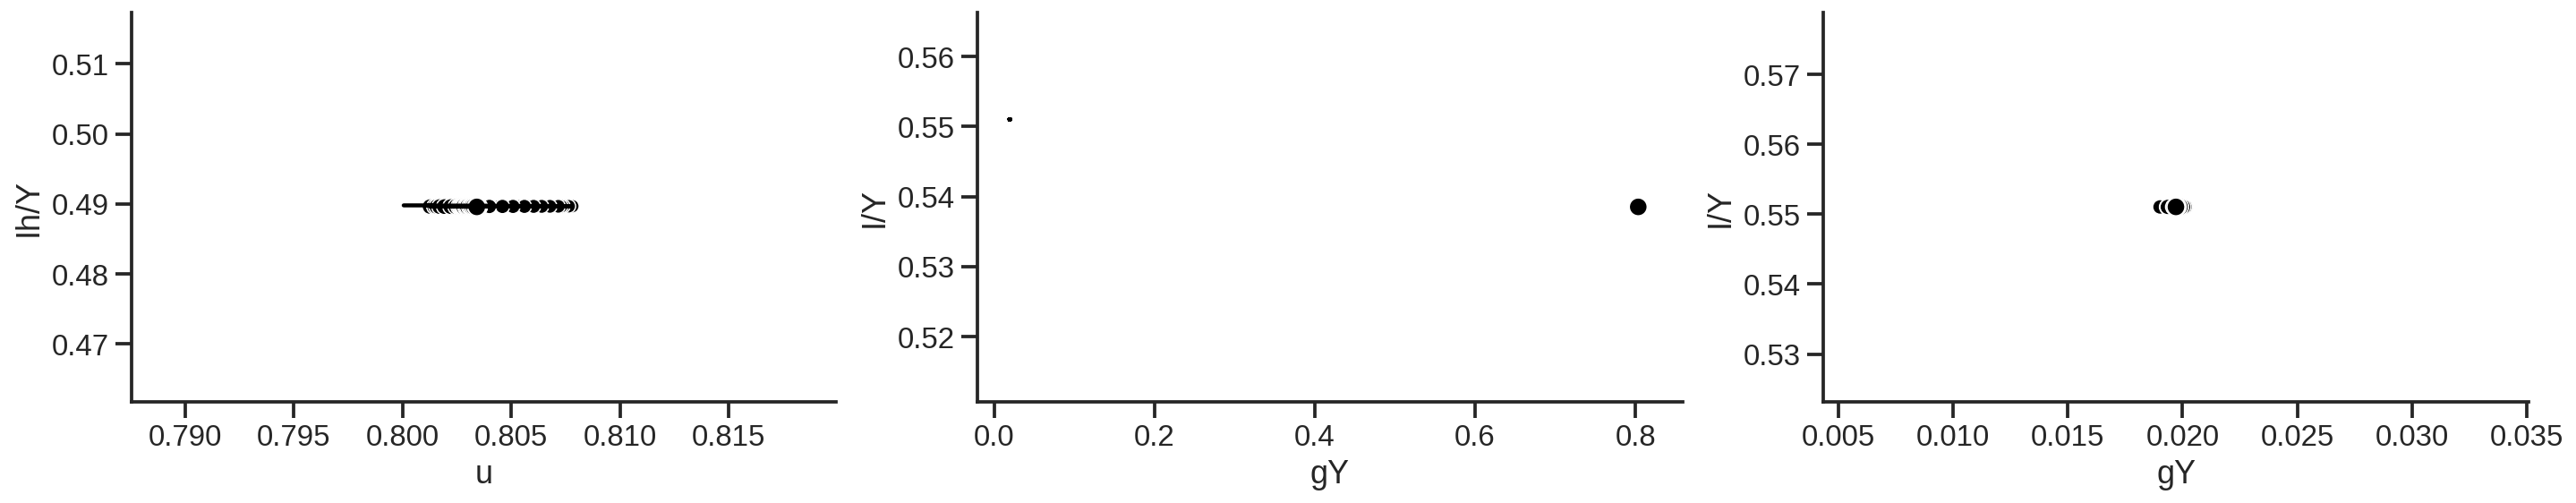

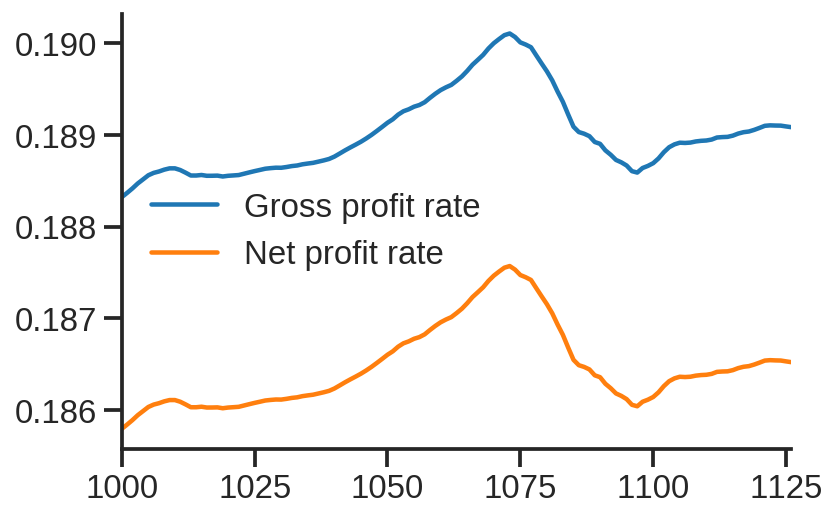

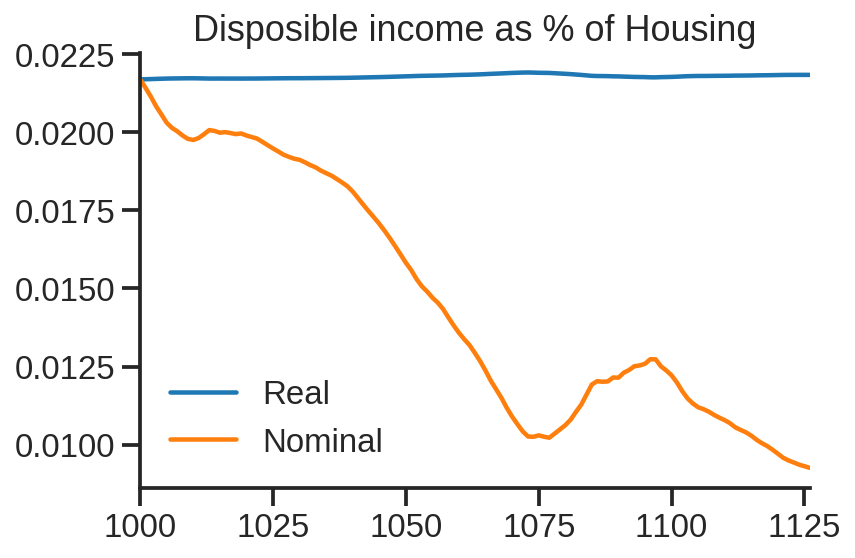

In [18]:
base=model()

initial=1000
shock_duration=1

SolveSFC(base, time=initial, table=False)

for i in data.index:
    lagged = [key for key in base.solutions[-1].keys()]
    lagged = [i for i in lagged if "__" in i]
    for j in lagged:
        del base.solutions[-1][j]
    base.set_values(base.solutions[-1])
    base.set_values({
            'own':data['Taxa Própria'][i],
            'infla':data['Inflação'][i],
        })
    try: 
        SolveSFC(base, time=shock_duration, table=False)
    except Exception as e:
        print(f'For own interest rate = {i}, {e}')
        pass
    
shock = SFCTable(base)[initial:]
clock_plots(shock = shock, filename = 'Clock_5.png', variable='real data')
plot_shock(shock = shock, filename = 'Shock_5.png')
plot_norms(shock = shock, filename = 'Shock_5Norms.png')
other_plots(shock)

# Merging tables

In [20]:
df = df.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
df.columns = ['Base scenario']
df

table = pd.merge(left = df, right = shock1, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock2, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock3, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock4, left_index = True, right_index = True)
table.to_latex("table.tex", bold_rows = True, column_format = 'c', decimal = ',', escape=False,)
table

Base scenario  $\Delta \phi_0$  $\Delta \omega$   $\Delta rm$  \
alpha       1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   
gamma_F     8.000000e-02     8.000000e-02     8.000000e-02  8.000000e-02   
gamma_u     1.000000e-02     1.000000e-02     1.000000e-02  1.000000e-02   
omega       4.000000e-01     4.000000e-01     3.900000e-01  4.000000e-01   
rm          2.000000e-02     2.000000e-02     2.000000e-02  2.000000e-02   
spread_l    0.000000e+00     0.000000e+00     0.000000e+00  0.000000e+00   
spread_mo   0.000000e+00     0.000000e+00     0.000000e+00  1.000000e-03   
un          8.000000e-01     8.000000e-01     8.000000e-01  8.000000e-01   
v           2.500000e+00     2.500000e+00     2.500000e+00  2.500000e+00   
phi_0       2.000000e-02     2.100000e-02     2.000000e-02  2.000000e-02   
phi_1       2.000000e-02     2.000000e-02     2.000000e-02  2.000000e-02   
phparam     1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   
pe          1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   
R           1.000000e-01     1.000000e-01     1.000000e-01  1.000000e-01   
infla       0.000000e+00     0.000000e+00     0.000000e+00  0.000000e+00   
_K_f__1     1.716524e+11     3.267842e+20     5.807356e+21  1.195171e+20   
_M_h__1     1.532044e+12     2.774395e+21     5.269426e+22 -9.195923e+19   
_MO__1      1.372684e+12     2.471809e+21     4.729925e+22  9.567825e+20   
_Lk__1      1.372684e+11     2.471809e+20     4.729925e+21  9.567825e+19   
_Eq__1      1.683526e+10     3.201883e+19     5.695720e+20  1.172219e+19   
_M_f__1     0.000000e+00     0.000000e+00     0.000000e+00  0.000000e+00   
_Lf__1      2.209225e+10     5.540681e+19     6.651604e+20  1.528596e+19   
_h__1       6.100000e-02     6.437000e-02     6.100000e-02  6.100000e-02   
_L__1       1.593607e+11     3.025877e+20     5.395085e+21  1.109642e+20   
_M__1       1.532044e+12     2.774395e+21     5.269426e+22 -9.195923e+19   
_K_HD__1    1.372684e+12     2.471809e+21     4.729925e+22  9.567825e+20   
_I_h__1     2.638742e+10     4.989150e+19     9.092440e+20  1.837404e+19   
_ph__1      1.000000e+00     1.000000e+00     1.000000e+00  1.000000e+00   

           $\Delta p_h$  
alpha      1.000000e+00  
gamma_F    8.000000e-02  
gamma_u    1.000000e-02  
omega      4.000000e-01  
rm         2.000000e-02  
spread_l   0.000000e+00  
spread_mo  0.000000e+00  
un         8.000000e-01  
v          2.500000e+00  
phi_0      2.000000e-02  
phi_1      2.000000e-02  
phparam    1.000000e+00  
pe         1.000000e+00  
R          1.000000e-01  
infla      1.000000e-02  
_K_f__1    2.694381e+24  
_M_h__1    2.380041e+25  
_MO__1     2.130031e+25  
_Lk__1     2.130031e+24  
_Eq__1     2.642063e+23  
_M_f__1    0.000000e+00  
_Lf__1     3.701015e+23  
_h__1      6.200000e-02  
_L__1      2.500132e+24  
_M__1      2.380041e+25  
_K_HD__1   2.130031e+25  
_I_h__1    4.135982e+23  
_ph__1     3.004272e+06

# Dag

/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


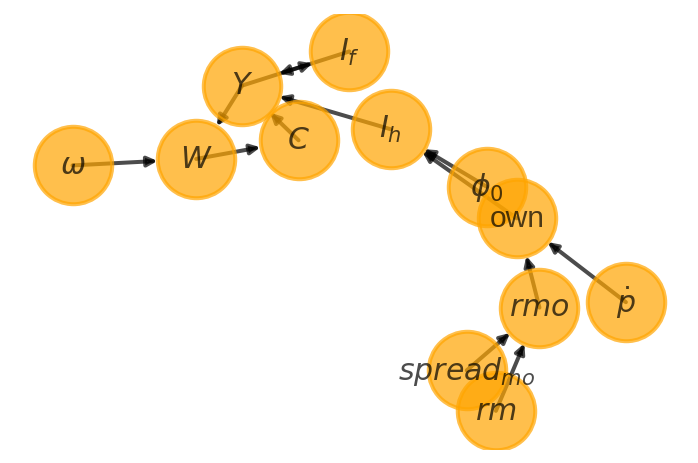

In [21]:
df = pd.DataFrame(
    {
        'Determinada' : [
            '$Y$', # 1
            #'$Y$', # 2
            '$C$', # 3
            '$W$', # 5
            '$Y$', # 7
            '$Y$', # 8
            '$I_h$', # 9
            'own', # 10
            'own', # 11
            '$I_f$', # 12
            '$I_h$', # 13
            '$rmo$', # 14
            '$rmo$', # 15,
            '$W$', # 16
        ], 
        'Determina' : [
            '$C$',  # 1
            #'$It$', # 2
            '$W$', # 3
            '$\omega$', # 5
            '$I_f$', # 7
            '$I_h$', # 8
            'own', # 9
            '$\dot p$', # 10
            '$rmo$', # 11
            '$Y$', # 12,
            '$\phi_0$', # 13
            '$rm$', # 14
            '$spread_{mo}$', # 15
            '$Y$', # 16
        ]
}
)
 
# Build your graph
G=nx.from_pandas_edgelist(
    df, 
    'Determina', 
    'Determinada', 
    create_using=nx.DiGraph() # To use with arrows
)
 
    
fig, ax = plt.subplots()
    
# Plot it
nx.draw(
    G, 
    with_labels=True, 
    node_color='orange', 
    node_size=1500, 
    edge_color='black', 
    linewidths=2,
    width=2,
    arrows=True,
    font_size=15,
    alpha=.7, 
    ax = ax,
    #pos=nx.spring_layout(G),
    pos=nx.fruchterman_reingold_layout(G),
    #pos=nx.shell_layout(G),
)

plt.show()
fig.savefig('Dag.png', dpi = 300)

# Analytical solution

In [22]:
base_eq = model()
SolveSFC(base_eq, time=1, table = False)
t = sp.Symbol('t')
initials = {
    key: base_eq.evaluate(key) for key in base_eq.parameters
}
initials.update({key: base_eq.evaluate(key) for key in base_eq.variables})

for i in base_eq.variables:
  globals()["_" + i] = sp.Function(i)
  
for i in base_eq.parameters:
  globals()[i] = sp.symbols(i, positive=True)
  globals()['infla'] = sp.symbols('infla')

## General equations

In [23]:
Y = _C(t) + _I_t(t)
pprint(sp.Eq(_Y(t), Y))
I = _I_f(t) + _I_h(t)
pprint(sp.Eq(_I_t(t), I))
Yk = _K_f(t)/v
pprint(sp.Eq(_Yk(t), Yk))
u = _Y(t)/_Yk(t)
pprint(sp.Eq(_u(t), u))
Z = _I_h(t)
pprint(sp.Eq(_Z(t), Z))
W = omega*_Y(t)
pprint(sp.Eq(_W(t), W))
K = _K_HD(t) + _K_f(t)
pprint(sp.Eq(_K(t), K))

Y(t) = C(t) + Iₜ(t)
Iₜ(t) = I_f(t) + Iₕ(t)
        K_f(t)
Yk(t) = ──────
          v   
        Y(t)
u(t) = ─────
       Yk(t)
Z(t) = Iₕ(t)
W(t) = ω⋅Y(t)
K(t) = K_HD(t) + K_f(t)


## Households

In [24]:
C = alpha*_W(t)
pprint(sp.Eq(_C(t), C))
YD = _W(t) + _FD(t) + rm*_M(t-1) - _rmo(t)*_MO(t-1)
pprint(sp.Eq(_YD(t), YD))
S_h = _YD(t) - _C(t)
pprint(sp.Eq(_S_h(t), S_h))
dMO = _I_h(t)
pprint(sp.Eq(_MO(t) - _MO(t-1), dMO))
V_h = _M(t) + _K_HD(t) - _MO(t)
pprint(sp.Eq(_V_h(t), V_h))
NFW_h = _S_h(t) - _I_h(t)
pprint(sp.Eq(_NFW_h(t), NFW_h))

C(t) = α⋅W(t)


NameError: name '_YD' is not defined

## Firms

In [ ]:
I_f = _h(t)*_Y(t)
pprint(sp.Eq(_I_f(t), I_f))
dK_f = _I_f(t)
pprint(sp.Eq(_K_f(t) - _K_f(t-1), dK_f))
Lf = _I_f(t) - _FU(t) + _L(t-1)
pprint(sp.Eq(_Lf(t), Lf))
FT = _FU(t) + _FD(t)
pprint(sp.Eq(_FT(t), FT))
FU = gamma_F*(_FT(t) - _rl(t)*_L(t-1))
pprint(sp.Eq(_FU(t), FU))
FD = (1 - gamma_F)*(_FT(t) - _rl(t)*_L(t-1))
pprint(sp.Eq(_FD(t), FD))
h = _h(t-1)*gamma_u*(_u(t)-un) + _h(t-1)
pprint(sp.Eq(_h(t), h))
NFW_f = _FU(t) - _I_f(t)
pprint(sp.Eq(_NFW_f(t), NFW_f))
V_f = _K_f(t) - _L(t)
pprint(sp.Eq(_V_f(t), V_f))

## Banks

In [ ]:
L = _Lf(t)
pprint(sp.Eq(_L(t), L))
M = (_L(t) - _L(t-1)) + (_MO(t) - _MO(t-1)) + _M(t-1)
pprint(sp.Eq(_M(t), M))
rmo = rm + spread_mo
pprint(sp.Eq(_rmo(t), rmo))
rl = rm + spread_l
pprint(sp.Eq(_rl(t), rl))
V_b = _L(t) + _MO(t) - _M(t)
pprint(sp.Eq(_V_b(t), V_b))
NFW_b = _rl(t)*_L(t-1) + _rmo(t)*_MO(t-1) - rm*_M(t-1)
pprint(sp.Eq(_NFW_b(t), NFW_b))

## Residential Investment

In [ ]:
_own = sp.Function('own')

K_HS = _K_HD(t)
pprint(sp.Eq(_K_HS(t), K_HS))
Is = _I_h(t)
pprint(sp.Eq(_Is(t), Is))
dK_HD = _I_h(t)
pprint(sp.Eq(_K_HD(t) - _K_HD(t-1), dK_HD))
I_h = (1+_g_Z(t))*_I_h(t-1)
pprint(sp.Eq(_I_h(t), I_h))
K_k = _K_HD(t)/(_K(t))
pprint(sp.Eq(_K_k(t), K_k))
ph = (1+infla)*_ph(t-1)
pprint(sp.Eq(_ph(t), ph))
own = ((1+_rmo(t))/(1+infla))-1
pprint(sp.Eq(_own(t), own))
g_Z = phi_0 - phi_1*_own(t)
pprint(sp.Eq(_g_Z(t), g_Z))

### Stability condition

In [ ]:
g = sp.Function('g')
gK = sp.Function('g_K')


def replacer(express):
    #print("\nReplacing the initial values.....")
    df = SolveSFC(model(), time=1)
    df = df.iloc[1, :]

    express = express.subs(alpha, df['alpha']).subs(
        omega, df['omega'])
    express = express.subs(un, df['un']).subs(
        gamma_u, df['gamma_u'])
    express = express.subs(
        infla, df['infla'])
    express = express.subs(phi_0, df['phi_0']).subs(
        phi_1,
        df['phi_1']).subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo'])
    express = express.subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo']).subs(v, df['v'])
    return express

In [ ]:
EqY = Y - _Y(t)
EqY = EqY.subs(_C(t), C).subs(_I_t(t), I)
EqY = EqY.subs(_I_f(t), I_f)
EqY = EqY.subs(_W(t), W)
EqY = EqY.subs(_I_h(t), _Z(t))

EqY = sp.solve(EqY, _Y(t))[0].collect(alpha).collect(omega)
solY = EqY
pprint(cse(solY, optimizations='basic')[1], use_unicode=True)
print('dY/d alpha = ', EqY.diff(alpha))
print('dY/d omega = ', EqY.diff(omega))

print("\nGowth rate.....")
gY, h_, gz_ = sp.symbols('gY h gZ')
gY_ = alpha * omega * gY + _h(t) * gY + _h(t) - _h(
    t - 1) + (_Z(t) / _Y(t)) * _g_Z(t) - gY
gY_ = gY_.subs(_g_Z(t), gz_).subs(_Y(t), solY).subs(_g_Z(t), gz_)
gY_ = gY_.subs(_h(t) - _h(t - 1), h - _h(t - 1))
gY_ = sp.solve(gY_, gY)[0].collect(gz_)
pprint(sp.Eq(g(t), sp.simplify(gY_)))

print('\nd gY/ d alpha\n')
pprint(gY_.diff(alpha))
print('\nd gY/ d omega\n')
pprint(gY_.diff(omega))

### Stability conditon (I)

In [ ]:
own_ = sp.Symbol('own')
g_LR = gY_.subs(_u(t), un)
pprint(sp.Eq(g(t), g_LR))

Equ = _u(t)*(g(t) - gK(t)) + _u(t-1)
pprint(sp.Eq(_u(t), Equ))
g_K = (_h(t)*_u(t))/v
pprint(sp.Eq(gK(t), g_K))
Equ = _u(t)*(g(t) - g_K)
Equ = Equ.subs(g(t), gz_)
pprint(sp.Eq(_u(t), Equ))
print(sp.latex(sp.Eq(_u(t), Equ)))

Eqh = _h(t)*gamma_u*(_u(t) - un)
pprint(sp.Eq(_h(t), Eqh))
print(sp.latex(sp.Eq(_h(t), Eqh)))

print('\nBuilding Jacobian matrix and evaluating at u = un\n')
J = sp.Matrix([
        [
            Eqh.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Eqh.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ], 
        [
            Equ.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Equ.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ]])
pprint(J)
print(sp.latex(J))
print('\nDeterminant:\n')
pprint(J.det()>0)
print(sp.latex(J.det()>0))
estability = sp.solve(J.det().subs(gz_, g_Z).subs(_own(t), own_)>0, own_)
print("\nStability condition\n")
pprint(estability)
estability = replacer(estability)
pprint(estability)
pprint(sp.Eq(own_, initials['own']))
estability = estability.subs(own_, own)
pprint(estability)
print('Rewriting')
estability = -(1+infla) + (1+rmo) < 2*(1+infla)
pprint(estability)
estability = sp.solve(estability, infla)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
pprint(estability)

print('\nTrace:\n')
pprint(J.trace()<0)
print(sp.latex(J.trace()<0))
print("\nStability condition\n")
estability = sp.solve(J.trace()<0).subs(gz_, g_Z)
pprint(estability)
estability = estability.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
estability = estability.subs(phi_0, initials['phi_0']).subs(phi_1, initials['phi_1'])
pprint(estability)

### Stability condition (II)

In [ ]:
print('d gY/d u < d gK/ d u')
print('d gY/ d u :')
pprint(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('d gK/ d u :')
pprint(g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('Solving the inequality')
pprint(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u))
print(sp.latex(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u)))

## Capacity utilization on the long-run

Consider $k$ as the fraction between real housing and total capital (including households' capital):

$$
k = \frac{K_h}{K}
$$

The capacity utilization ration can be definede as:

$$
u = \frac{Y\cdot v}{K \cdot (1-k)}
$$

So, dividing Y by houseolds' capital is the same as:

$$
\frac{Y}{k\cdot K}
$$

Multiplying by $v$:


$$
\frac{Y}{k\cdot K}\cdot v = \frac{Y\cdot v}{K}\cdot \left(\frac{1}{k}\right)
$$

Multiplying and dividing by $1-k$:

$$
\frac{Y\cdot v}{K\cdot (1-k)}\cdot \left(\frac{1-k}{k}\right) = u \cdot \left(\frac{1-k}{k}\right)
$$

Therefore,

$$
Y\frac{v}{K_h} =  u \cdot \left(\frac{1-k}{k}\right)
$$

$$
u = Y\frac{v}{K_h} \cdot \left(\frac{k}{1-k}\right)
$$

In [ ]:
k = sp.Symbol('K_k')

rel = solY*(v/_K_HD(t))*(k/(1-k))
rel = rel.subs(_Z(t), Z)
rel = rel.subs(_I_h(t)/_K_HD(t), g_Z)
rel = rel.subs(_h(t), h)

pprint(rel)
print('\nFor the long run...\n')

rel = rel.subs(_u(t), un).subs(_h(t-1), _h(t))
rel = rel.subs(_h(t), g_Z*v/un)
rel = rel.subs(_own(t), own)
rel = rel.subs(_rmo(t), rmo)

pprint(sp.Eq(_u(t), rel))
print(sp.latex(sp.Eq(_u(t), rel)))

def collector(express):
    express = express.simplify().collect(phi_0).collect(phi_1).collect(v)
    express = express.collect(omega).collect(alpha).collect(un).collect(infla+1)
    express = express.simplify()
    return express


rel = rel - un
rel = sp.solve(rel,k/(1-k))[0]
pprint(sp.Eq(k/(1-k), collector(rel)))
print(sp.latex(sp.Eq(k/(1-k), collector(rel))))
pprint(sp.Eq(k/(1-k), replacer(rel)))
print(f"Error = {replacer(rel) - base.evaluate('K_k/(1-K_k)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nHousing as % of total Capital\n')
rel = rel*(1-k) - k
rel = sp.solve(rel, k)[0]
pprint(sp.Eq(k, collector(rel)))
print(sp.latex(sp.Eq(k, collector(rel))))
print(f"Error = {replacer(rel) - base.evaluate('K_k')}")
print(f"Error = {replacer(1-rel) - base.evaluate('(g_Z*v/un)/(1-alpha*omega)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nFirms capital as % of total Capital:\n')
rel = (g_Z*v/un)/(1-omega*alpha)
rel = rel.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(sp.Eq(1-k, rel))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nRevisiting Houses as % of total Capital:\n')
rel = 1 - rel
pprint(sp.Eq(k, rel))
print(sp.latex(sp.Eq(k, rel)))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

# Steady State

In [ ]:
#pprint(sp.Eq(Y / _K_f(t), I_f / K_HS))
#pprint(sp.Eq(K_HS / _K_f(t), I_f / Y))
#pprint(sp.Eq(rel, I_f / Y))
#flow = I_f / Y
#flow = flow.subs(_Y(t), Y).subs(_h(t), (g_Z.subs(_own(t), own).subs(_rmo(t), rmo))*v/un)
#pprint(sp.Eq(rel, flow))
#ss = sp.solve(sp.Eq(rel, flow), omega)[0]
#pprint(sp.Eq(omega, ss))
#pprint(sp.Eq(omega, replacer(ss)))

# Sobol

In [ ]:
t2 = datetime.now()

In [ ]:
parameters = [
    'gamma_u',
    'omega',
    'gamma_F',
    'alpha',
    'spread_mo',
    'phi_0',
    'phi_1',
    'infla',
    'R',
    'a',
]

def sobol(
    bound = np.linspace(0,1,101),
    time = 10,
    skip = 10,
    parameters = parameters
):
    t2 = datetime.now()
    bound = bound
    df = pd.DataFrame()
    empty_list = [i for i in range(len(bound))]  
    
    for param in parameters:
        for i in range(len(bound)):
            base = model()
            base.set_values({param:bound[i]})
            try:
                empty_list[i] = np.log(SolveSFC(base,time=time+skip)["u"][skip:].std())
            except Exception as e:
                empty_list[i] = np.infty
                pass
        df[param] = empty_list ################### Replace here
############################### End #####################################################
    df.index = bound
    
    sns.set_context('talk')
    fig, ax = plt.subplots()

    df.plot(
        ax = ax,
        lw = 2.5
    )
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\log(std(i))$")
    ax.set_xlabel("Valor dos parâmetros")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle("Análise de sensibilidade", fontsize = 14, weight="bold")
    ax.set_title("Simulado para {} perídos descartados os {} períodos iniciais".format(time+skip,skip), fontsize = 12, y = .98)

    sns.despine(offset=10, trim=True);

    ylim = ax.get_ylim()

    plt.show()
    print("Total running time: ", datetime.now()-t2)
    return df


In [ ]:
sobol(time=100)

# Finishing

In [ ]:
print("Total running time: ", datetime.now() - t1)
print("Simulation running time: ", t2 - t1)
print("Sobol running time: ", datetime.now() - t2)

# Shock yourself

In [ ]:
base = model()
df = SolveSFC(base, time=1000)

@interact(variable = (df.transpose().loc['alpha':,:].index), increase = (-1,1,0.01))
def shock_yourself(variable, increase):
  shock = ShockModel(base_model = base, create_function = model(), variable = variable, increase = increase)
  clock_plots(shock, 'SelfClock.png', variable=variable)
  plot_shock(shock=shock, filename='SelfShock.png')
  plot_norms(shock=shock, filename='SelfShock.png')
  other_plots(shock)